In [184]:
import h5py
import pandas
import numpy
import os
import glob
from collections import defaultdict
import trodes.read_exported
import pandas as pd
import numpy as np
from scipy import stats
from spectral_connectivity import Multitaper, Connectivity
import logging
import h5py
import pickle
import math
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
import seaborn as sns
from dPCA import dPCA
import re
import warnings

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color


plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

In [2]:
# to graph freq on x axis power on y axis from freq 1-80 Hz, plot average power across freq for social agent type 
# five graphs ; 1 per brain region 

# same thing for coherence and and granger causuality and error bar 

# also plot average baseline power during ITI 


In [3]:
class lfprecording():


    def __init__(self, lfp_all_df, ecu =False):
        self.ecu = ecu
        #get metadata
        self.get_meta_data(lfp_all_df)
        #get unfitlered traces
        self.get_raw_traces(lfp_all_df)
        self.get_zscore_traces(lfp_all_df)
        self.get_rms_traces(lfp_all_df)
        #get filter and filtered traces
        self.get_filter(lfp_all_df)
        self.get_raw_filtered(lfp_all_df)
        self.get_rms_filtered(lfp_all_df)
        #get power
        self.get_power(lfp_all_df)\
        #get bands and phases but this is broken
        #self.get_band_phases(lfp_all_df)
        #get coherence
        self.get_coherence(lfp_all_df)
        #get granger causalities
        self.get_grangers(lfp_all_df)

    def get_meta_data(self, lfp_all_df):
        """
        Saves five attributes: 
            self.session_dir: str, is the parent .rec folder name 
            self.merged_rec: str, is the merged.rec file name
            self.subject: str, subject
            self.first_timestamp: int, first timestamp of the recording
            self.len_recording: int, number of the samples taken after the start of the recording taken at 20,000Hz
        """
        self.session_dir = lfp_all_df.at[0, 'session_dir']
        self.merged_rec = lfp_all_df.at[0, 'original_file']
        self.subject = lfp_all_df.at[0, 'subject']
        self.first_timestamp = lfp_all_df.at[0,'first_timestamp']
        self.len_recording = lfp_all_df.at[0,'data'].shape[0]
        if self.ecu:
            pass

    def extract_data(self, lfp_all_df,
                   start, end,
                   test_part_1, test_word_1,
                   test_part_2, test_word_2):
        columns_to_stack = []
        temp_brain_regions = []
        #iterate through the columns i think are the right columns
        for col in lfp_all_df.columns[start:end]:
            parts = col.split('_')
            #confirm before adding
            if (parts[test_part_1] == test_word_1) & (parts[test_part_2] == test_word_2):
                #add brain regions to a list to standardize order of data
                temp_brain_regions.append(parts[0])
                columns_to_stack.append(col)
            else:
                print('dataframe not organized the same')
                break
        return(temp_brain_regions, columns_to_stack)

    def order_arrays(self, traces, temp_brain_regions, order = None):    
        if temp_brain_regions == self.brain_regions:
            return(traces)
        if order == None: #if not, reorder 
            reordered_array = [None] * len(temp_brain_regions)
            for i in range(len(self.brain_regions)):
                reordered_index = self.brain_region_dict[temp_brain_regions[i]]
                reordered_array[reordered_index] = traces[i]
            return(np.array(reordered_array))
        if order != None: 
            reordered_array = [None] * len(temp_brain_regions)
            for i in range(len(order)):
                reordered_index = self.coherence_pairs_dict[temp_brain_regions[i]]
                reordered_array[reordered_index] = traces[i]
            return(np.array(reordered_array))
        
    def __get_traces__(self, lfp_all_df, pattern):
        selected_columns = lfp_all_df.columns[lfp_all_df.columns.str.match(pattern)]
        brain_regions = []
        for col in selected_columns:
                    #i think the names if the columns are region_lfp_trace
                parts = col.split('_')
                #confirm before adding
                #add brain regions to a list to standardize order of data
                brain_regions.append(parts[0])
        traces = np.vstack([lfp_all_df[col].values[0] for col in selected_columns])
        #stack the arrays into brain regions x traces numpy array) 
        return(self.order_arrays(traces, brain_regions))

    def get_raw_traces(self, lfp_all_df):
        """
        Extracts the five columns with raw LFP traces, as well as the brain regions
        from the column names to intitate a brain region order guide 

        Attributes assigned: 
            self.raw_traces: np array, dimensions (b x t) where b is the number of brain regions
                and t is the number of timebins, raw traces taken at 800 Hz timebins
            self.brain_regions: list of str, the order that the columns appeared and therefore the 
                order of the brian region traces in raw_traces
            self.brain_region_dict: dict, keys are str of brian region names and values are int, that are
                the index of the brain region in brain_regions
            self.mad: list of floats, median absolute deviance of the raw traces per brain region 
        """
        pattern = re.compile(r'^.*_lfp_trace$')
        selected_columns = lfp_all_df.columns[lfp_all_df.columns.str.match(pattern)]
        brain_regions = []
        mad = []
        for col in selected_columns:
                    #i think the names if the columns are region_lfp_trace
                parts = col.split('_')
                #confirm before adding
                #add brain regions to a list to standardize order of data
                brain_regions.append(parts[0])
                mad_column = parts[0]+'_lfp_MAD'
                mad.append(lfp_all_df.at[0, mad_column])
        self.raw_traces = np.vstack([lfp_all_df[col].values[0] for col in selected_columns])
        #stack the arrays into brain regions x traces numpy array) 
        self.brain_regions = sorted(brain_regions)
        self.brain_region_dict = {self.brain_regions[i]: i for i in range(len(self.brain_regions))}
        self.MADs = mad
       
        

    def get_zscore_traces(self, lfp_all_df): 
        """
        Extracts the five columns with zscored LFP traces, as well as the brain regions
        from the column names to intitate a brain region order guide 
        The names if the columns should be mPFC_lfp_modified_zscore

        Attributes assigned: 
            self.zscore_traces: np array, dimensions (b x t) where b is the number of brain regions
                and t is the number of timebins, raw traces taken at 1000 Hz timebins
        """
        pattern = re.compile(r'^.*_lfp_modified_zscore$')
        self.zscore_traces = self.__get_traces__(lfp_all_df, pattern)
      

    def get_rms_traces(self, lfp_all_df):
        """
        Extract data from columns that are region_lfp_RMS
        """
        pattern = re.compile(r'^.*_lfp_RMS$')
        self.rms_traces = self.__get_traces__(lfp_all_df, pattern)
        
    def get_filter(self, lfp_all_df):
        """
        Extracts the masks for each brain regions, i.e. a numpy array of booleans 
        where false = no noise, nd true = noise 
        """
        pattern = re.compile(r'^.*_lfp_mask$')
        self.filter = self.__get_traces__(lfp_all_df, pattern)
    
    def get_raw_filtered(self, lfp_all_df):
        """
        Extracts filtered raw traces, where noise gets a Nan
        """
        pattern = re.compile(r'^.*_lfp_trace_filtered$')
        self.filter = self.__get_traces__(lfp_all_df, pattern)
        

    def get_rms_filtered(self, lfp_all_df):
        """
        Extracts filtered RMS traces, where noise gets a Nan
        """
        pattern = re.compile(r'^.*_lfp_RMS_filtered$')
        self.filter = self.__get_traces__(lfp_all_df, pattern)
    
    def get_power(self, lfp_all_df):
        """
        Extracts power across frequencies for RMS filtered traces. 
            self.power: np array, dim (b x t x f) where b is the number of brain regions, t is the number of 
                time bins which as 2 data points per sec (2Hz), and f is the number of frequencies 
                power was calculated for 
            self.power_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz
            self.power_calculation_frequencies: np array, dim (1), the frequencies that match up with the third 
                dimension of self.power 
        """
        pattern = re.compile(r'^.*_RMS_filtered_power_all_frequencies_all_windows$')
        selected_columns = lfp_all_df.columns[lfp_all_df.columns.str.match(pattern)]
        brain_regions = []
        for col in selected_columns:
                    #i think the names if the columns are region_lfp_trace
                parts = col.split('_')
                #confirm before adding
                #add brain regions to a list to standardize order of data
                brain_regions.append(parts[0])
        power_arrays = np.stack([lfp_all_df[col].values[0] for col in selected_columns], axis = 0)
        self.power = self.order_arrays(power_arrays, brain_regions)
        self.power_timestamps = lfp_all_df.at[0, 'power_timestamps']
        self.power_calculation_frequencies = lfp_all_df.at[0,'power_calculation_frequencies']

    def get_band_phases(self, lfp_all_df):
        """
        This is broken for your data, all bands are Nans
        """
        self.theta_bands = self.get_traces(lfp_all_df, start = 97, end = 102, 
                                           test_part_1=1, test_word_1='theta',
                                           test_part_2=2, test_word_2='band')
        self.gamma_bands = self.get_traces(lfp_all_df, start = 102, end = 107,
                                           test_part_1=1, test_word_1='gamma',
                                           test_part_2=2, test_word_2='band')
        self.theta_phases = self.get_traces(lfp_all_df, start = 107, end = 112,
                                           test_part_1=1, test_word_1='theta',
                                           test_part_2=2, test_word_2='phase')
        self.gamma_phases = self.get_traces(lfp_all_df, start = 112, end = 117,
                                           test_part_1=1,test_word_1='gamma',
                                           test_part_2=2, test_word_2='phase')
    
    def get_coherence(self, lfp_all_df):
        """
        Extracts and saves coherence arrays 
            self.coherence: np arary, dim(bps, t, f) array where bps is the number of brain region pairs,
                t is the number of timebins and f is the number of frequencies, the first dimension 
            self.
            self.coherence_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz ? 
            self.cohgerence_calculation_frequencies: np array, dim (1), the frequencies that match up with the third
                dimension of self.coherence
        """
        pairs = []
        pattern = re.compile(r'^.*RMS_filtered_coherence_all_frequencies_all_windows$')
        selected_columns = lfp_all_df.columns[lfp_all_df.columns.str.match(pattern)]
        for col in selected_columns:
                    #i think the names if the columns are region_lfp_trace
                parts = col.split('_')
                #confirm before adding
                #add brain regions to a list to standardize order of data
                temp_pair = sorted([parts[0], parts[1]])
                pair = temp_pair[0] + '_' + temp_pair[1]
                pairs.append(pair)
        coherence_arrays = np.stack([lfp_all_df[col].values[0] for col in selected_columns], axis = 0)
        coherence_pairs = sorted(pairs)
        self.coherence_pairs_dict = {coherence_pairs[i]: i for i in range(len(coherence_pairs))}
        self.coherence = self.order_arrays(coherence_arrays, pairs, order = coherence_pairs)
        self.coherence_timestamps = lfp_all_df.at[0, 'coherence_timestamps']
        self.coherence_calculation_frequencies = lfp_all_df.at[0,'coherence_calculation_frequencies']
        self.coherence_pairs = coherence_pairs
        

    def get_grangers(self, lfp_all_df):
        """
        Extracts and saves granger causality arrays 
            self.grangers: np arary, dim(b, b, t, f) array where b is the number of brain regions,
                t is the number of timebins and f is the number of frequencies, the first dimension 
                is the initiator in the granger causality calculation and the second dimension is the 
                receieving brain region [1,2,:,:] = the granger causality of 1 to 2; [1,1,:,:] is all zeros
            self.granger_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz ? 
            self.granger_calculation_frequencies: np array, dim (1), the frequencies that match up with the fourth 
                dimension of self.grangers
        """
        #BLA_mPFC_granger_all_frequencies_all_windows
        is_first = True
        no_regions = len(self.brain_regions)
        granger_orders = np.empty([no_regions, 2], dtype = object)
        for i in range(no_regions):
            for j in range(no_regions):
                if i != j:
                    column = self.brain_regions[i] + '_' + self.brain_regions[j] + '_granger_all_frequencies_all_windows'
                    if is_first:
                        grangers = np.zeros([no_regions, no_regions,
                                 lfp_all_df.at[0, column].shape[0],
                                 lfp_all_df.at[0, column].shape[1]])
                        grangers[i,j] = lfp_all_df.at[0, column]
                        granger_orders[i] = [self.brain_regions[i],self.brain_regions[j]]
                        is_first = False
                    else:
                        grangers[i,j] = lfp_all_df.at[0, column]
                        granger_orders[i] = [self.brain_regions[i],self.brain_regions[j]]
                else:
                    pass
        self.grangers = grangers
        self.granger_orders = granger_orders
        self.granger_timestamps = lfp_all_df.at[0, 'granger_timestamps']
        self.granger_calculation_frequencies = lfp_all_df.at[0,'granger_calculation_frequencies']
                    

    
        

In [4]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5

In [5]:
class LFPAnalysis:

    def __init__(self, lfp_objects,
                 sampling_rate=20000,
                 down_sample=1000,
                 freq_window = 0.5,
                 freq_smooth_win = 1):
        """
        lfp_objects: list of lfprecording instances 
        sampling_rate: int, default=20000, sampling rate of ephys device in Hz
        down_sample: int, default=1000, down sample rate of LFP traces in Hz
        freq_winddow: float, default=0.5, timebin in seconds for frequency based arrays such as
            power, coherence, and granger 
        freq_smooth_win: float, default=1, size of smoothing window in sec to calculate power,
            coherence, and granger causality   
        """
        self.sampling_rate = sampling_rate
        self.down_sample = down_sample
        self.collection = lfp_objects
        self.brain_regions = lfp_objects[0].brain_regions
        self.power_frequencies = lfp_objects[0].power_calculation_frequencies
        self.coherence_frequencies = lfp_objects[0].coherence_calculation_frequencies
        self.granger_frequencies = lfp_objects[0].granger_calculation_frequencies
        self.brain_region_dict = lfp_objects[0].brain_region_dict
        self.coherence_pairs = lfp_objects[0].coherence_pairs
        self.coherence_pairs_dict = lfp_objects[0].coherence_pairs_dict
        self.freq_window = freq_window
        self.freq_smooth_win = freq_smooth_win
        self.all_set()

    def all_set(self):
        """
        double checks that all lfp objects in the collection have 
        the attributes: subject & event_dict assigned to them and that
        each event_dict has the same keys.

        Prints statements telling user which recordings are missing subjects
        or event_dicts.
        Prints event_dict.keys() if they are not the same.
        Prints "All set to analyze" and calculates spiketrains
        and firing rates if all set.
        """
        is_first = True
        is_good = True
        missing_events = []
        missing_subject = []
        event_dicts_same = True
        for i in range(len(self.collection)):
            recording = self.collection[i]
            if not hasattr(recording, "event_dict"):
                missing_events.append(recording)
            else:
                if is_first:
                    last_recording_events = recording.event_dict.keys()
                    is_first = False
                else:
                    if recording.event_dict.keys() != last_recording_events:
                        event_dicts_same = False
            if not hasattr(recording, "subject"):
                missing_subject.append(recording_name)
        if len(missing_events) > 0:
            print(
                "These recordings are missing event dictionaries:")
            print(f"{missing_events}")
            is_good = False
        else:
            if not event_dicts_same:
                print(
                 "Your event dictionary keys are different across recordings."
                )
                print("Please double check them:")
                for (
                    recording_name,
                    recording,
                ) in self.ephyscollection.collection.items():
                    print(recording_name, "keys:", recording.event_dict.keys())
        if len(missing_subject) > 0:
            print(f"These recordings are missing subjects: {missing_subject}")
            is_good = False
        if is_good:
            print("All set to analyze")

    def plot_average_events(self, event_averages, mode, regions=None):
        if mode == "power":
            self.plot_power_averages(event_averages, regions)
        if mode == 'coherence':
            self.plot_coherence_averages(event_averages, regions)
        if mode == 'granger':
            self.plot_granger_averages(event_averages, regions)
      
    def plot_power_averages(self, event_averages, regions=None):
        if regions == None:
            regions = self.brain_regions
        for region in regions:
            plt.figure(figsize=(10, 5))
            for event, averages in event_averages.items(): 
                #averages = [trials, b, f]
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                region_index = self.brain_region_dict[region]
                #pick only the region of interest
                y = event_average[region_index,1:100]
                y_sem = event_sem[region_index,1:100] 
                x = self.power_frequencies[1:100]
                line, = plt.plot(x, y, label = event)
                plt.fill_between(x, y - y_sem, y + y_sem, alpha = 0.2, color = line.get_color())
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 80), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"{region} power")
            plt.legend()
            plt.show()

    def plot_coherence_averages(self, event_averages, regions=None):  
        if regions is not None:
            pairs_indices = []
            for region in regions:
                try: 
                    pairs_index = self.coherence_pairs_dict[region[0] + '_' + region[1]]
                except KeyError:
                    pairs_index = self.coherence_pairs_dict[region[1] + '_' + region[0]]
                pairs_indices.append(pairs_index)
        if regions is None:
            pairs_indices = range(len(self.coherence_pairs))
            regions = self.coherence_pairs
        for i in range(len(regions)):
            for event, averages in event_averages.items(): 
                #averages = [trials, b, f]
                parts = regions[i].split('_')
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                #pick only the region of interest
                y_sem = event_sem[pairs_indices[i],1:100]
                y = event_average[pairs_indices[i],1:100]
                x = self.coherence_frequencies[1:100]
                line, = plt.plot(x, y, label = event) 
                plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"{parts[0]} & {parts[1]} coherence")
            plt.legend()
            plt.show()
            
    def plot_granger_averages(self, event_averages, regions=None):
        if regions is not None:
            pair_indices = []
            for region in regions:
                first_index = self.brain_region_dict[region[0]]
                second_index = self.brain_region_dict[region[1]]
                pair_indices.append([first_index, second_index])
        if regions is None:
            pair_indices = list(permutations(range(len(self.brain_regions)),2))
            regions = []
            for pair in pair_indices:
                regions.append([self.brain_regions[pair[0]],
                                self.brain_regions[pair[1]]])
        for i in range(len(pair_indices)):
            for event, averages in event_averages.items(): 
                #averages = [trials, b, b, f]
                region = regions[i]
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                #pick only the region of interest
                y_sem = event_sem[pair_indices[i][0], pair_indices[i][1], 1:100]
                y = event_average[pair_indices[i][0], pair_indices[i][1], 1:100]
                x = self.coherence_frequencies[1:80]
                line, = plt.plot(x, y, label = event)
                #plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 80), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"Granger causality: {region[0]} to {region[1]}")
            plt.legend()
            plt.show()
            
    def plot_granger_heatmap(self, events, freq, baseline = None, event_len = None):
        event_grangers = self.average_events(events,
                                             mode = 'granger',
                                             baseline = baseline, 
                                             event_len=event_len,
                                             plot= False)
        for event in events: 
            event_granger = event_grangers[event]
            #event_granger = [trial, b, b, f]
            #calculate average granger per trial
            avg_granger = np.nanmean(event_granger, axis = 0)
            #trim array for only the freq band we are interested in
            freq_granger = avg_granger[:,:, freq[0]:freq[1]]
            #average for that freq band
            avg_freq = np.nanmean(freq_granger, axis = 2) 
            sns.heatmap(avg_freq,
                        xticklabels=self.brain_regions,
                        yticklabels=self.brain_regions,
                        annot=True,
                        cmap="viridis")
            plt.title(f'{event} Granger Causality from {freq[0]}Hz to {freq[1]}Hz')
            plt.show()

    
        
    def __get_event_averages__(
        self,
        recording,
        event,
        mode,
        event_len,
        pre_window,
        post_window,
    ):
        """
        takes snippets of power, coherence, or causality for events
        optional pre-event and post-event windows (s) may be included
        all events can also be of equal length by extending
        snippet lengths to the longest event

        Args (6 total, 4 required):
            recording: LFP object instance, recording to get snippets
            event: str, event type of which ehpys snippets happen during
            whole_recording: numpy array, power, coherence, or granger causality
                for the whole recording
            event_len: optional, float, length (s) of events used by padding with
                post event time or trimming events all to event_len (s) long, if not 
                defined, full event is used
            pre_window: int, default=0, seconds prior to start of event
            post_window: int, default=0, seconds after end of event
            
        Returns (1):
            event_averages: list, event specific measures of
                power, coherence, or casualities measures during an event including 
                pre_window & post_windows, accounting for event_len and 
                timebins; if mode is power of coherence, event_snippets has 
                dimensions of [e, b, t, f] where e = no of events, b = no. of 
                brain regions, t = no. of timebins, f = no. of frequencies
                if mode is causality then event snippets has the shape [e, b, b, t, f]
        """
        try: 
            events = recording.event_dict[event]
        except KeyError: 
            print(f'{event} not in event dictionary. Please check spelling')
        event_averages = []
        pre_window = math.ceil(pre_window * 1000)
        post_window = math.ceil(post_window * 1000)
        freq_timebin = self.freq_window * 1000
        if event_len is not None:
            event_len_ms = event_len * 1000
        if mode == 'power':    
            whole_recording = recording.power
        if mode == 'granger':
            whole_recording = recording.grangers
        if mode == 'coherence':
            whole_recording = recording.coherence
        for i in range(events.shape[0]):
            if event_len is not None:
                pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
                post_event = math.ceil(
                    (events[i][0] + post_window + event_len_ms) / freq_timebin
                )
            if event_len is None: 
                pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
                post_event = math.ceil(
                    (events[i][1] + post_window) / freq_timebin
                )
            if mode != 'granger': #power is [b, t, f]; coherence is [bps, t, f]
                if post_event < whole_recording.shape[1]:
                    event_snippet = whole_recording[:, pre_event:post_event, :]
                    
                    # with warnings.catch_warnings(record=True) as w:
                    #     warnings.simplefilter("always")  # Ensure all warnings are caught
                    #     event_average = np.nanmean(event_snippet, axis = 1)
                    #     empty_slice_warning = any(
                    #         warning.category == RuntimeWarning and
                    #         "empty slice" in str(warning.message)
                    #         for warning in w
                    #     )

                    # if empty_slice_warning:
                    #     print(recording.merged_rec, event)
                    # if np.all(np.isnan(event_snippet)):
                    #     print('all')
                    event_average = np.nanmean(event_snippet, axis = 1)
                    event_averages.append(event_average)
            if mode == 'granger': #granger is (b, b, t, f)
                if post_event < whole_recording.shape[2]:
                    event_snippet = whole_recording[:, :, pre_event:post_event, :]
                    event_average = np.nanmean(event_snippet, axis = 2)
                    event_averages.append(event_average)
        return event_averages
    
    
    def average_events(self, events, mode, baseline = None, event_len=None,
                       pre_window=0, post_window=0, plot = False):
        """
        Calculates average event measurement (power, coherence, or granger) per recording then
        calculates global averages across all recordings from recording averages (to account for 
        differences in event numbers per recording)
        """
        event_averages_dict = {}
        for event in events:
            recording_averages = []
            for recording in self.collection:
                event_averages = self.__get_event_averages__(recording,
                                                            event,
                                                            mode,
                                                            event_len,
                                                            pre_window,
                                                            post_window)
                if baseline is not None:
                    adj_averages = self.__baseline_diff__(recording,
                                                          event_averages,
                                                          baseline,
                                                          mode,
                                                          event_len,
                                                          pre_window=0,
                                                          post_window=0)
                    recording_averages = recording_averages + adj_averages
                else:
                    recording_averages = recording_averages + event_averages
        #recording_averages = [trials, b, f] or [trials, b, b, f]
            event_averages_dict[event] = recording_averages  
        if plot: 
            self.plot_average_events(event_averages_dict, mode)
        return(event_averages_dict)       

    def __baseline_diff__(self,
                          recording,
                          event_averages,
                          baseline,
                          mode,
                          event_len,
                          pre_window,
                          post_window):
        baseline_averages = self.__get_event_averages__(recording,
                                                    baseline,
                                                    mode,
                                                    event_len,
                                                    pre_window,
                                                    post_window)
        baseline_recording = np.nanmean(np.array(baseline_averages), axis = 0)
        adj_averages = []
        for i in range(len(event_averages)):
            adj_average = ((event_averages[i] - baseline_recording) / (baseline_recording+.00001)) * 100
            adj_averages.append(adj_average)
        return(adj_averages)
    
    def __get_event_snippets__(
        self,
        recording,
        event,
        mode,
        event_len,
        pre_window,
        post_window,
    ):
        """
        takes snippets of power, coherence, or causality for events
        optional pre-event and post-event windows (s) may be included
        all events can also be of equal length by extending
        snippet lengths to the longest event

        Args (6 total, 4 required):
            recording: LFP object instance, recording to get snippets
            event: str, event type of which ehpys snippets happen during
            whole_recording: numpy array, power, coherence, or granger causality
                for the whole recording
            event_len: optional, float, length (s) of events used by padding with
                post event time or trimming events all to event_len (s) long, if not 
                defined, full event is used
            pre_window: int, default=0, seconds prior to start of event
            post_window: int, default=0, seconds after end of event
            
        Returns (1):
            event_averages: list, event specific measures of
                power, coherence, or casualities measures during an event including 
                pre_window & post_windows, accounting for event_len and 
                timebins; if mode is power of coherence, event_snippets has 
                dimensions of [e, b, t, f] where e = no of events, b = no. of 
                brain regions, t = no. of timebins, f = no. of frequencies
                if mode is causality then event snippets has the shape [e, b, b, t, f]
        """
        try: 
            events = recording.event_dict[event]
        except KeyError: 
            print(f'{event} not in event dictionary. Please check spelling')
        event_snippets = []
        pre_window = round(pre_window * 1000)
        post_window = round(post_window * 1000)
        freq_timebin = self.freq_window * 1000
        if event_len is not None:
            event_len_ms = event_len * 1000
            event_dur = int(event_len_ms + pre_window + post_window) / freq_timebin
        if mode == 'power':    
            whole_recording = recording.power
        if mode == 'granger':
            whole_recording = recording.grangers
        if mode == 'coherence':
            whole_recording = recording.coherence
        for i in range(events.shape[0]):
            if event_len is not None:
                pre_event = int((events[i][0] - pre_window)/freq_timebin)
                post_event = int(pre_event + event_dur)
            if event_len is None: 
                pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
                post_event = math.ceil(
                    (events[i][1] + post_window) / freq_timebin
                )
            if mode != 'granger': #power is [b, t, f]; coherence is [bps, t, f]
                if post_event < whole_recording.shape[1]:
                    event_snippet = whole_recording[:, pre_event:post_event, :]
                    event_snippets.append(event_snippet)
            if mode == 'granger': #granger is (b, b, t, f)
                if post_event < whole_recording.shape[2]:
                    event_snippet = whole_recording[:, :, pre_event:post_event, :]
                    event_snippets.append(event_snippet)
        return event_snippets
    
    def PCA_matrix_generation(
        self, event_len, mode, baseline, pre_window, post_window=0, events=None):
        """
        WRItE DOC STRING

        Args (5 total, 2 required):
            event_len: int, length (s) of event transformed by PCA
            pre_window: int, length (s) of time prior to event onset included in PCA
            post_window: int, default=0, length(s) of time after event_len (s) included in PCA
            save: Boolean, default=False, if True, saves dataframe to collection attribute PCA_matrices
            events: list of str, default=None, event types for PCA to be applied on their firing
                rate averages, if no list given, PCA is applied on all event types in event_dict

        Returns:
            none

        """

        event_averages = self.average_events(events, mode, baseline, event_len, pre_window, post_window, plot = False)
        average_trial = []
        trial_key = []
        for event, value in event_averages.items():
            averages = np.nanmean(np.array(value), axis = 0)
            average_trial.append(averages)
            trial_key.append(event)
        trial_array = np.stack(average_trial, axis = 1)
        print(trial_array.shape)
        return(trial_array)
        #dpca_matrix = np.stack(list(event_averages.values()),axis = 1)
        #print(dpca_matrix)
        # for event in events:
        #     #[b,f]      
        #     print(len(event_averages))
        #     print(event_snippets[0].shape)
        #     event_array = np.array(event_snippets)
                #print(event_averages.shape)
        #         if is_first_event:
        #             PCA_matrix = event_averages
        #             PCA_event_key = [event] * int((event_len + pre_window + post_window) * 1000)                       
        #             is_first_event = False
        #         else:
        #             PCA_matrix = np.concatenate((PCA_matrix, event_averages), axis = 1)
        #             next_key = [event] * int((event_len + pre_window + post_window) * 1000 / self.timebin)
        #             PCA_event_key = np.concatenate((PCA_event_key, next_key), axis = 0)
        #     if is_first_recording:
        #         PCA_master_matrix = PCA_matrix
        #         PCA_recording_key = [recording_name] * PCA_matrix.shape[0]
        #         is_first_recording = False
        #     else:
        #         PCA_master_matrix = np.concatenate((PCA_master_matrix, PCA_matrix), axis = 0)
        #         next_recording_key = [recording_name] * PCA_matrix.shape[0]
        #         PCA_recording_key = np.concatenate((PCA_recording_key, next_recording_key), axis = 0)
        # matrix = np.transpose(PCA_master_matrix)
        # matrix_df = pd.DataFrame(data = matrix, columns = PCA_recording_key, index = PCA_event_key)
        # key = np.array(matrix_df.index.to_list())
        # if matrix.shape[0] < matrix.shape[1]:
        #     print('you have more features (neurons) than samples (time bins)')
        #     print('this is bad.')
        #     print('please choose a smaller time window for analysis')
        #     print('or a subsample of data (less neurons)')
        #     return {'raw data': matrix_df, 
        #             'transformed data': None,
        #             'labels': key,
        #             'coefficients': None,
        #             'explained variance': None}
        # else:
        #     pca = PCA()
        #     pca.fit(matrix_df)
        #     transformed_matrix = pca.transform(matrix_df)
        #     coefficients = pca.components_
        #     exp_var_ratios = pca.explained_variance_ratio_
        #     return {'raw data': matrix_df, 
        #             'transformed data': transformed_matrix,
        #             'labels': key,
        #             'coefficients': coefficients,
        #             'explained variance': exp_var_ratios}

In [6]:
# test_analysis = LFPAnalysis(phase2_recordings)
# trial_array = test_analysis.PCA_matrix_generation(mode = 'power', baseline = 'iti_events', event_len = 3, pre_window = 3, post_window = 0, events = ['recall', 'cagemate', 'novel', 'acquisition'])
# nan_mask = np.isnan(trial_array)
# inf_mask = np.isinf(trial_array)

# # Check if there are any infinities in the entire array
# has_inf = np.any(inf_mask)

# print("Array contains infinities:", has_inf)
# # Check if there are any NaNs in the entire array
# dpca = dPCA.dPCA('st', n_components=10, regularizer=0.1)
# #dpca_comb = dpca.fit_transform(trial_array[:,:,0:100], trialX = None)

In [7]:
# base_dir = r"D:\social_ephys_pilot2_cum\data\phase2"
# # List all folders in the base directory
# folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
# lfp_recordings = {}
# event_dict = unpickle_this('event_dict_phase2.pkl')
# # Process each folder
# for folder in folders:
#     # Construct the full path to the pickle file
#     pkl_path = os.path.join(base_dir, folder, 'outputs', 'lfp_all_df.pkl')
    
#     # Check if the pickle file exists
#     if os.path.exists(pkl_path):
#         # Unpickle the file
#         unpickled_data = unpickle_this(pkl_path)
#         # Extract the variable name from the folder name
#         folder_name_parts = folder.split('_')
#         recording_name = folder_name_parts[0] + '_' + folder_name_parts[1]
      
#         # Assign the unpickled data to a dynamically named variable
#         lfp_recordings[recording_name] = lfprecording(unpickled_data)

# for recording in event_dict.keys():
#     recording_parts = recording.split('_')
#     recording_name = recording_parts[0] + '_' + recording_parts[1]
#     lfp_recordings[recording_name].event_dict = event_dict[recording]
    
# phase2_recordings = list(lfp_recordings.values())
# test_analysis = LFPAnalysis(phase2_recordings)

# pickle_this(test_analysis, 'phase2_lfp.pkl')

All set to analyze


In [8]:
#test_analysis = unpickle_this('phase2_lfp.pkl')
test_analysis = LFPAnalysis(test_analysis.collection)

    

All set to analyze


All set to analyze


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)


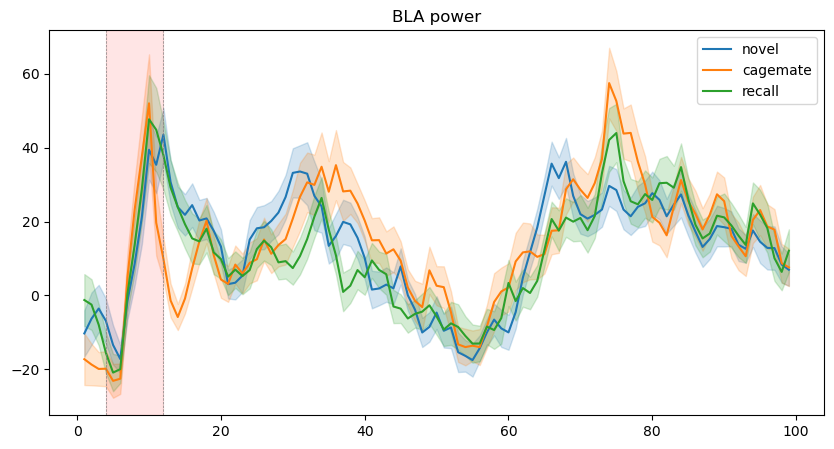

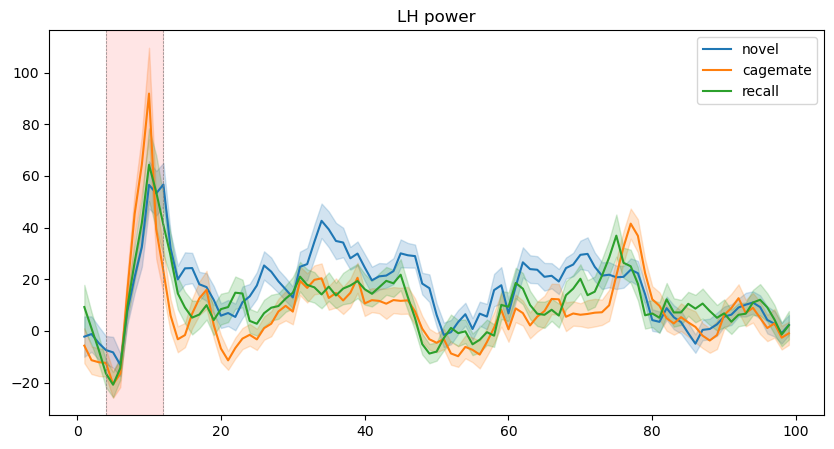

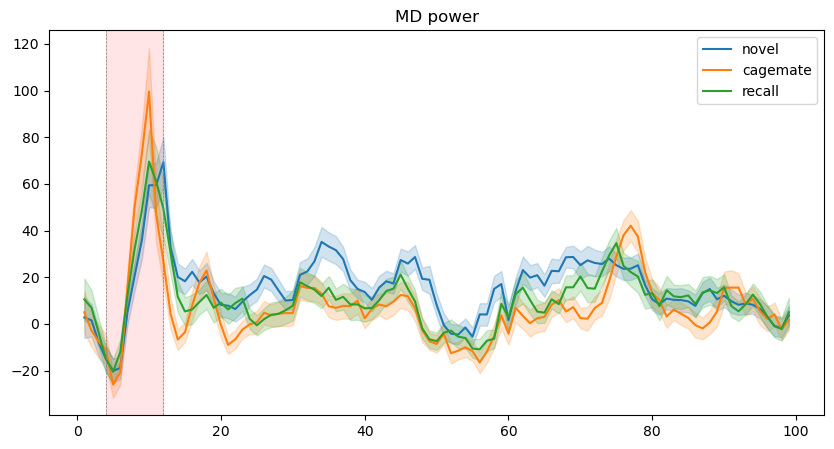

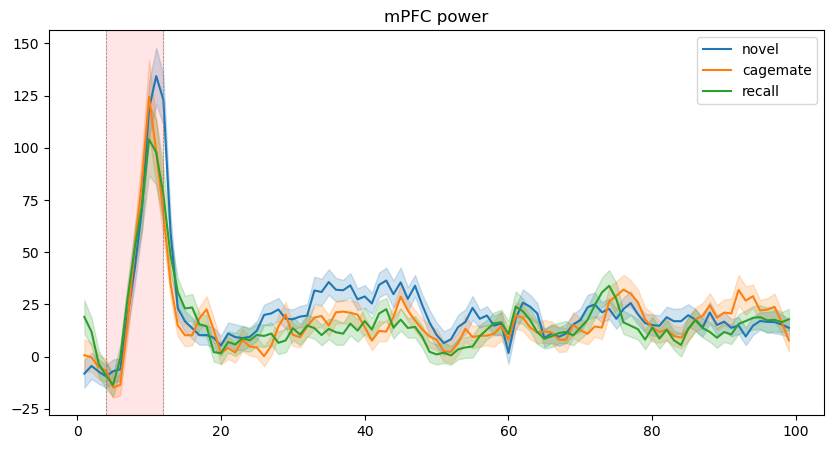

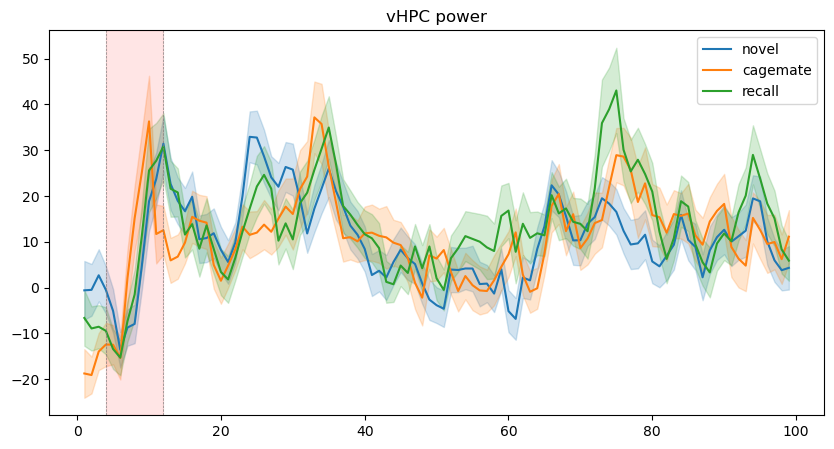

In [9]:
#test_analysis = LFPAnalysis(phase2_recordings)
test_analysis = LFPAnalysis(test_analysis.collection)
baseline = 'iti_events'
average_power = test_analysis.average_events(events = ['novel', 'cagemate', 'recall'],
                                             mode = 'power',
                                             baseline = baseline,
                                             event_len = None,
                                             pre_window=0,
                                             post_window = 0,
                                             plot = True)
# average_coherence = test_analysis.average_events(events = ['novel', 'cagemate', 'recall'],
#                                              mode = 'coherence',
#                                              baseline = 'iti_events',
#                                              event_len = None,
#                                              pre_window=0,
#                                              post_window = 0,
#                                              plot = False)
# average_granger = test_analysis.average_events(events = ['novel', 'cagemate', 'recall'],
#                                              mode = 'granger',
#                                              #baseline = 'iti_events',
#                                              event_len = None,
#                                              pre_window=0,
#                                              post_window = 0,
#                                              plot = False)






delta: 1-4
theta: 4-12 
beta: 13-30
low gamma: 31-70
high gamma: 71-100

In [10]:
tester_ = np.array([[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]])

tester_mean = np.mean(tester_[..., 0], axis = -1)

tester_[..., 0]
print(tester_mean)

[1. 1.]


In [41]:
# test_analysis = LFPAnalysis(test_analysis.collection)
# average_calculations = test_analysis.average_events(events = ['novel', 'recall', 'cagemate'], 
#                                                  mode = 'calculations',
#                                                 baseline = 'iti_events',
#                                                 plot = False)
# for key, value in average_calculations.items():
    
#     average_calculations[key] = value


def band_calcs(values):
    agent_band_dict = {}
    for agent, calculations in values.items():
        calculations = np.array(calculations)
        delta = np.nanmean(calculations[..., 0:4], axis = -1)
            
        theta = np.nanmean(calculations[..., 4:13], axis = -1)
        
        beta = np.nanmean(calculations[..., 13:31], axis = -1)
            
        low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
        
        high_gamma = np.nanmean(calculations[...,71:100], axis = -1)
        
            
        agent_band_dict[agent] = {'delta': delta,
                                        'theta': theta,
                                        'beta': beta,
                                        'low_gamma': low_gamma,
                                        'high_gamma': high_gamma}
           
    band_agent_dict = defaultdict(dict)
    for agent, bands in agent_band_dict.items():
        for band, values in bands.items():
            band_agent_dict[band][agent] = values
    
    return([agent_band_dict, band_agent_dict])


In [55]:
baseline = None

All set to analyze


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


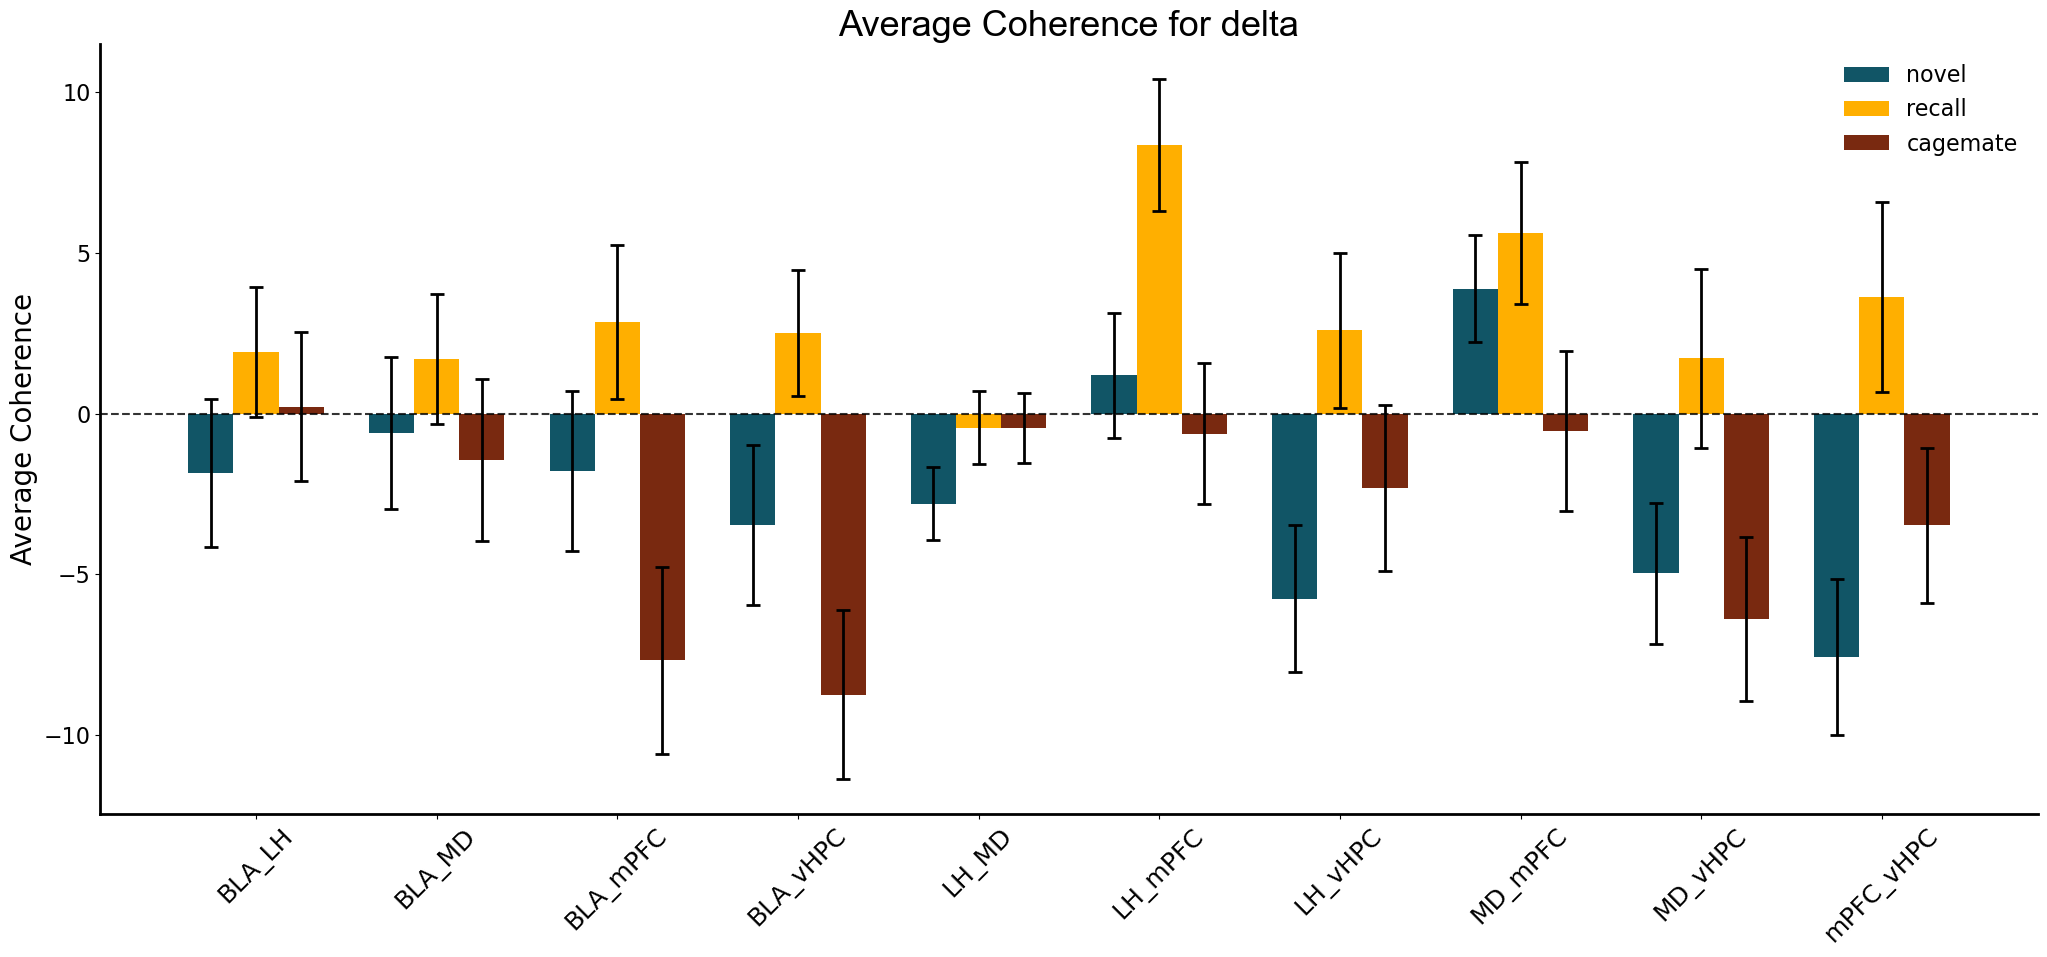

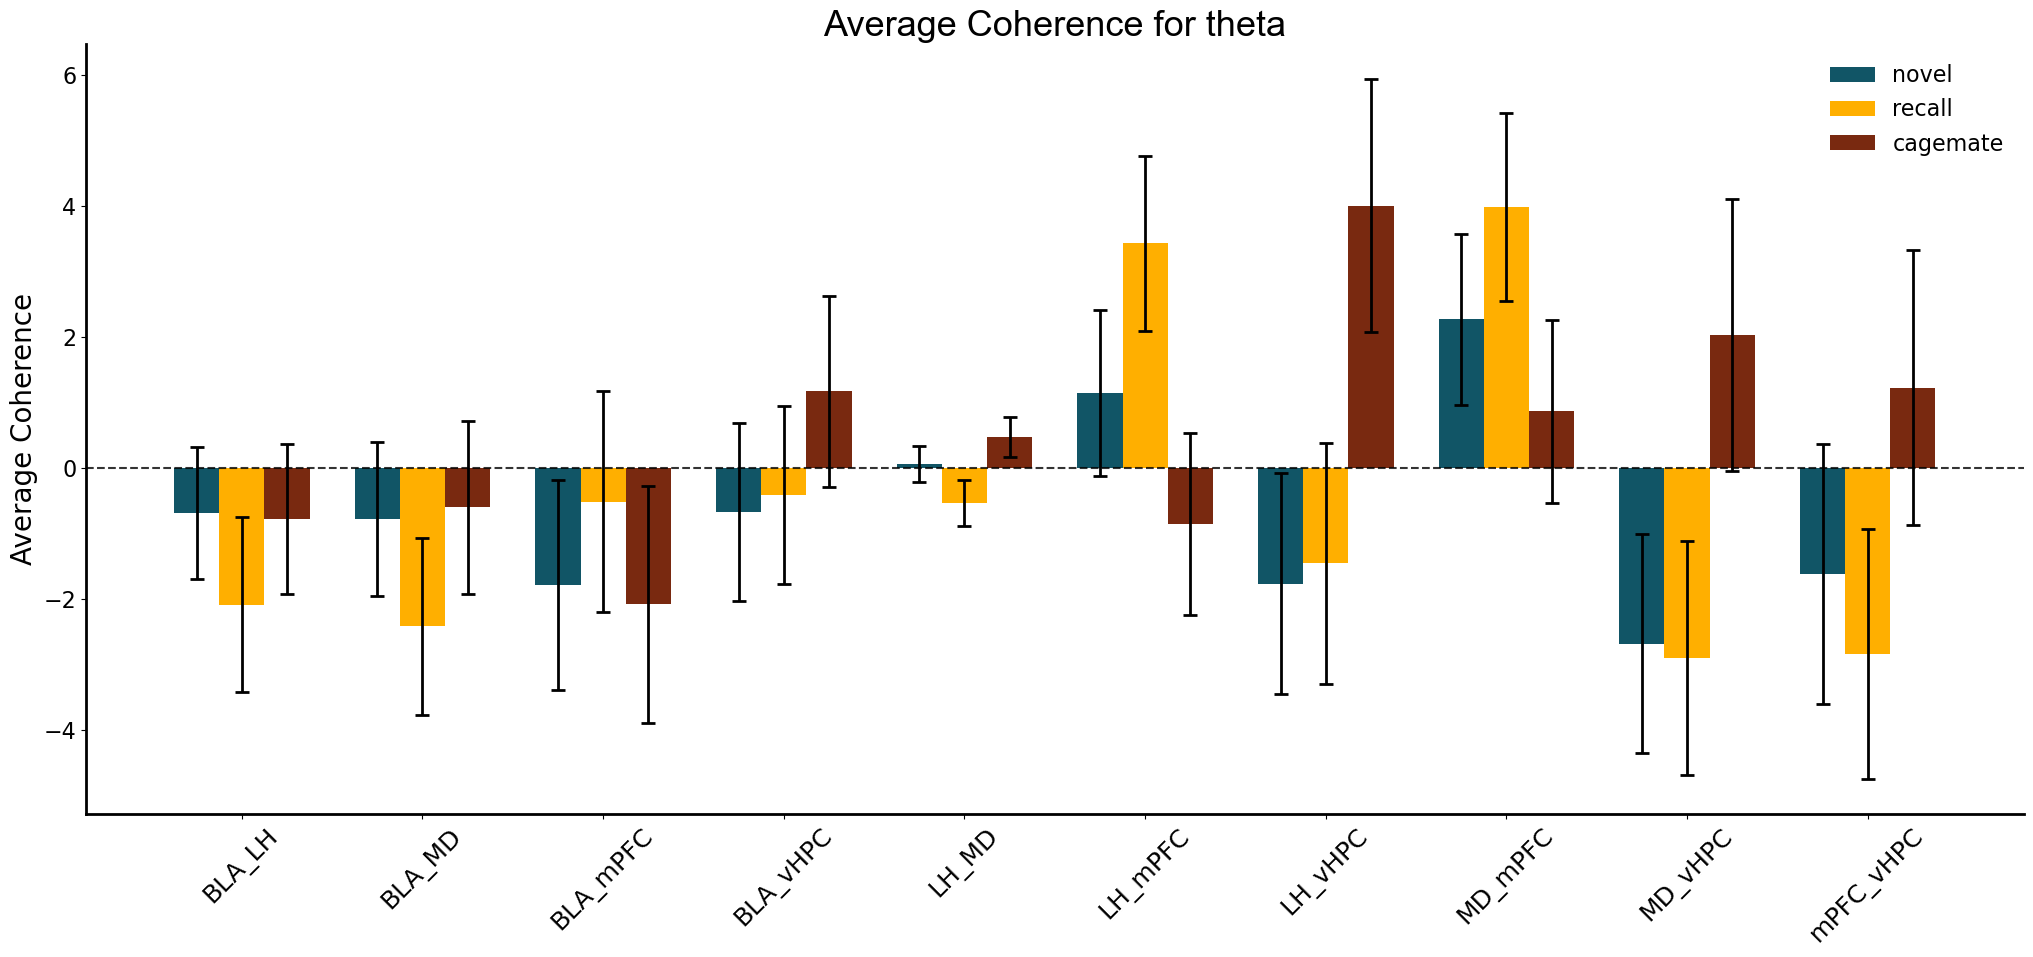

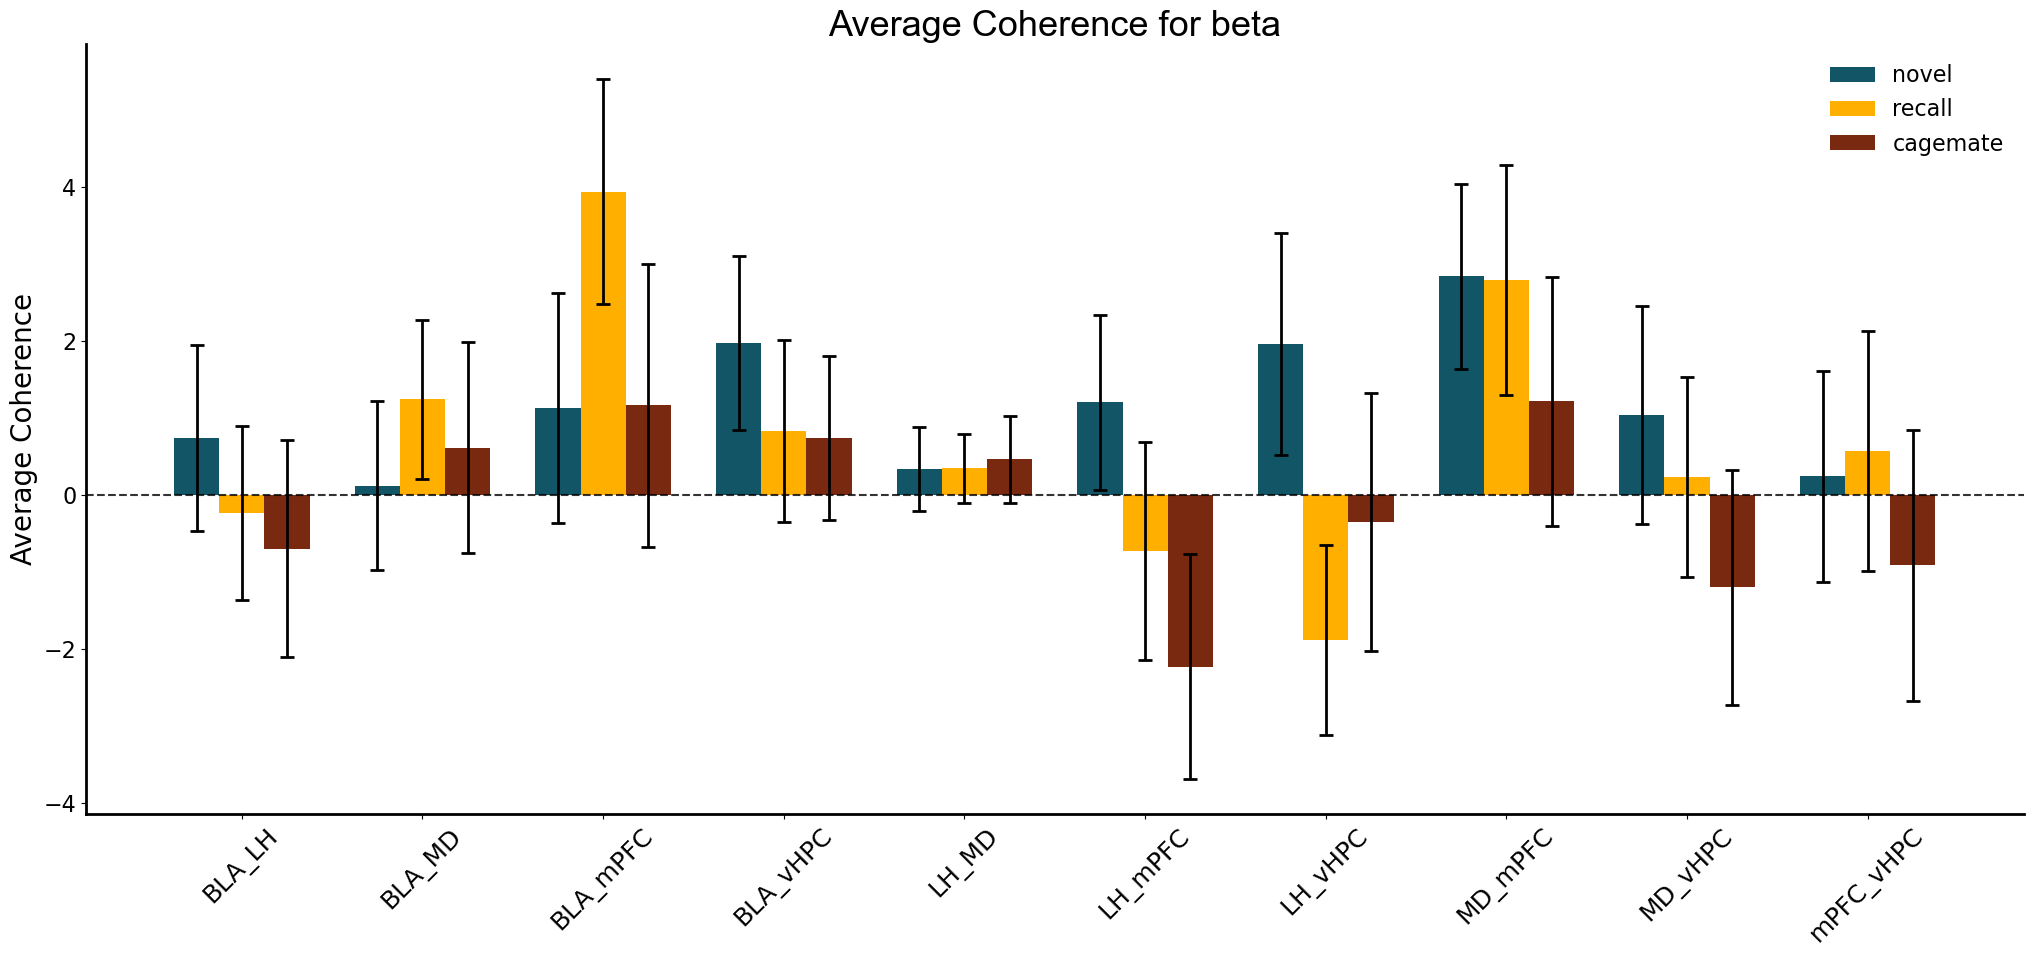

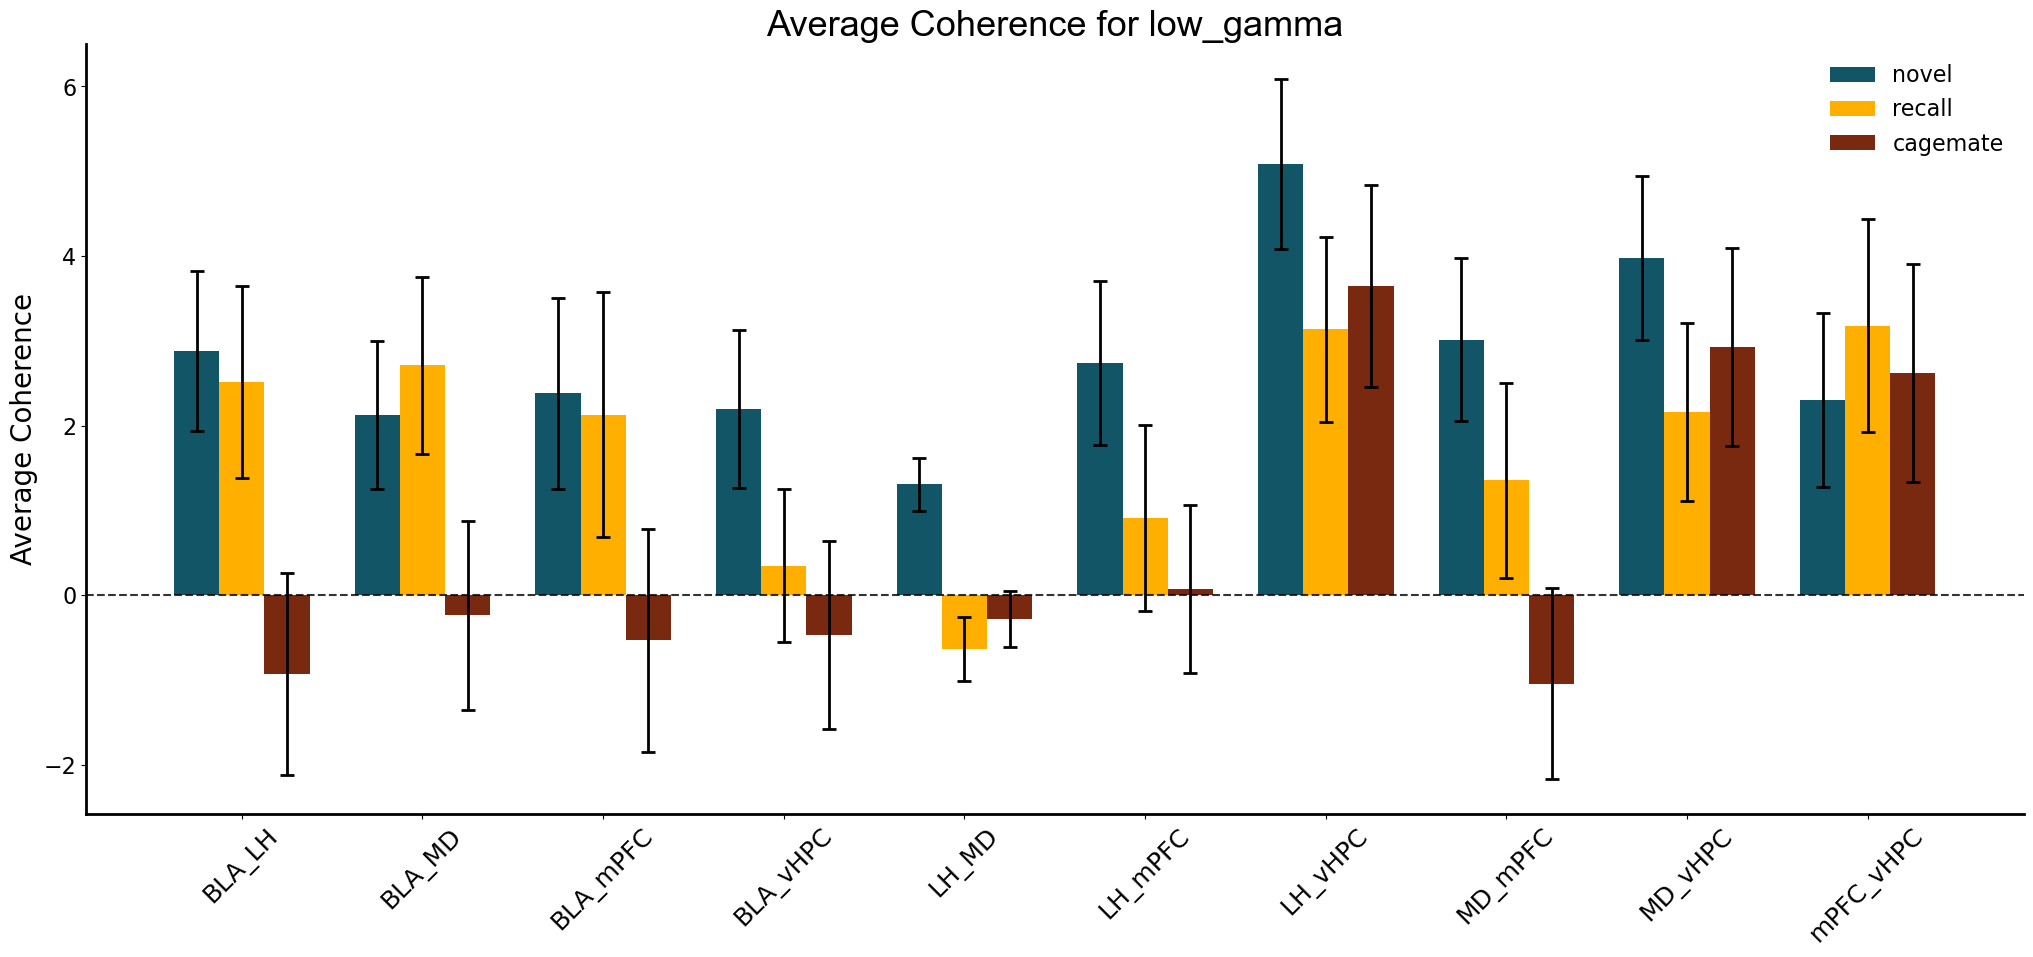

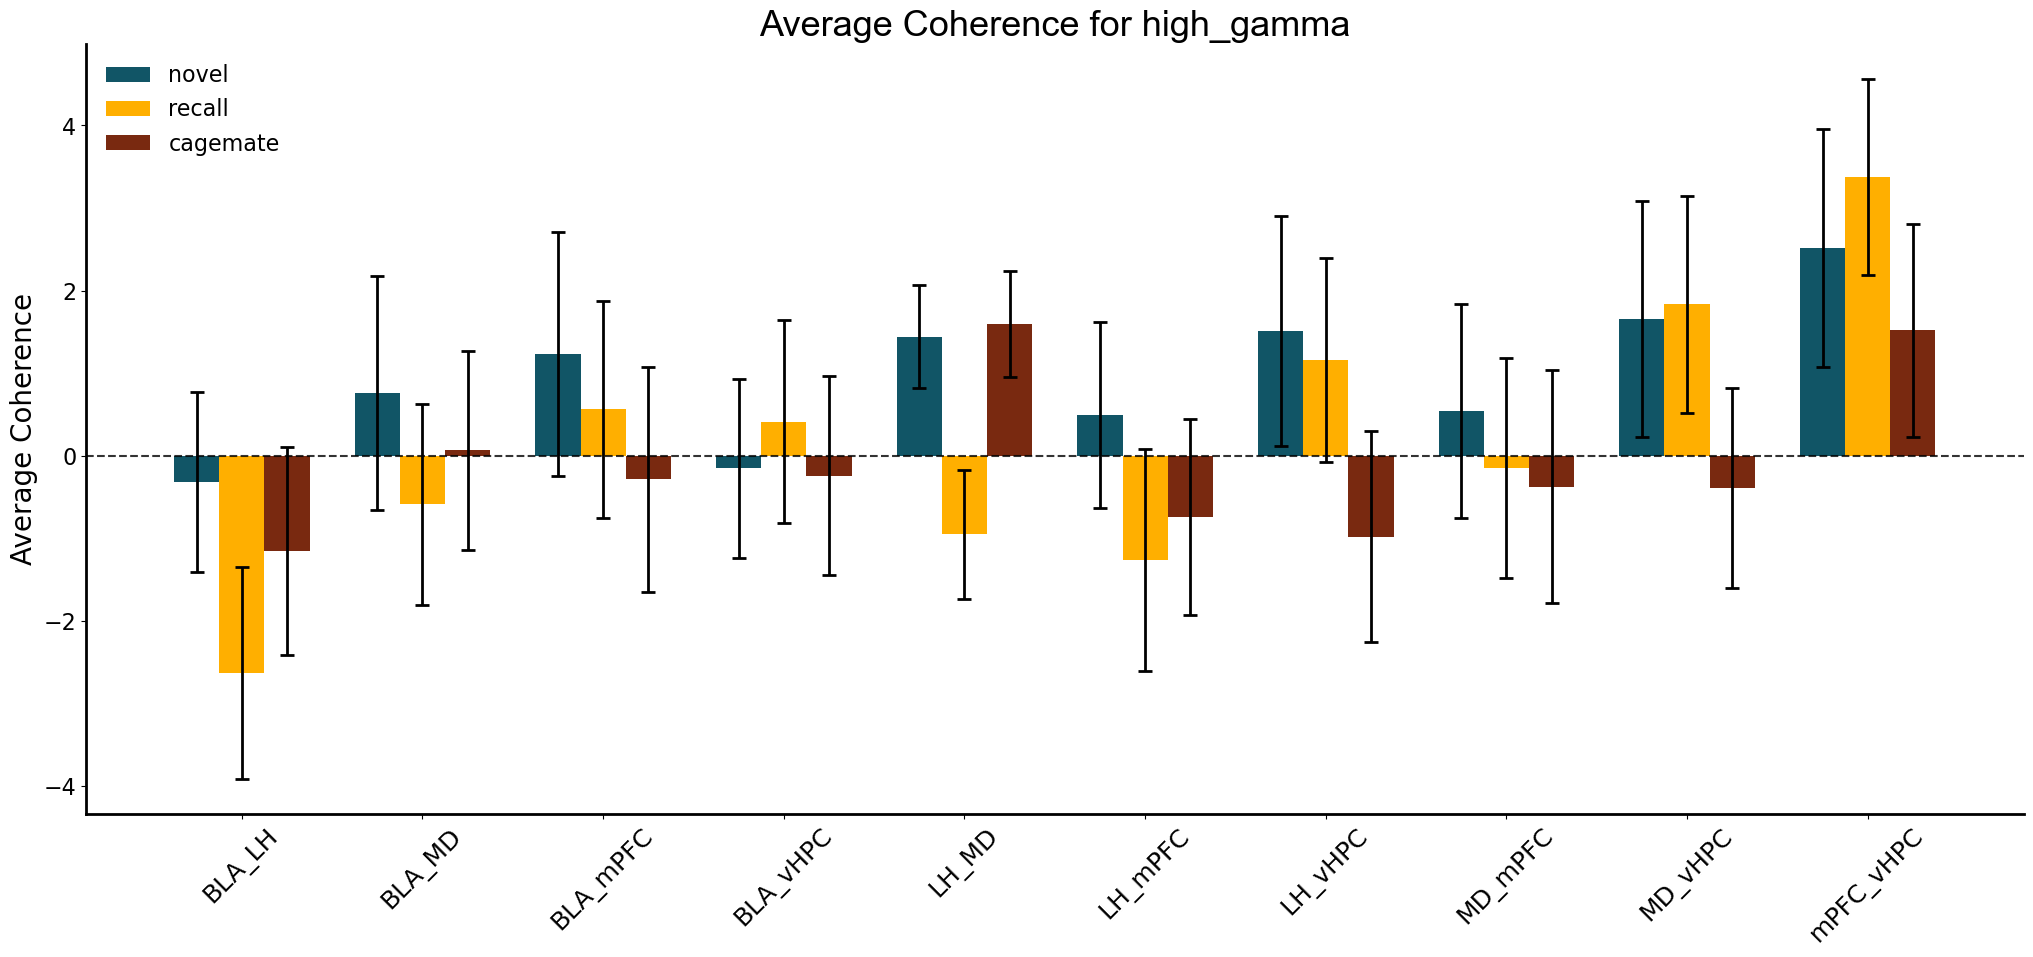

In [53]:
test_analysis = LFPAnalysis(test_analysis.collection)
categories = ['novel', 'recall', 'cagemate'] # Example categories
subset_names = [f'{i}' for i in test_analysis.coherence_pairs]  # Example subset names

coherences = test_analysis.average_events(events = categories, mode = 'coherence', baseline = baseline, plot = False)
[unflipped, flipped] = band_calcs(coherences)
avg_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}
sem_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}

for key in flipped.keys():
    for i, subset in enumerate(subset_names):
        for category in categories:
            avg_values[key][subset][category] = np.nanmean(flipped[key][category][:, i])
            sem_values[key][subset][category] = stats.sem(flipped[key][category][:, i], nan_policy='omit')

bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
# Create a separate plot for each key
group_spacing = 1 # Spacing between different subsets


bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
group_spacing = 1  # Spacing between different subsets

# Create a separate plot for each key
for key in flipped.keys():
    plt.figure(figsize=(25, 10))
    x = np.arange(len(subset_names)) * group_spacing  # x-axis positions for subsets
    
    for i, subset in enumerate(subset_names):
        for k, category in enumerate(categories):
            positions = x[i] + (k - 1) * (bar_width + spacing)  # Adjust positions for each category
            plt.bar(positions, avg_values[key][subset][category],
                    width=bar_width, yerr=sem_values[key][subset][category],
                    capsize=5,
                    linewidth=2,
                    error_kw={'elinewidth': 2, 'capthick': 2},
                    color=col[k], label=category if i == 0 else '')

    plt.yticks(fontsize=16)
    plt.xticks(x, subset_names, fontsize=18, rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
    plt.ylabel('Average Coherence', fontsize=20)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(f'Average Coherence for {key}', fontsize=26, font='Arial')
    plt.legend(fontsize=16, frameon=False)
    plt.subplots_adjust(hspace=0.5)
    plt.show()



C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=ke

dict_keys(['novel', 'recall', 'cagemate'])


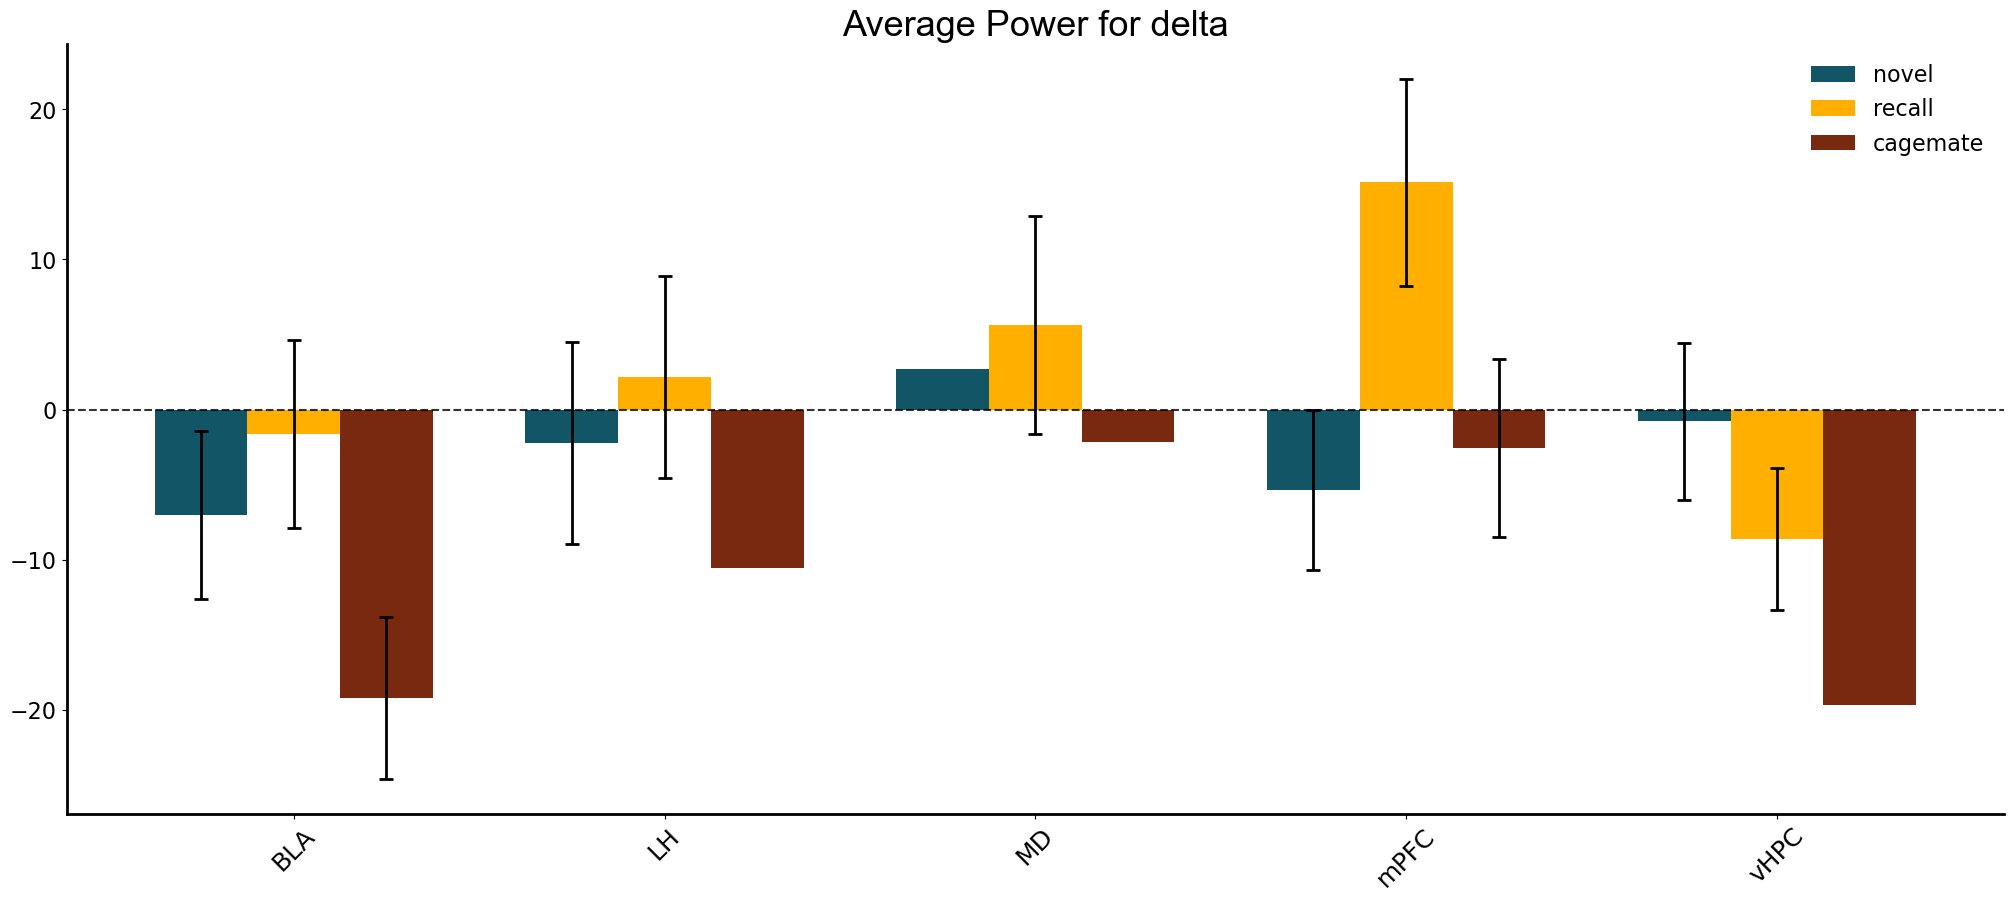

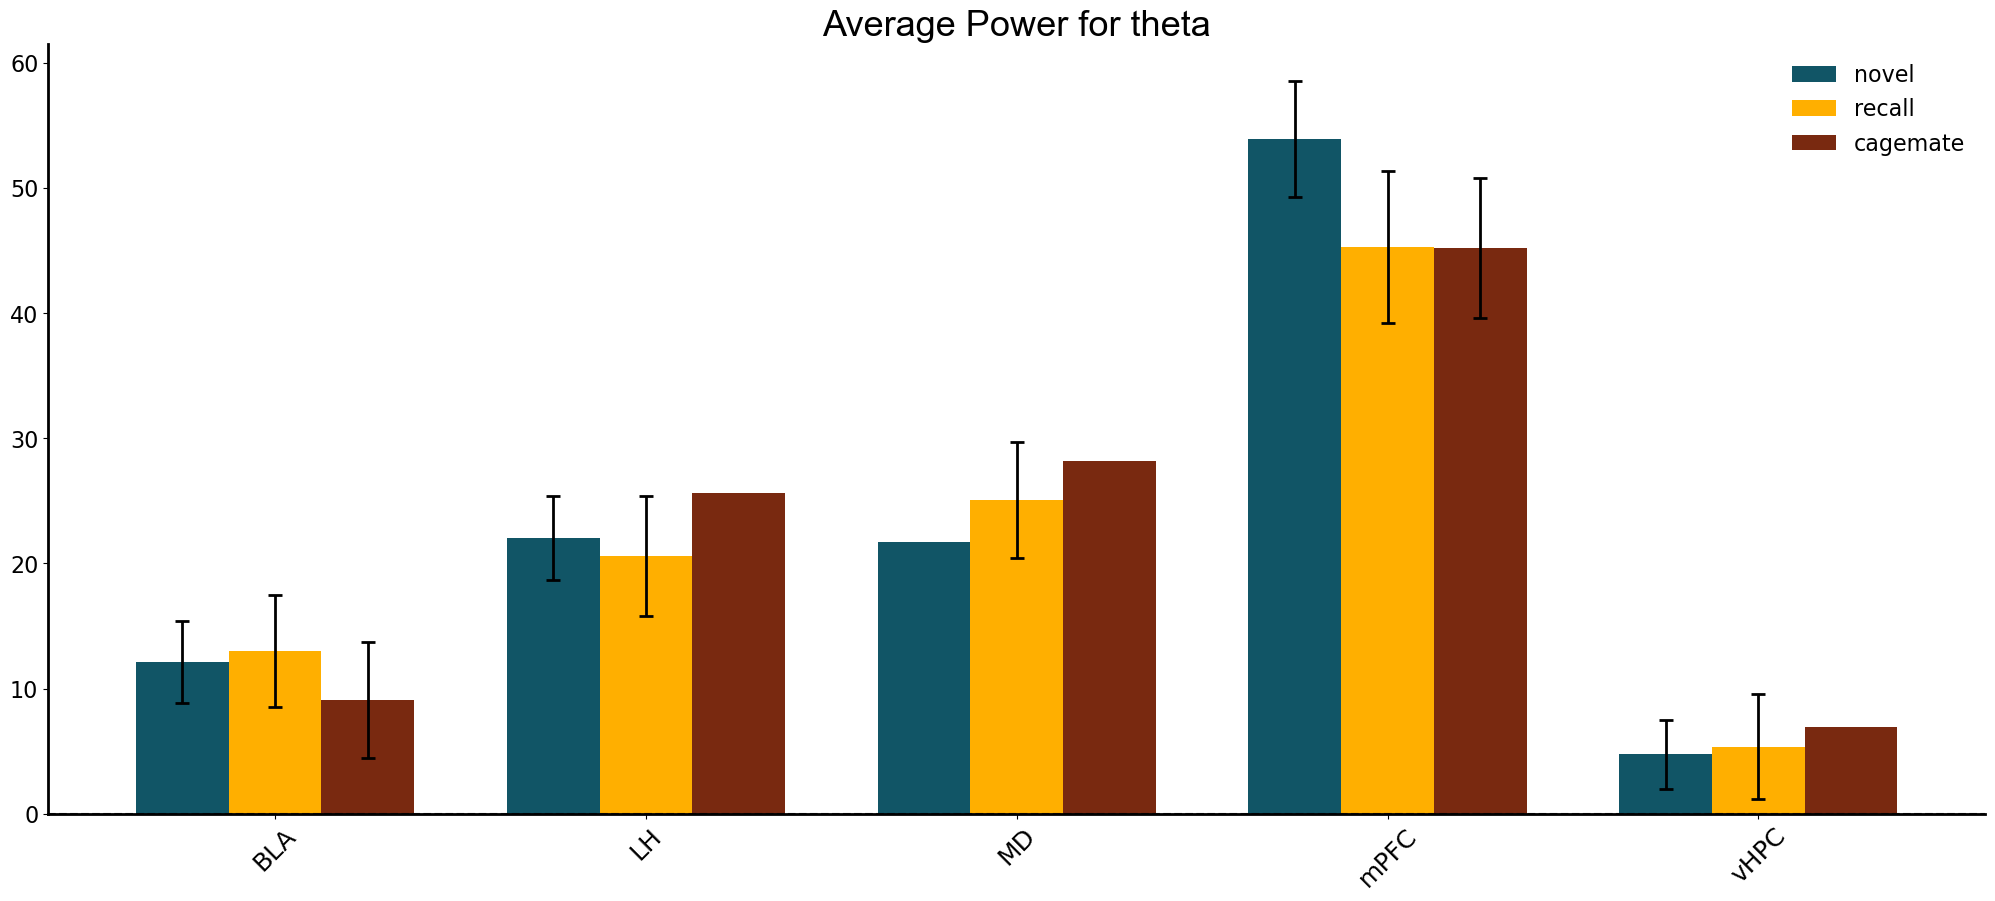

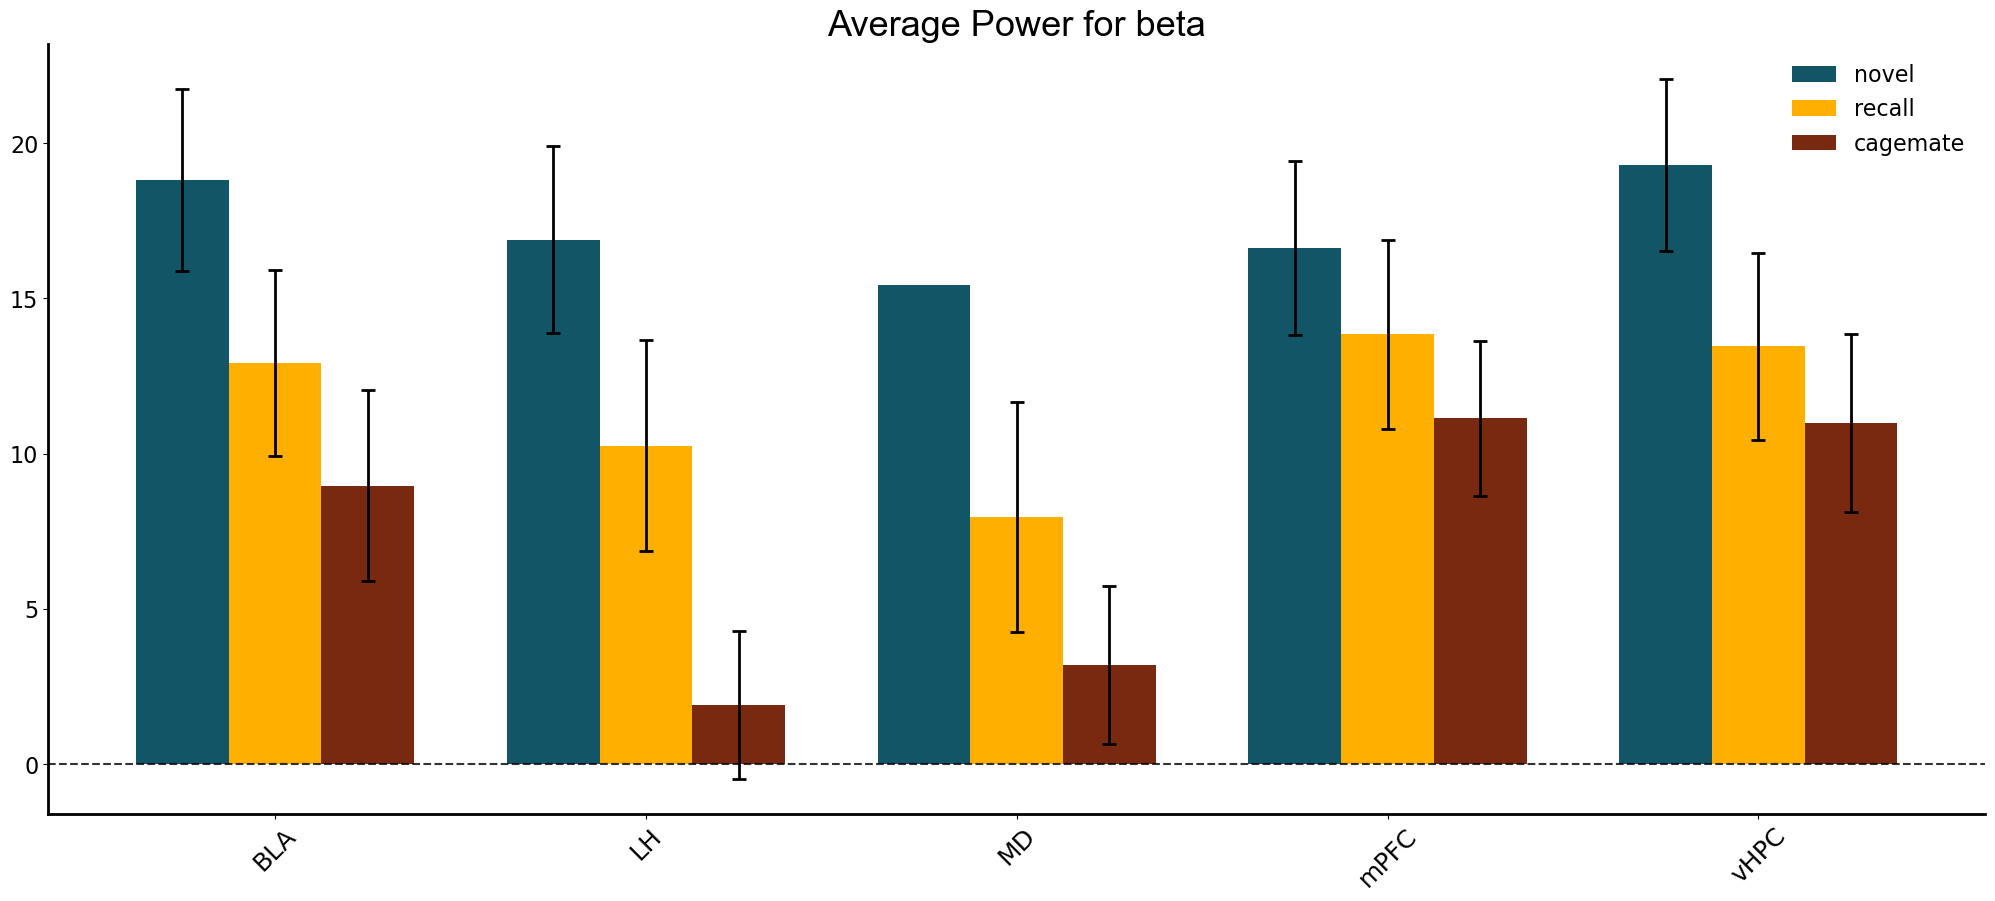

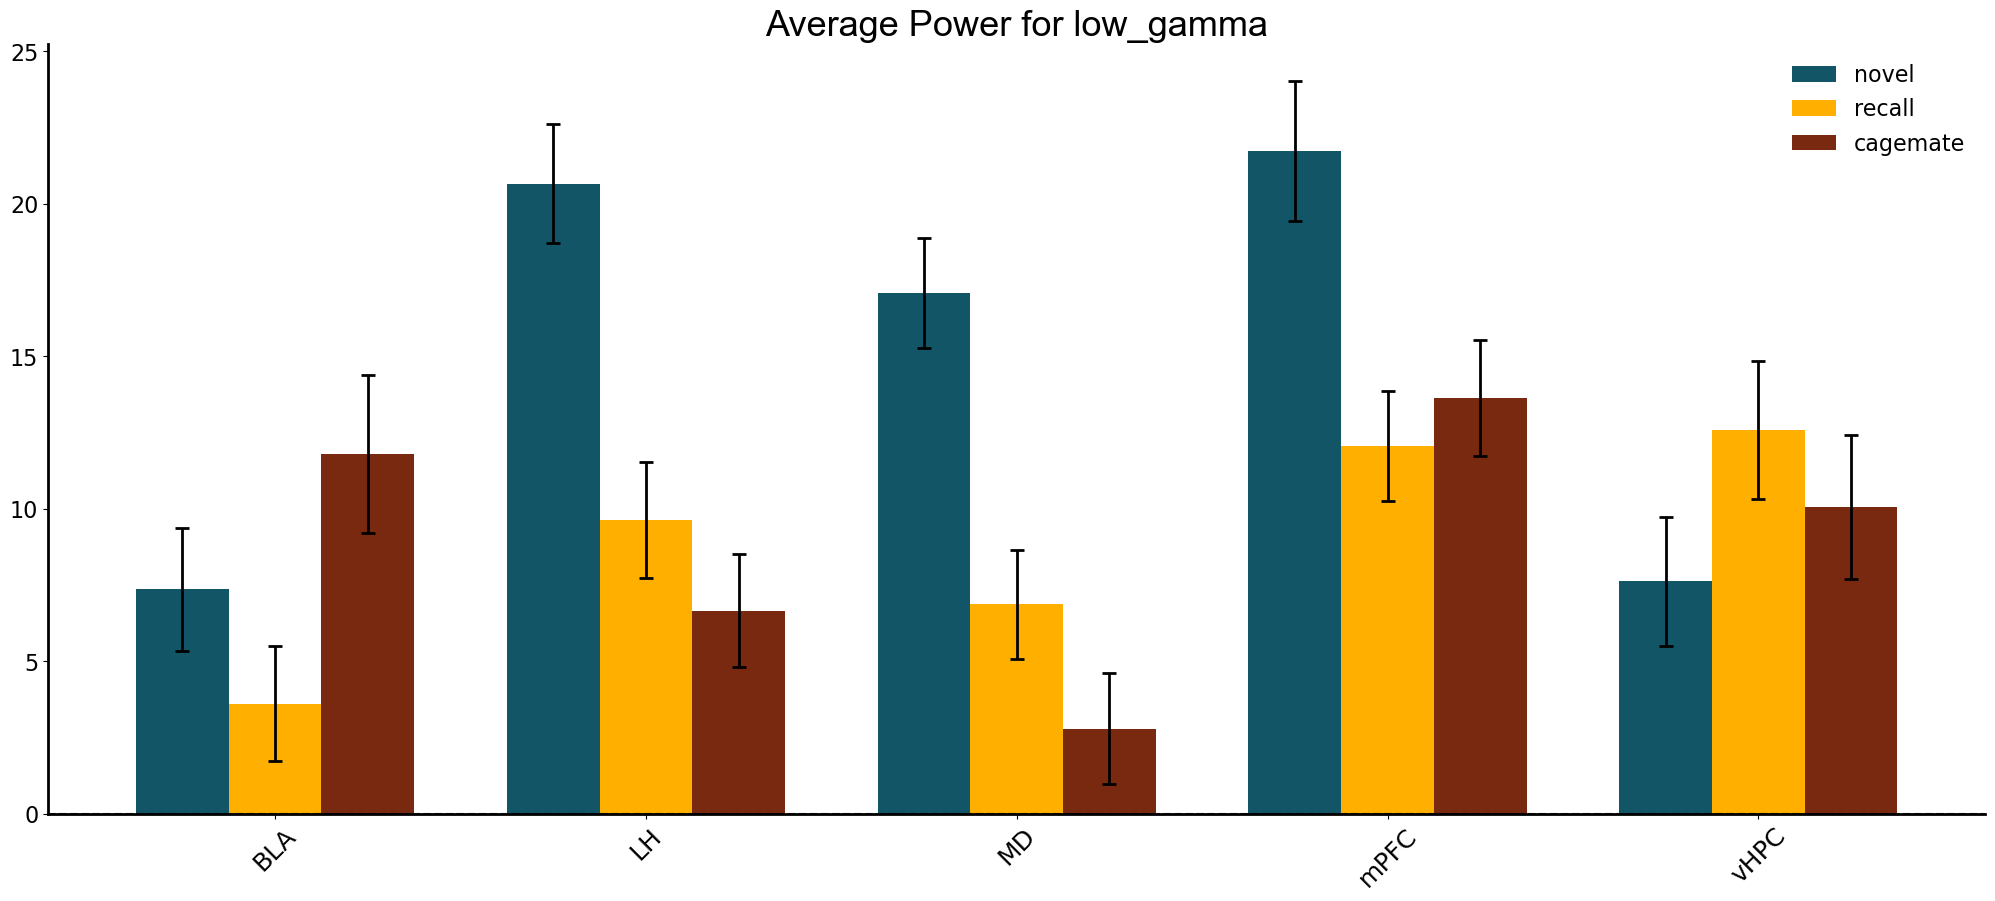

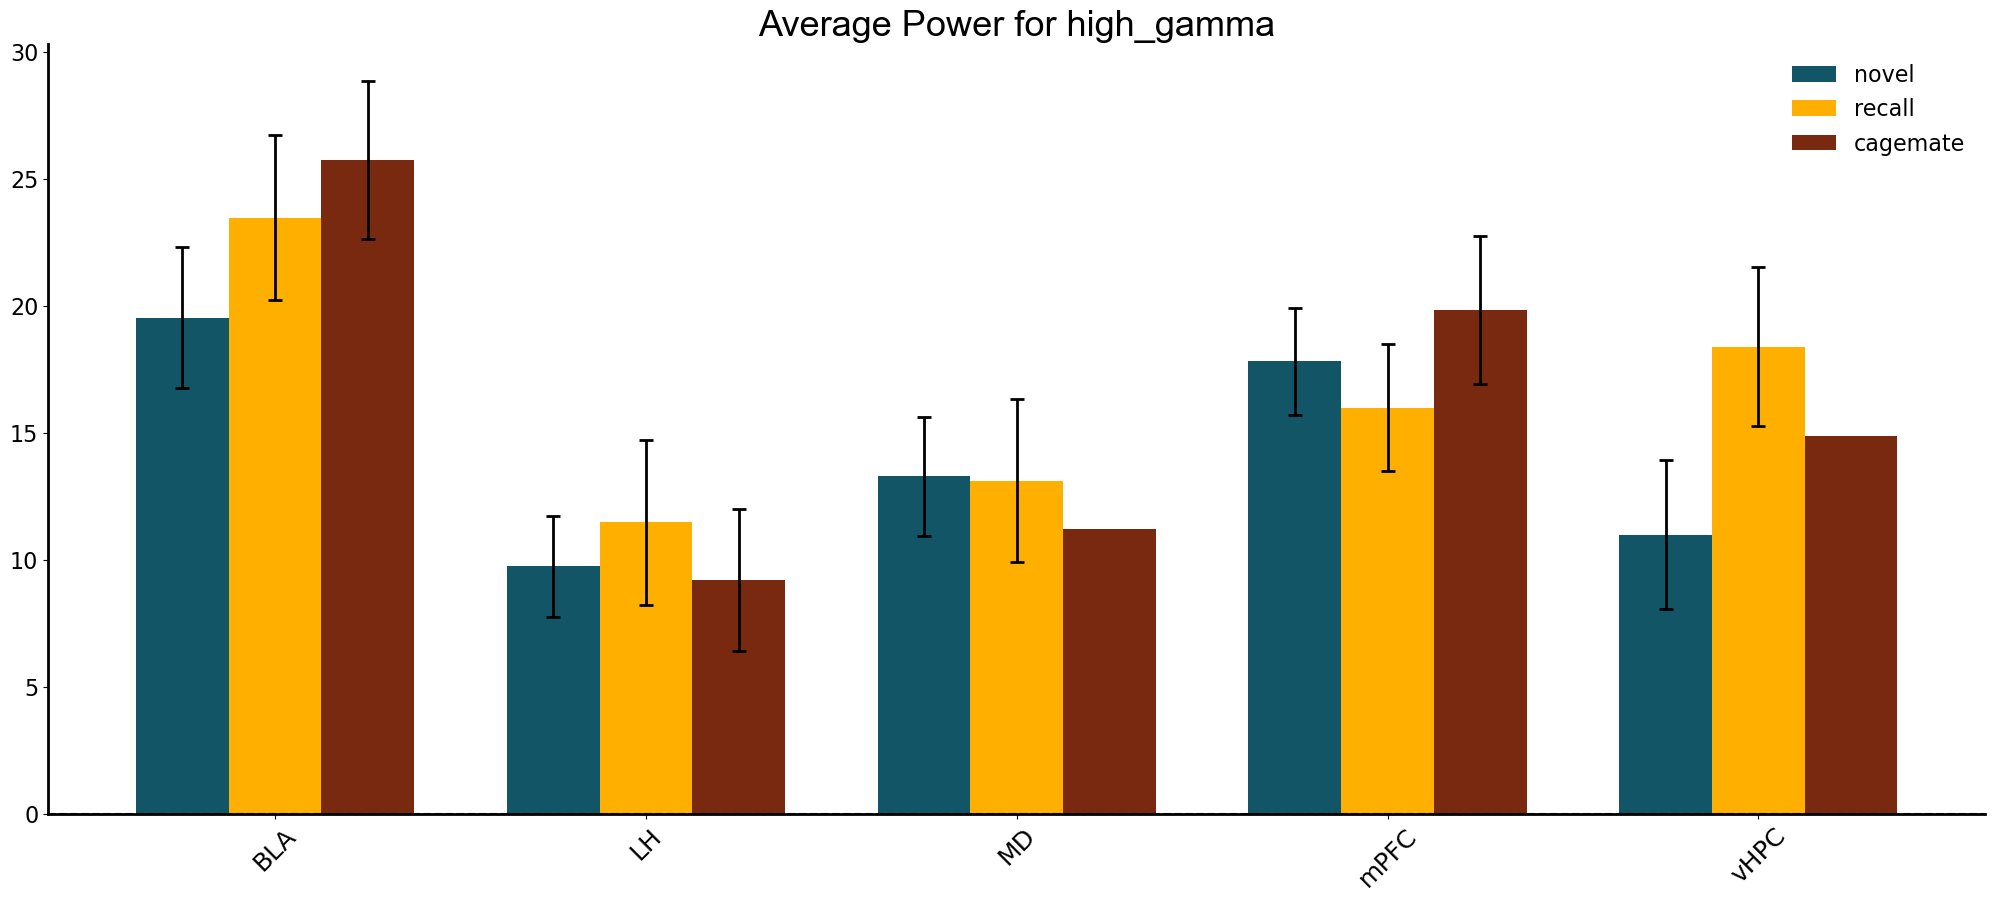

In [54]:
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

categories = ['novel', 'recall', 'cagemate'] # Example categories

powers = test_analysis.average_events(events = categories, mode = 'power', baseline = baseline, plot = False)
[unflipped, flipped] = band_calcs(powers)
print(unflipped.keys())
subset_names = test_analysis.brain_regions
avg_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}
sem_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}
for key in flipped.keys():
    for i, subset in enumerate(subset_names):
        for category in categories:
            avg_values[key][subset][category] = np.nanmean(flipped[key][category][:, i])
            sem_values[key][subset][category] = stats.sem(flipped[key][category][:, i], nan_policy='omit')
sorted_subset_names = test_analysis.brain_regions

bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
# Create a separate plot for each key
group_spacing = 1 # Spacing between different subsets
sorted_avg_values = {key: {subset: avg_values[key][subset] for subset in sorted_subset_names} for key in flipped.keys()}
sorted_sem_values = {key: {subset: sem_values[key][subset] for subset in sorted_subset_names} for key in flipped.keys()}

bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
group_spacing = 1  # Spacing between different subsets

# Create a separate plot for each key
for key in flipped.keys():
    plt.figure(figsize=(25, 10))
    x = np.arange(len(sorted_subset_names)) * group_spacing  # x-axis positions for subsets
    
    for i, subset in enumerate(sorted_subset_names):
        for k, category in enumerate(categories):
            positions = x[i] + (k - 1) * (bar_width + spacing)  # Adjust positions for each category
            plt.bar(positions, sorted_avg_values[key][subset][category],
                    width=bar_width, yerr=sorted_sem_values[key][subset][category],
                    capsize=5,
                    linewidth=2,
                    error_kw={'elinewidth': 2, 'capthick': 2},
                    color=col[k], label=category if i == 0 else '')

    plt.yticks(fontsize=16)
    plt.xticks(x, sorted_subset_names, fontsize=18, rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(f'Average Power for {key}', fontsize=26, font='Arial')
    plt.legend(fontsize=16, frameon=False)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

def trial_decoder(num_fold,
                  num_shuffle,
                  events,
                  model,
                  mode,
                  baseline = None,
                  event_len = None,
                  pre_window = 0,
                  post_window = 0):
    data = test_analysis.average_events(events = events,
                                        mode = mode,
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    #for not granger: data = [trials, brain regions/pairs, frequencies]
    #for granger: data = [trials, brain region, brain region, freqeuncies]
    [agent_band_dict, band_agent_dict] = band_calcs(data)
    #decoder data = [trials, ...] for each band
    decoder_data = {}
    for event in events: 
        band_dict = agent_band_dict[event]
        stacked_bands = np.stack(list(band_dict.values()), axis = 0)
        #stacked bands = [band, trials, ...]
        if mode != 'granger':
            reshaped_bands = np.transpose(stacked_bands, (1,0,2))
        if mode == 'granger':
            reshaped_bands = np.transpose(stacked_bands, (1,0,2,3))
        reshaped_bands = reshaped_bands.reshape(reshaped_bands.shape[0], -1)
        decoder_data[event] = reshaped_bands
    auc = {}
    prob = {}
    weights = {}
    for event in events:
        data_neg = []
        data_pos = []
        for trial in range(decoder_data[event].shape[0]):
            trial_data = decoder_data[event][trial,...]
            #if np.sum(np.isnan(trial_data)) == 0:
            data_pos.append(trial_data)
        for neg_event in np.setdiff1d(events, event):
            for trial in range(decoder_data[neg_event].shape[0]):
                trial_data = decoder_data[neg_event][trial,...]
            #    if np.sum(np.isnan(trial_data)) == 0:
                data_neg.append(trial_data)
        data_pos = np.stack(data_pos)
        #data_pos = trials x features
        data_neg = np.stack(data_neg)
        num_pos = data_pos.shape[0]
        num_neg = data_neg.shape[0]
        print(num_pos + num_neg)
        data_pos = data_pos[np.random.permutation(num_pos), :]
        data_neg = data_neg[np.random.permutation(num_neg), :]
        model_keys = {'glm': ['glm', 'glm_shuffle'],
                    'rf': ['rf', 'rf_shuffle'],
                    'both': ['glm', 'rf', 'glm_shuffle',
                             'rf_shuffle']}
        auc[event] = {key: [] for key in model_keys[model]}
        prob[event] = {key: [] for key in model_keys[model]}
        weights[event] = {key: [] for key in model_keys[model]}
        for fold in range(num_fold):
            data_test, label_test, data_train, label_train = __train_test_split__(fold,
                                                                                    num_fold,
                                                                                    data_pos,
                                                                                    data_neg,
                                                                                    num_pos,
                                                                                    num_neg)
            pred_glm, weight_glm, pred_rf, feat_imp_rf = __run_model__(model,
                                            data_train,
                                            data_test,
                                            label_train)
            if (model == 'glm') | (model == 'both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm'].append(auc_glm)
                prob[event]['glm'].append(pred_glm)
                weights[event]['glm'].append(weight_glm)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf'].append(auc_rf)
                prob[event]['rf'].append(pred_rf) 
                weights[event]['rf'].append(feat_imp_rf)    
        for shuffle in range(num_shuffle):
            label_train = np.random.permutation(label_train)
            pred_glm, weight_glm, pred_rf, feat_imp_rf =  __run_model__(model,
                                                data_train,
                                                data_test,
                                                label_train)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf_shuffle'].append(auc_rf)
                prob[event]['rf_shuffle'].append(pred_rf)
                weights[event]['rf_shuffle'].append(feat_imp_rf)
            if (model == 'glm') | (model =='both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm_shuffle'].append(auc_glm)
                prob[event]['glm_shuffle'].append(pred_glm)
                weights[event]['glm_shuffle'].append(weight_glm)
    return [auc, prob, weights]  


def __train_test_split__(fold, num_fold, data_pos, data_neg, num_pos, num_neg):
    pos_fold = num_pos // num_fold
    neg_fold = num_neg // num_fold
    data_test = np.concatenate((data_pos[fold * pos_fold:(fold + 1) * pos_fold, :],
                                data_neg[fold * neg_fold:(fold + 1) * neg_fold, :]), axis=0)
    label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                np.zeros((fold + 1) * neg_fold - fold * neg_fold)))
    data_train = np.concatenate((
        data_pos[np.setdiff1d(np.arange(num_pos), np.arange(fold * pos_fold, (fold + 1) * pos_fold)), :],
        data_neg[np.setdiff1d(np.arange(num_neg), np.arange(fold * neg_fold, (fold + 1) * neg_fold)), :]),
        axis=0)
    label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                np.zeros(num_neg - (fold + 1) * neg_fold + fold * neg_fold)))
    return (data_test, label_test, data_train, label_train) 

def __run_model__(model, data_train, data_test, label_train):
    if (model == 'glm') | (model == 'both'):
        model_glm = LogisticRegression(class_weight='balanced', max_iter = 1000000)
        model_glm.fit(data_train, label_train)
        pred_glm = model_glm.predict_proba(data_test)
        weights_glm = model_glm.coef_
        if model == 'glm':
            pred_rf = None
            feat_imp_rf = None
    if (model == 'rf') | (model == 'both'):
        #model_rf = RandomForestClassifier(class_weight = 'balanced',
                                    # n_estimators=100,
                                    # random_state=0)
        # model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'),
        #                                 n_estimators=100,
        #                                 random_state=0)
        model_rf = XGBClassifier(n_estimators=100, max_depth=6, objective='binary:logistic')
        model_rf.fit(data_train, label_train,sample_weight=compute_sample_weight("balanced", label_train))
        pred_rf = model_rf.predict_proba(data_test)
        #feat_imp_rf = model_rf.feature_importances_
        feat_imp_rf = model_rf.feature_importances_
        if model == 'rf':
            pred_glm = None
            weights_glm = None
    return (pred_glm, weights_glm, pred_rf, feat_imp_rf)



def get_feature_indices(top_features):
    band_dict = {'delta': 0, 'theta': 1, 'beta': 2, 'low_gamma': 3, 'high_gamma':4}
    top_power_indices = []
    top_coherence_indices = []
    for feature in np.unique(top_features):
        brain_region = feature.split(" ")[0]
        band = feature.split(" ")[1:]
        if len(band) == 2:
            band = band[0] + "_" + band[1]
        else:
            band = band[0]
        band_index = band_dict[band]
        try:
            brain_index = test_analysis.brain_region_dict[brain_region]
            power_index = band_index * 5 + brain_index
            top_power_indices.append(power_index)
        except KeyError:
            brain_index = test_analysis.coherence_pairs_dict[brain_region]
            coherence_index = band_index * 10 + brain_index
            top_coherence_indices.append(coherence_index)
    return(sorted(top_power_indices), sorted(top_coherence_indices))

def top_feat_trial_decoder(num_fold,
                  num_shuffle,
                  events,
                  model,
                  top_features = None,
                  baseline = None,
                  event_len = None,
                  pre_window = 0,
                  post_window = 0):
    power_data = test_analysis.average_events(events = events,
                                        mode = 'power',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    coherence_data = test_analysis.average_events(events = events,
                                        mode = 'coherence',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    #for not granger: data = [trials, brain regions/pairs, frequencies]
    #for granger: data = [trials, brain region, brain region, freqeuncies]
    [power_agent_band_dict, power_band_agent_dict] = band_calcs(power_data)
    [coherence_agent_band_dict, coherence_band_agent_dict] = band_calcs(coherence_data)
    #decoder data = [trials, ...] for each band
    decoder_data = {}
    if top_features is not None:
        power_indices, coherence_indices = get_feature_indices(top_features)
    for event in events: 
        p_band_dict = power_agent_band_dict[event]
        c_band_dict = coherence_agent_band_dict[event]
        p_stacked_bands = np.stack(list(p_band_dict.values()), axis = 0)
        c_stacked_bands = np.stack(list(c_band_dict.values()), axis = 0)
        #stacked bands = [band, trials, ...]
        p_reshaped_bands = np.transpose(p_stacked_bands, (1,0,2))
        c_reshaped_bands = np.transpose(c_stacked_bands, (1,0,2))
        p_bands = p_reshaped_bands.reshape(p_reshaped_bands.shape[0], -1)
        c_bands = c_reshaped_bands.reshape(c_reshaped_bands.shape[0], -1)
        if top_features is not None: 
            p_bands = p_bands[:, power_indices]
            c_bands = c_bands[:,coherence_indices]
        pc_bands = np.concatenate([p_bands, c_bands], axis = 1)
        decoder_data[event] = pc_bands
    auc = {}
    prob = {}
    weights = {}
    for event in events:
        data_neg = []
        data_pos = []
        for trial in range(decoder_data[event].shape[0]):
            trial_data = decoder_data[event][trial,...]
            #if np.sum(np.isnan(trial_data)) == 0:
            data_pos.append(trial_data)
        for neg_event in np.setdiff1d(events, event):
            for trial in range(decoder_data[neg_event].shape[0]):
                trial_data = decoder_data[neg_event][trial,...]
            #    if np.sum(np.isnan(trial_data)) == 0:
                data_neg.append(trial_data)
        data_pos = np.stack(data_pos)
        #data_pos = trials x features
        data_neg = np.stack(data_neg)
        num_pos = data_pos.shape[0]
        num_neg = data_neg.shape[0]
        print(num_pos + num_neg)
        data_pos = data_pos[np.random.permutation(num_pos), :]
        data_neg = data_neg[np.random.permutation(num_neg), :]
        model_keys = {'glm': ['glm', 'glm_shuffle'],
                    'rf': ['rf', 'rf_shuffle'],
                    'both': ['glm', 'rf', 'glm_shuffle',
                             'rf_shuffle']}
        auc[event] = {key: [] for key in model_keys[model]}
        prob[event] = {key: [] for key in model_keys[model]}
        weights[event] = {key: [] for key in model_keys[model]}
        for fold in range(num_fold):
            data_test, label_test, data_train, label_train = __train_test_split__(fold,
                                                                                    num_fold,
                                                                                    data_pos,
                                                                                    data_neg,
                                                                                    num_pos,
                                                                                    num_neg)
            pred_glm, weight_glm, pred_rf, feat_imp_rf = __run_model__(model,
                                            data_train,
                                            data_test,
                                            label_train)
            if (model == 'glm') | (model == 'both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm'].append(auc_glm)
                prob[event]['glm'].append(pred_glm)
                weights[event]['glm'].append(weight_glm)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf'].append(auc_rf)
                prob[event]['rf'].append(pred_rf) 
                weights[event]['rf'].append(feat_imp_rf)    
        for shuffle in range(num_shuffle):
            label_train = np.random.permutation(label_train)
            pred_glm, weight_glm, pred_rf, feat_imp_rf =  __run_model__(model,
                                                data_train,
                                                data_test,
                                                label_train)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf_shuffle'].append(auc_rf)
                prob[event]['rf_shuffle'].append(pred_rf)
                weights[event]['rf_shuffle'].append(feat_imp_rf)
            if (model == 'glm') | (model =='both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm_shuffle'].append(auc_glm)
                prob[event]['glm_shuffle'].append(pred_glm)
                weights[event]['glm_shuffle'].append(weight_glm)
    return [auc, prob, weights] 



In [21]:
events = ['cagemate','novel', 'recall']
event_len = None
baseline = 'iti_events'
model = 'rf'
pre_window = 0
post_window = 0
num_fold = 5
num_shuffle = 5



auc_iter, prob_iter, weights_iter = [],[],[]
auc_iter_c, prob_iter_c, weights_iter_c = [], [], []
for i in range(10):
    [auc, prob, weights] = trial_decoder(num_fold,
                    num_shuffle,
                    events,
                    model,
                    mode = 'power',
                    baseline = baseline,
                    event_len = None,
                    pre_window = 0,
                    post_window = 0)
    auc_iter.append(auc)
    prob_iter.append(prob)
    weights_iter.append(weights)

    [coh_auc, coh_prob, coh_weights] = trial_decoder(num_fold,
                    num_shuffle,
                    events,
                    model ='rf',
                    mode  = 'coherence',
                    baseline = baseline,
                    event_len = None,
                    pre_window = 0,
                    post_window = 0)
    auc_iter_c.append(coh_auc)
    prob_iter_c.append(coh_prob)
    weights_iter_c.append(coh_weights)



def average_nested_dict_values(dict_list):
    def recursive_average(dicts):
        # Initialize an empty dictionary to store the averaged values
        averaged_dict = {}
        
        # Iterate through the keys of the first dictionary in the list
        for key in dicts[0].keys():
            # Check if the value is a dictionary itself
            if isinstance(dicts[0][key], dict):
                # Recursively process nested dictionaries
                nested_dicts = [d[key] for d in dicts]
                averaged_dict[key] = recursive_average(nested_dicts)
            else:
                # Extract the list of numpy arrays corresponding to the current key from all dictionaries
                array_list = [d[key] for d in dicts]
                
                # Stack the arrays along a new dimension and compute the mean along that dimension
                averaged_dict[key] = np.mean(np.stack(array_list, axis=0), axis=0)
        
        return averaged_dict

    return recursive_average(dict_list)

auc_iter_avg = average_nested_dict_values(auc_iter)
prob_iter_avg = average_nested_dict_values(prob_iter)
weights_iter_avg = average_nested_dict_values(weights_iter)
auc_iter_c_avg = average_nested_dict_values(auc_iter_c)
prob_iter_c_avg = average_nested_dict_values(prob_iter_c)
weights_iter_c_avg = average_nested_dict_values(weights_iter_c)

[g_auc, g_prob, g_weights] = trial_decoder(num_fold,
                  num_shuffle,
                  events,
                  model,
                  mode = 'granger',
                  baseline = baseline,
                  event_len = None,
                  pre_window = 0,
                  post_window = 0)


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:301: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 2)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:354: RuntimeWarning: Mean of empty slice
  baseline_recording = np.nanmean(np.array(baseline_averages), axis = 0)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\A

270
270
270


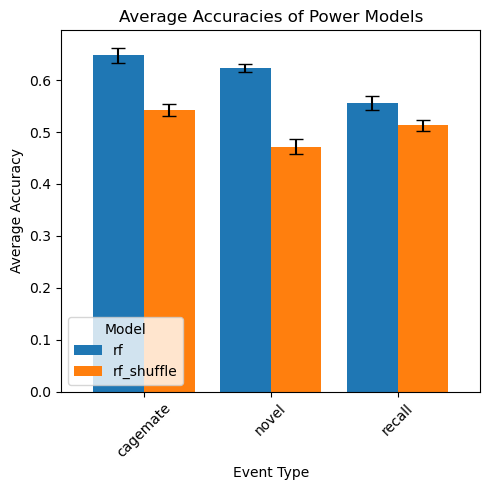

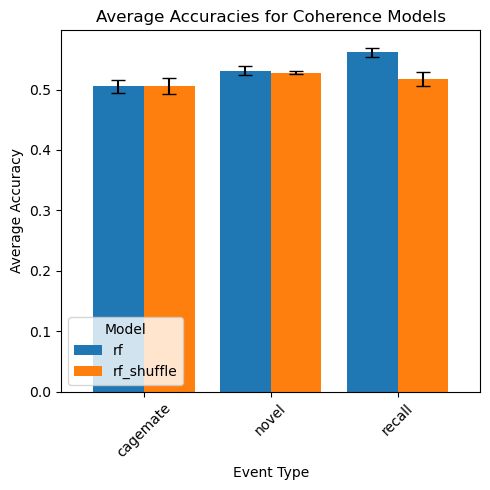

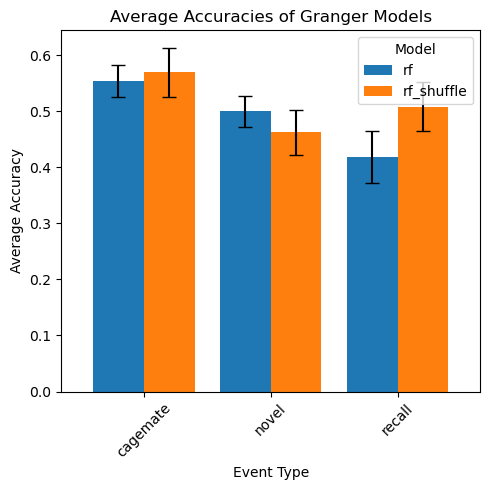

In [22]:
rows = []
for event, models in auc_iter_avg.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Average Accuracies of Power Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

rows = []
for event, models in auc_iter_c_avg.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Average Accuracies for Coherence Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

rows = []
for event, models in g_auc.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Average Accuracies of Granger Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

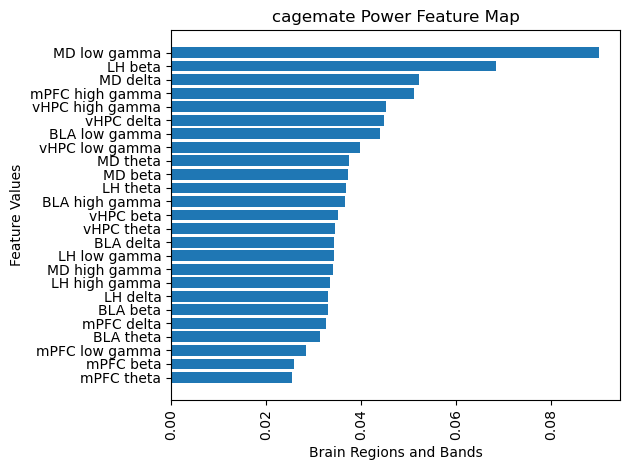

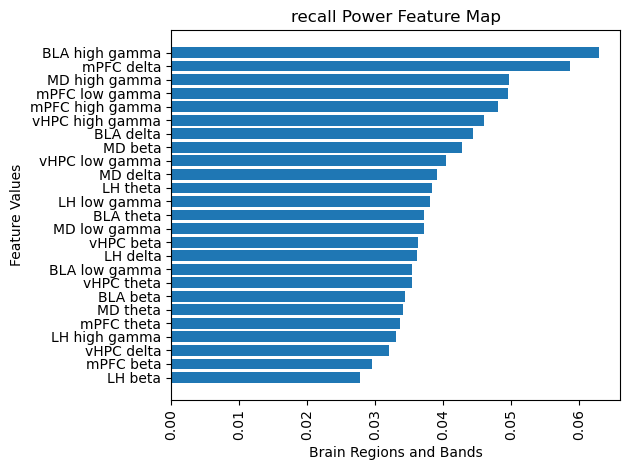

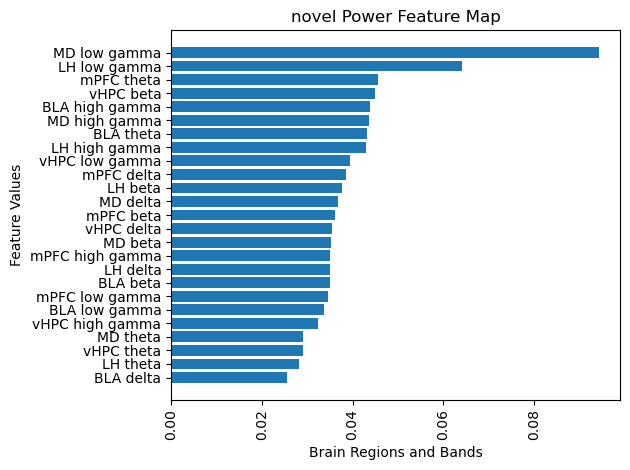

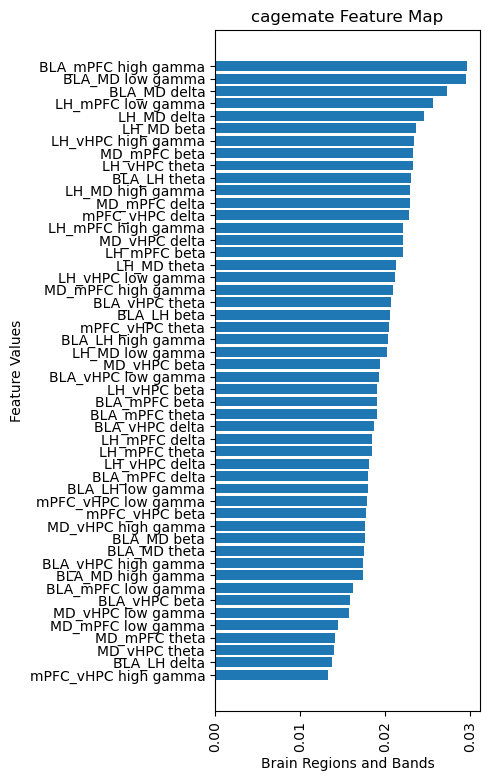

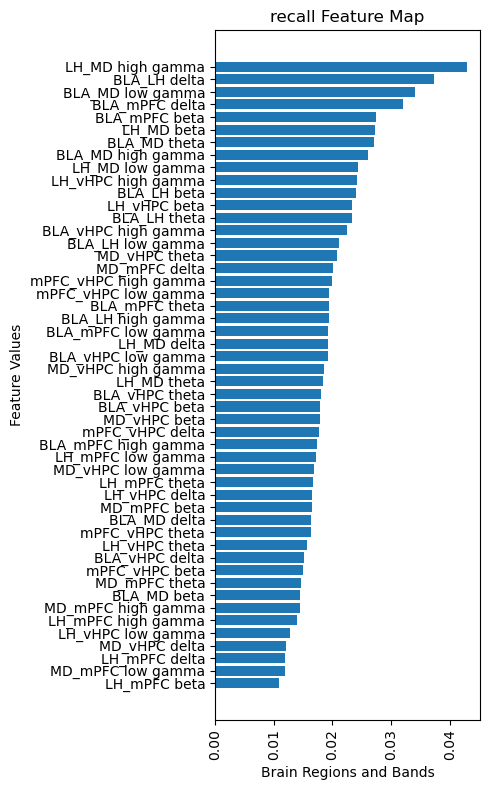

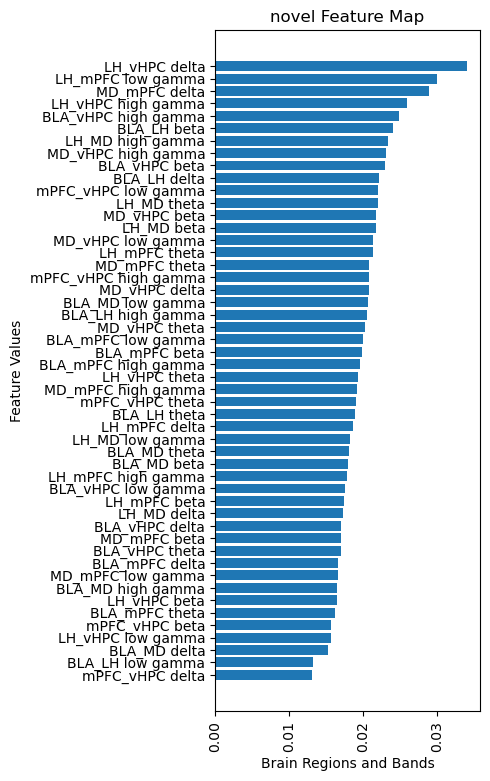

In [ ]:
top_features = []
labels = []
#number of top features per event to take from power
p = 5
#number of top features per event to take from coherence
c = 3
for event in ['cagemate','recall', 'novel']:
    all_models_features = np.array(weights_iter_avg[event]['rf'])
    features = np.mean(all_models_features, axis = 0)
    labels = []
    for band in ['delta', 'theta','beta', 'low gamma', 'high gamma']:
        for region in test_analysis.brain_regions:
            labels.append(f"{region} {band}")
    sorted_indices = np.argsort(features)  # Get indices that would sort the array in descending order
    sorted_features = features[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]
    top_features = top_features + list(sorted_labels[:p])


    fig, ax = plt.subplots()
    ax.barh(range(len(sorted_features)), sorted_features, tick_label=sorted_labels)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.xlabel('Brain Regions and Bands')
    plt.ylabel('Feature Values')
    plt.title(f'{event} Power Feature Map')
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
    plt.show()

labesl = []

for event in ['cagemate','recall', 'novel']:
    all_models_features = np.array(weights_iter_c_avg[event]['rf'])
    features = np.mean(all_models_features, axis = 0)
    labels = []
    for region in test_analysis.coherence_pairs:
        for band in ['delta', 'theta','beta', 'low gamma', 'high gamma']:
            labels.append(f"{region} {band}")
    sorted_indices = np.argsort(features)  # Get indices that would sort the array in descending order
    sorted_features = features[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]
    top_features = top_features + list(sorted_labels[:c])
    fig, ax = plt.subplots(figsize=(5, 8))
    ax.barh(range(len(sorted_features)), sorted_features, tick_label=sorted_labels)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.xlabel('Brain Regions and Bands')
    plt.ylabel('Feature Values')
    plt.title(f'{event} Feature Map')
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
    plt.show()


In [ ]:
print(len(np.unique(top_features)))
print(top_features)

22
['mPFC theta', 'mPFC beta', 'mPFC low gamma', 'BLA theta', 'mPFC delta', 'LH beta', 'mPFC beta', 'vHPC delta', 'LH high gamma', 'mPFC theta', 'BLA delta', 'LH theta', 'vHPC theta', 'MD theta', 'vHPC high gamma', 'mPFC_vHPC high gamma', 'BLA_LH delta', 'MD_vHPC theta', 'LH_mPFC beta', 'MD_mPFC low gamma', 'LH_mPFC delta', 'mPFC_vHPC delta', 'BLA_LH low gamma', 'BLA_MD delta']


In [ ]:

auc_iter_tf, prob_iter_tf, weights_iter_tf = [],[],[]

for i in range(10):
    [tf_auc, tf_prob, tf_weights] = top_feat_trial_decoder(num_fold,
                    num_shuffle,
                    events,
                    model ='rf',
                    top_features = top_features,
                    baseline = baseline,
                    event_len = None,
                    pre_window = 0,
                    post_window = 0)
    
    auc_iter_tf.append(tf_auc)
    prob_iter_tf.append(tf_prob)
    weights_iter_tf.append(tf_weights)

auc_iter_tf_avg = average_nested_dict_values(auc_iter_tf)
prob_iter_tf_avg = average_nested_dict_values(prob_iter_tf)
weights_iter_tf_avg = average_nested_dict_values(weights_iter_tf)

20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270


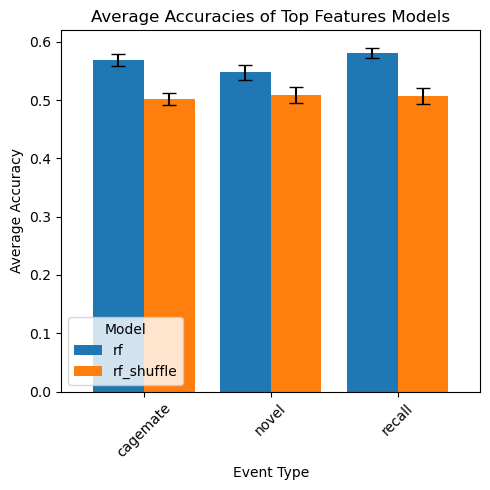

In [ ]:
rows = []
for event, models in auc_iter_tf_avg.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Average Accuracies of Top Features Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [ ]:
print(sorted(top_features))



['BLA delta', 'BLA theta', 'BLA_LH delta', 'BLA_LH low gamma', 'LH beta', 'LH high gamma', 'LH theta', 'LH_mPFC beta', 'MD theta', 'MD_mPFC low gamma', 'mPFC beta', 'mPFC beta', 'mPFC delta', 'mPFC low gamma', 'mPFC theta', 'mPFC theta', 'mPFC_vHPC delta', 'mPFC_vHPC high gamma', 'vHPC delta', 'vHPC high gamma', 'vHPC theta']


In [ ]:
set2 = set(['LH beta', 'LH low gamma', 'LH low gamma', 'LH low gamma', 'LH theta', 'LH theta', 'LH theta', 'LH_MD delta', 'LH_mPFC beta', 'MD delta', 'MD high gamma', 'MD low gamma', 'MD_mPFC beta', 'MD_mPFC low gamma', 'mPFC beta', 'mPFC beta', 'mPFC high gamma', 'mPFC_vHPC beta', 'mPFC_vHPC beta', 'vHPC low gamma', 'vHPC theta'])

set1 = set(top_features)

shared_top_features = set1.intersection(set2)

In [ ]:
shared_top_features

{'LH beta',
 'LH theta',
 'LH_mPFC beta',
 'MD_mPFC low gamma',
 'mPFC beta',
 'vHPC theta'}

In [ ]:
auc_iter_af, prob_iter_af, weights_iter_af = [],[],[]

for i in range(10):
    [af_auc, af_prob, af_weights] = top_feat_trial_decoder(num_fold,
                    num_shuffle,
                    events,
                    model ='rf',
                    top_features = None,
                    baseline = baseline,
                    event_len = None,
                    pre_window = 0,
                    post_window = 0)
    
    auc_iter_af.append(af_auc)
    prob_iter_af.append(af_prob)
    weights_iter_af.append(af_weights)

auc_iter_af_avg = average_nested_dict_values(auc_iter_af)
prob_iter_af_avg = average_nested_dict_values(prob_iter_af)
weights_iter_af_avg = average_nested_dict_values(weights_iter_af)

20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec recall
20230803_121318_1_merged.rec recall
20230803_141047_1_merged.rec recall
20230817_100823_1_merged.rec iti_events
20230803_101331_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230804_141009_1_merged.rec cagemate
20230817_100823_1_merged.rec iti_events
20230818_133620_1_merged.rec cagemate
20230803_121318_1_merged.rec novel
20230803_121318_1_merged.rec novel
20230804_141009_1_merged.rec novel
20230817_100823_1_merged.rec novel
20230817_100823_1_merged.rec iti_events
20230817_113746_1_merged.rec novel
20230803_101331_1_merged.rec r

C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


270
270


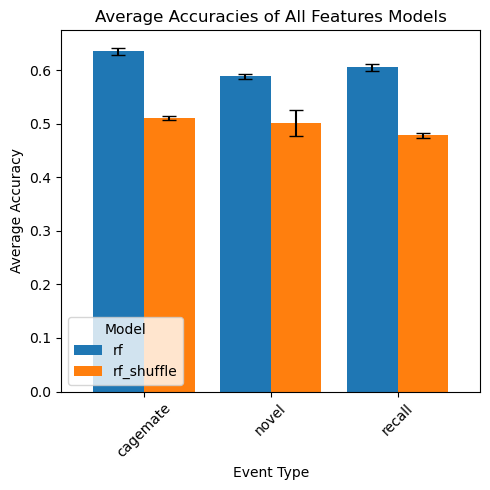

In [ ]:
rows = []
for event, models in auc_iter_af_avg.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Average Accuracies of All Features Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [28]:
f = 1
for event in ['cagemate','recall', 'novel']:
    # all_models_features = np.array(weights_iter_af_avg[event]['rf'])
    # features = np.mean(all_models_features, axis = 0)
    labels = []
    for band in ['delta', 'theta','beta', 'low gamma', 'high gamma']:
        for region in test_analysis.brain_regions:
            labels.append(f"{region} {band}")
    for band in ['delta', 'theta','beta', 'low gamma', 'high gamma']:
        for region in test_analysis.coherence_pairs:
            labels.append(f"{region} {band}")
    # sorted_indices = np.argsort(features)  # Get indices that would sort the array in descending order
    # sorted_features = features[sorted_indices]
    # sorted_labels = np.array(labels)[sorted_indices]
    # top_features = top_features + list(sorted_labels[:f])

# set_cagemate = set(top_features[:10])
# set_familiar= set(top_features[10:20])
# set_novel = set(top_features[20:30])

# set_fam = set_cagemate.intersection(set_familiar)
# set_fam

In [ ]:
set_less = set_novel.intersection(set_familiar)
set_less

set()

In [ ]:
set_ex = set_cagemate.intersection(set_novel)
set_ex

{'mPFC low gamma'}

In [ ]:
set_constrained = set(['LH low gamma', 'mPFC beta', 'MD low gamma', 'vHPC low gamma', 'LH theta', 'mPFC high gamma', 'mPFC beta', 'MD high gamma', 'LH theta', 'LH low gamma', 'MD delta', 'vHPC theta', 'LH beta', 'LH theta', 'LH low gamma', 'MD_mPFC low gamma', 'mPFC_vHPC beta', 'mPFC_vHPC high gamma', 'LH_MD delta', 'mPFC_vHPC beta', 'MD_mPFC theta', 'MD_mPFC beta', 'LH_mPFC beta', 'MD_mPFC high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'BLA_LH low gamma', 'BLA_vHPC low gamma', 'vHPC high gamma', 'LH low gamma', 'BLA_mPFC beta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_vHPC delta', 'MD_mPFC theta', 'mPFC high gamma', 'MD delta', 'vHPC theta', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'LH_vHPC low gamma', 'mPFC_vHPC delta', 'MD_vHPC low gamma', 'BLA_LH theta', 'MD beta', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'BLA_LH low gamma', 'BLA_vHPC low gamma', 'vHPC high gamma', 'LH low gamma', 'BLA_mPFC beta', 'BLA delta', 'LH_mPFC high gamma', 'MD low gamma', 'BLA_MD beta', 'MD_mPFC low gamma', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_vHPC delta', 'MD_mPFC theta', 'mPFC high gamma', 'MD delta', 'vHPC theta', 'LH_MD low gamma', 'LH low gamma', 'LH delta', 'vHPC high gamma', 'mPFC_vHPC low gamma', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'LH_vHPC low gamma', 'mPFC_vHPC delta', 'MD_vHPC low gamma', 'BLA_LH theta', 'MD beta', 'LH low gamma', 'vHPC beta', 'MD_mPFC beta', 'vHPC theta', 'vHPC high gamma', 'mPFC_vHPC high gamma', 'BLA_vHPC beta', 'mPFC beta', 'BLA_vHPC high gamma', 'mPFC_vHPC delta', 'BLA_LH low gamma', 'BLA_vHPC low gamma', 'vHPC high gamma', 'LH low gamma', 'BLA_mPFC beta', 'LH_MD delta', 'mPFC beta', 'LH_vHPC low gamma', 'vHPC beta', 'mPFC_vHPC high gamma', 'LH_vHPC delta', 'MD_mPFC theta', 'mPFC high gamma', 'MD delta', 'vHPC theta', 'LH_mPFC low gamma', 'LH high gamma', 'LH beta', 'LH_mPFC high gamma', 'MD high gamma', 'LH_vHPC low gamma', 'mPFC_vHPC delta', 'MD_vHPC low gamma', 'BLA_LH theta', 'MD beta'])

set_freely_moving = set(np.unique(top_features))

top_top = set_constrained.intersection(set_freely_moving)
top_top

{'BLA delta',
 'BLA_LH low gamma',
 'BLA_vHPC low gamma',
 'LH beta',
 'LH high gamma',
 'LH low gamma',
 'LH theta',
 'LH_mPFC beta',
 'LH_mPFC high gamma',
 'LH_vHPC low gamma',
 'MD_mPFC beta',
 'MD_mPFC high gamma',
 'MD_mPFC low gamma',
 'MD_mPFC theta',
 'MD_vHPC low gamma',
 'mPFC beta',
 'mPFC high gamma',
 'mPFC_vHPC delta',
 'mPFC_vHPC high gamma',
 'mPFC_vHPC low gamma',
 'vHPC high gamma',
 'vHPC theta'}

In [194]:
def calc_top_feat_trial(num_fold,
                  num_features,
                  events,
                  model,
                  baseline = None,
                  event_len = None,
                  pre_window = 0,
                  post_window = 0):
    power_data = decoder_analysis.average_events(events = events,
                                        mode = 'power',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    coherence_data = decoder_analysis.average_events(events = events,
                                        mode = 'coherence',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    #for not granger: data = [trials, brain regions/pairs, frequencies]
    #for granger: data = [trials, brain region, brain region, freqeuncies]
    [power_agent_band_dict, power_band_agent_dict] = band_calcs(power_data)
    [coherence_agent_band_dict, coherence_band_agent_dict] = band_calcs(coherence_data)
    #decoder data = [trials, ...] for each band
    decoder_data = {}
    for event in events: 
        p_band_dict = power_agent_band_dict[event]
        c_band_dict = coherence_agent_band_dict[event]
        p_stacked_bands = np.stack(list(p_band_dict.values()), axis = 0)
        c_stacked_bands = np.stack(list(c_band_dict.values()), axis = 0)
        #stacked bands = [band, trials, ...]
        p_reshaped_bands = np.transpose(p_stacked_bands, (1,0,2))
        c_reshaped_bands = np.transpose(c_stacked_bands, (1,0,2))
        p_bands = p_reshaped_bands.reshape(p_reshaped_bands.shape[0], -1)
        c_bands = c_reshaped_bands.reshape(c_reshaped_bands.shape[0], -1)
        pc_bands = np.concatenate([p_bands, c_bands], axis = 1)
        decoder_data[event] = pc_bands
    features = {}
    for event in events:
        data_neg = []
        data_pos = []
        for trial in range(decoder_data[event].shape[0]):
            trial_data = decoder_data[event][trial,...]
            #if np.sum(np.isnan(trial_data)) == 0:
            data_pos.append(trial_data)
        for neg_event in np.setdiff1d(events, event):
            for trial in range(decoder_data[neg_event].shape[0]):
                trial_data = decoder_data[neg_event][trial,...]
            #    if np.sum(np.isnan(trial_data)) == 0:
                data_neg.append(trial_data)
        data_pos = np.stack(data_pos)
        #data_pos = trials x features
        data_neg = np.stack(data_neg)
        num_pos = data_pos.shape[0]
        num_neg = data_neg.shape[0]
        data_pos = data_pos[np.random.permutation(num_pos), :]
        data_neg = data_neg[np.random.permutation(num_neg), :]
        model_keys = {'glm': ['glm', 'glm_shuffle'],
                    'rf': ['rf', 'rf_shuffle'],
                    'both': ['glm', 'rf', 'glm_shuffle',
                             'rf_shuffle']}
        auc[event] = {key: [] for key in model_keys[model]}
        prob[event] = {key: [] for key in model_keys[model]}
        weights[event] = {key: [] for key in model_keys[model]}
        feature_indices = []
        for feat in range(num_features):
            all_auc_rf = []
            feats_tested = []
            for i in range(data_pos.shape[1]):
                temp_indices = feature_indices.copy()
                feat_auc_rf = []
                if i not in feature_indices: 
                    temp_indices.append(i)
                    for fold in range(num_fold):
                        data_test, label_test, data_train, label_train = __train_test_split__(fold,
                                                                                                num_fold,
                                                                                                data_pos,
                                                                                                data_neg,
                                                                                                num_pos,
                                                                                                num_neg)
                        data_test = data_test[:,temp_indices]
                        data_train = data_train[:,temp_indices]
                        pred_glm, weight_glm, pred_rf, feat_imp_rf = __run_model__(model,
                                                        data_train,
                                                        data_test,
                                                        label_train)
                        if (model == 'rf') | (model == 'both'):
                            auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                            feat_auc_rf.append(auc_rf)
                    feat_auc_rf = np.nanmean(np.array(feat_auc_rf))
                    all_auc_rf.append(feat_auc_rf)
                    feats_tested.append(i)
            max_index = np.argmax(np.array(all_auc_rf))
            feature_indices.append(feats_tested[max_index])
        features[event] = feature_indices   
    return features

feature_indices = calc_top_feat_trial(5, 10, ['cagemate', 'recall','novel'], 'rf', baseline = None)

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


In [196]:
labels = np.array(labels)
event_features = {}
feature_sets = []
for event in feature_indices.keys():
    print(event)
    event_features[event] = labels[feature_indices[event]]
    event_set = set(labels[feature_indices[event]])
    feature_sets.append(event_set)
print(event_features['cagemate'])

['mPFC low gamma' 'MD_mPFC low gamma' 'LH_vHPC low gamma' 'vHPC delta'
 'BLA_MD high gamma' 'vHPC theta' 'BLA high gamma' 'MD beta'
 'mPFC high gamma' 'mPFC_vHPC low gamma']
cagemate


IndexError: index 56 is out of bounds for axis 0 with size 10

In [158]:
print(event_features['novel'])
print(event_features['recall'])


['mPFC low gamma' 'MD_mPFC low gamma' 'LH_vHPC low gamma' 'vHPC delta'
 'BLA_MD high gamma' 'vHPC theta' 'BLA high gamma' 'MD beta'
 'mPFC high gamma' 'mPFC_vHPC low gamma']
['MD_mPFC beta' 'LH_MD beta' 'BLA_MD delta' 'LH low gamma' 'MD_vHPC beta'
 'MD_vHPC high gamma' 'LH theta' 'MD delta' 'LH_vHPC low gamma'
 'MD low gamma']


In [159]:
print(feature_sets[0].intersection(feature_sets[1]))
print(feature_sets[0].intersection(feature_sets[2]))
print(feature_sets[1].intersection(feature_sets[2]))
#cage & fam
#cage & nov
#nov & fam

{'MD_mPFC beta'}
{'MD beta', 'mPFC low gamma'}
{'LH_vHPC low gamma'}


In [160]:
constrained_novel = set(['BLA_LH theta', 'vHPC theta', 'MD beta', 'mPFC_vHPC beta', 'MD delta', 'BLA_MD beta', 'LH_vHPC low gamma', 'LH_vHPC beta', 'mPFC high gamma', 'LH_mPFC high gamma'])

constrained_fam = set(['mPFC delta', 'MD_vHPC beta', 'BLA_MD low gamma', 'BLA_LH theta', 'LH beta', 'LH_mPFC theta', 'LH delta', 'BLA high gamma', 'BLA_vHPC low gamma', 'BLA_LH low gamma'])
constrained_cagemate = set(['BLA_MD beta', 'BLA_vHPC theta', 'mPFC delta', 'BLA_MD low gamma', 'LH_MD theta', 'BLA_mPFC theta', 'LH_vHPC high gamma', 'BLA_vHPC beta', 'MD theta', 'BLA_mPFC beta'])
print(feature_sets[0].intersection(constrained_cagemate))
print(feature_sets[1].intersection(constrained_fam))
print(feature_sets[2].intersection(constrained_novel))

{'MD theta'}
{'MD_vHPC beta'}
{'mPFC high gamma', 'vHPC theta', 'MD beta', 'LH_vHPC low gamma'}


In [193]:
decoder_recordings = []
keys_to_retain = ['recall', 'cagemate', 'novel']
#phase3_lfp = unpickle_this("phase3_lfp.pkl")
for recording in test_analysis.collection:
    if (recording.merged_rec == '20230804_141009_1_merged.rec') | (recording.merged_rec == '20230803_141047_1_merged.rec'):
        pass
    else:
        original_dict = recording.event_dict 
        trimmed_dict = {key: original_dict[key] for key in keys_to_retain if key in original_dict}
        recording.event_dict = trimmed_dict
        decoder_recordings.append(recording)

for recording in phase3_lfp.collection:
    if (recording.merged_rec == '20230811_120331_1_merged.rec') | (recording.merged_rec == '20230810_120856_1_merged.rec'):
        pass
    else:
        original_dict = recording.event_dict 
        #original_dict['recall'] = original_dict.pop('familiar')
        trimmed_dict = {key: original_dict[key] for key in keys_to_retain if key in original_dict}
        recording.event_dict = trimmed_dict
        decoder_recordings.append(recording)

decoder_analysis = LFPAnalysis(decoder_recordings)

All set to analyze


In [ ]:
def top_feat_dict_decoder(num_fold,
                  num_shuffle,
                  events,
                  model,
                  top_features,
                  baseline = None,
                  event_len = None,
                  pre_window = 0,
                  post_window = 0):
    power_data = decoder_analysis.average_events(events = events,
                                        mode = 'power',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    coherence_data = decoder_analysis.average_events(events = events,
                                        mode = 'coherence',
                                        baseline = baseline,
                                        event_len = event_len,
                                        pre_window = pre_window,
                                        post_window = post_window,
                                        plot = False)
    #for not granger: data = [trials, brain regions/pairs, frequencies]
    #for granger: data = [trials, brain region, brain region, freqeuncies]
    [power_agent_band_dict, power_band_agent_dict] = band_calcs(power_data)
    [coherence_agent_band_dict, coherence_band_agent_dict] = band_calcs(coherence_data)
    #decoder data = [trials, ...] for each band
    decoder_data = {}
    for event in events: 
        p_band_dict = power_agent_band_dict[event]
        c_band_dict = coherence_agent_band_dict[event]
        p_stacked_bands = np.stack(list(p_band_dict.values()), axis = 0)
        c_stacked_bands = np.stack(list(c_band_dict.values()), axis = 0)
        #stacked bands = [band, trials, ...]
        p_reshaped_bands = np.transpose(p_stacked_bands, (1,0,2))
        c_reshaped_bands = np.transpose(c_stacked_bands, (1,0,2))
        p_bands = p_reshaped_bands.reshape(p_reshaped_bands.shape[0], -1)
        c_bands = c_reshaped_bands.reshape(c_reshaped_bands.shape[0], -1)
        p_bands = p_reshaped_bands.reshape(p_reshaped_bands.shape[0], -1)
        c_bands = c_reshaped_bands.reshape(c_reshaped_bands.shape[0], -1)
        pc_bands = np.concatenate([p_bands, c_bands], axis = 1)
        decoder_data[event] = pc_bands
    auc = {}
    prob = {}
    weights = {}
    for event in events:
        features = top_features[event]
        data_neg = []
        data_pos = []
        for trial in range(decoder_data[event].shape[0]):
            trial_data = decoder_data[event][trial,features]
            #if np.sum(np.isnan(trial_data)) == 0:
            data_pos.append(trial_data)
        for neg_event in np.setdiff1d(events, event):
            for trial in range(decoder_data[neg_event].shape[0]):
                trial_data = decoder_data[neg_event][trial,features]
            #    if np.sum(np.isnan(trial_data)) == 0:
                data_neg.append(trial_data)
        data_pos = np.stack(data_pos)
        #data_pos = trials x features
        data_neg = np.stack(data_neg)
        num_pos = data_pos.shape[0]
        num_neg = data_neg.shape[0]
        print(num_pos + num_neg)
        data_pos = data_pos[np.random.permutation(num_pos), :]
        data_neg = data_neg[np.random.permutation(num_neg), :]
        model_keys = {'glm': ['glm', 'glm_shuffle'],
                    'rf': ['rf', 'rf_shuffle'],
                    'both': ['glm', 'rf', 'glm_shuffle',
                             'rf_shuffle']}
        auc[event] = {key: [] for key in model_keys[model]}
        prob[event] = {key: [] for key in model_keys[model]}
        weights[event] = {key: [] for key in model_keys[model]}
        for fold in range(num_fold):
            data_test, label_test, data_train, label_train = __train_test_split__(fold,
                                                                                    num_fold,
                                                                                    data_pos,
                                                                                    data_neg,
                                                                                    num_pos,
                                                                                    num_neg)
            pred_glm, weight_glm, pred_rf, feat_imp_rf = __run_model__(model,
                                            data_train,
                                            data_test,
                                            label_train)
            if (model == 'glm') | (model == 'both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm'].append(auc_glm)
                prob[event]['glm'].append(pred_glm)
                weights[event]['glm'].append(weight_glm)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf'].append(auc_rf)
                prob[event]['rf'].append(pred_rf) 
                weights[event]['rf'].append(feat_imp_rf)    
        for shuffle in range(num_shuffle):
            label_train = np.random.permutation(label_train)
            pred_glm, weight_glm, pred_rf, feat_imp_rf =  __run_model__(model,
                                                data_train,
                                                data_test,
                                                label_train)
            if (model == 'rf') | (model == 'both'):
                auc_rf = (roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['rf_shuffle'].append(auc_rf)
                prob[event]['rf_shuffle'].append(pred_rf)
                weights[event]['rf_shuffle'].append(feat_imp_rf)
            if (model == 'glm') | (model =='both'):
                auc_glm = (roc_auc_score(label_test, pred_glm[:, 1]))
                auc[event]['glm_shuffle'].append(auc_glm)
                prob[event]['glm_shuffle'].append(pred_glm)
                weights[event]['glm_shuffle'].append(weight_glm)
    return [auc, prob, weights] 


[topfeat_auc, topfeat_prob, topfeat_weights] = top_feat_dict_decoder(5, 5, 
                                                                     ['cagemate', 'recall', 'novel'],
                                                                     'rf', feature_indices,
                                                                     baseline = None)

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


507
507
507


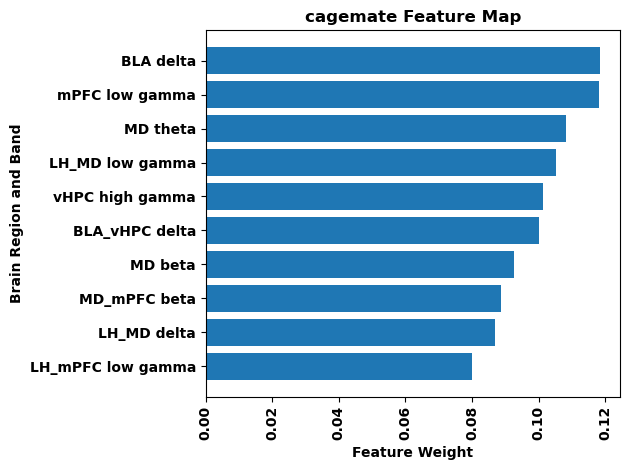

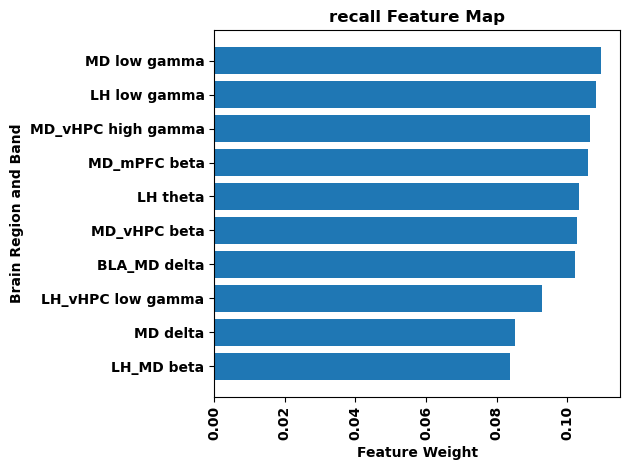

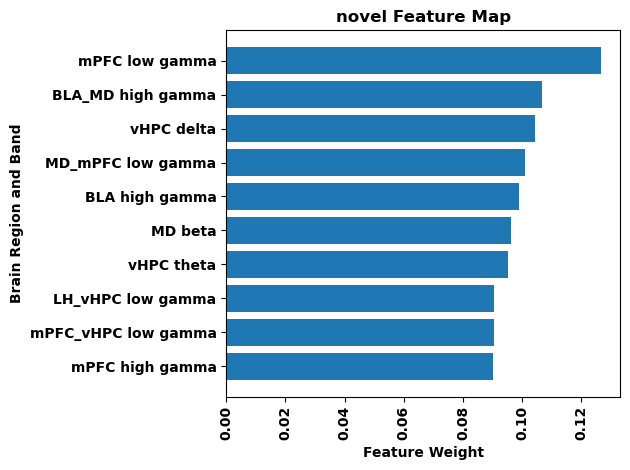

In [ ]:
for event in ['cagemate','recall', 'novel']:
    all_models_features = np.array(topfeat_weights[event]['rf'])
    features = np.mean(all_models_features, axis = 0)
    sorted_indices = np.argsort(features)  # Get indices that would sort the array in descending order
    labels = event_features[event]
    sorted_features = features[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]
    
    fig, ax = plt.subplots()
    ax.barh(range(len(sorted_features)), sorted_features, tick_label=sorted_labels)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.xlabel('Feature Weight')
    plt.ylabel('Brain Region and Band')
    plt.title(f'{event} Feature Map')
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
    plt.show()

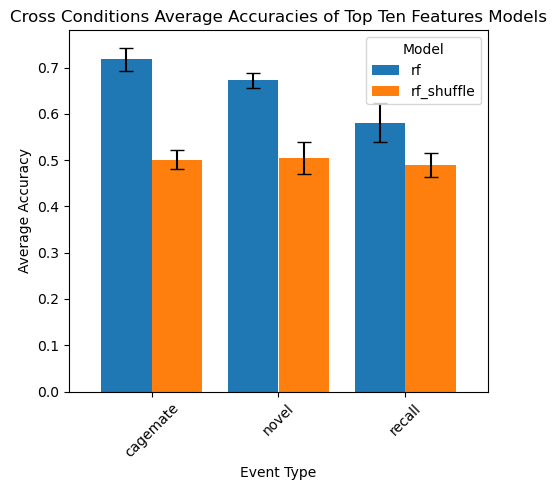

In [ ]:
rows = []
for event, models in topfeat_auc.items():
    for model, accuracies in models.items():
        avg_accuracy = np.mean(accuracies)
        sem_accuracy = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
        rows.append([event, model, avg_accuracy, sem_accuracy])
df = pd.DataFrame(rows, columns=['EventType', 'Model', 'AverageAccuracy', 'SEM'])

df_pivot = df.pivot(index='EventType', columns='Model', values='AverageAccuracy')
sem_pivot = df.pivot(index='EventType', columns='Model', values='SEM')

# Plot
ax = df_pivot.plot(kind='bar', figsize=(5, 5), yerr=sem_pivot, capsize=5, width=0.8)

plt.title('Cross Conditions Average Accuracies of Top Ten Features Models')
plt.xlabel('Event Type')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [170]:
topfeat_auc.keys()
len(topfeat_auc['cagemate']['rf'])

5

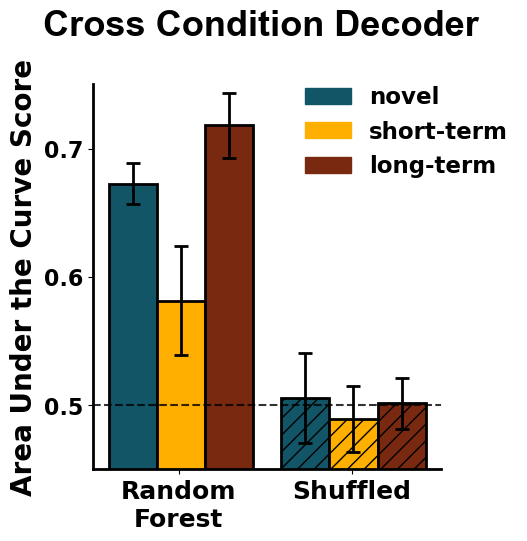

In [ ]:

from matplotlib.patches import Patch 
import matplotlib.ticker as ticker
avg_auc = {}
i = 1
no_plots = len(topfeat_auc.keys())
height_fig = no_plots//2
categories = [ 'novel', 'recall', 'cagemate'] # Example categories
categories_for_legend = [ 'novel', 'short-term', 'long-term']



avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for category in topfeat_auc.keys():
    for key in topfeat_auc[category].keys():
        avg_values[category].append(np.mean(np.array(topfeat_auc[category][key]), axis=0))
        sem_values[category].append(stats.sem(np.array(topfeat_auc[category][key]), axis=0))

bar_width = 0.25 # Width of each bar
x = np.arange(2)  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(4.5, 5))
col = [hex_2_rgb('#115566'),
       hex_2_rgb('#FFAF00'),
       hex_2_rgb('#792910') ]
spacing = [0, -0.1]
edge = ['black','black', 'black', 'black', 'black', 'black']
for i, category in enumerate(categories):
    positions = x + (i+.32) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    hatches = ['','//','','//', '', '//', '', '//', '', '//', '', '//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5,linewidth = 2, 
                error_kw={'elinewidth': 2, 'capthick': 2},
                edgecolor=edge[i],
                alpha=alphas[j],
                label=category if i == 0 else '', color = col[i], hatch=hatches[j])
plt.ylim(0.45, 0.75)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend
# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [Patch(color=col[i], label=categories_for_legend[i]) for i in range(len(col))]
# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16.5, frameon= False, bbox_to_anchor=(0.55,1.05))
#title = '                                           Trained on >99% variance')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
#legend.get_title().set_position((-105, 1))
plt.xticks(x + spacing+0.32, ['Random\nForest','Shuffled'], fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.suptitle('Cross Condition Decoder', fontsize = 26, font = 'Arial', y = 1.03)
plt.subplots_adjust(hspace=0.5)
plt.savefig('LFP_decoder.png', dpi = 600, transparent = True, bbox_inches='tight')

plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:15: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[..., 0:4], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:17: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[..., 4:13], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:19: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[..., 13:31], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:21: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[...,31:71], axis = -1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\4045475496.py:23: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[...,71:100], axis = -1)


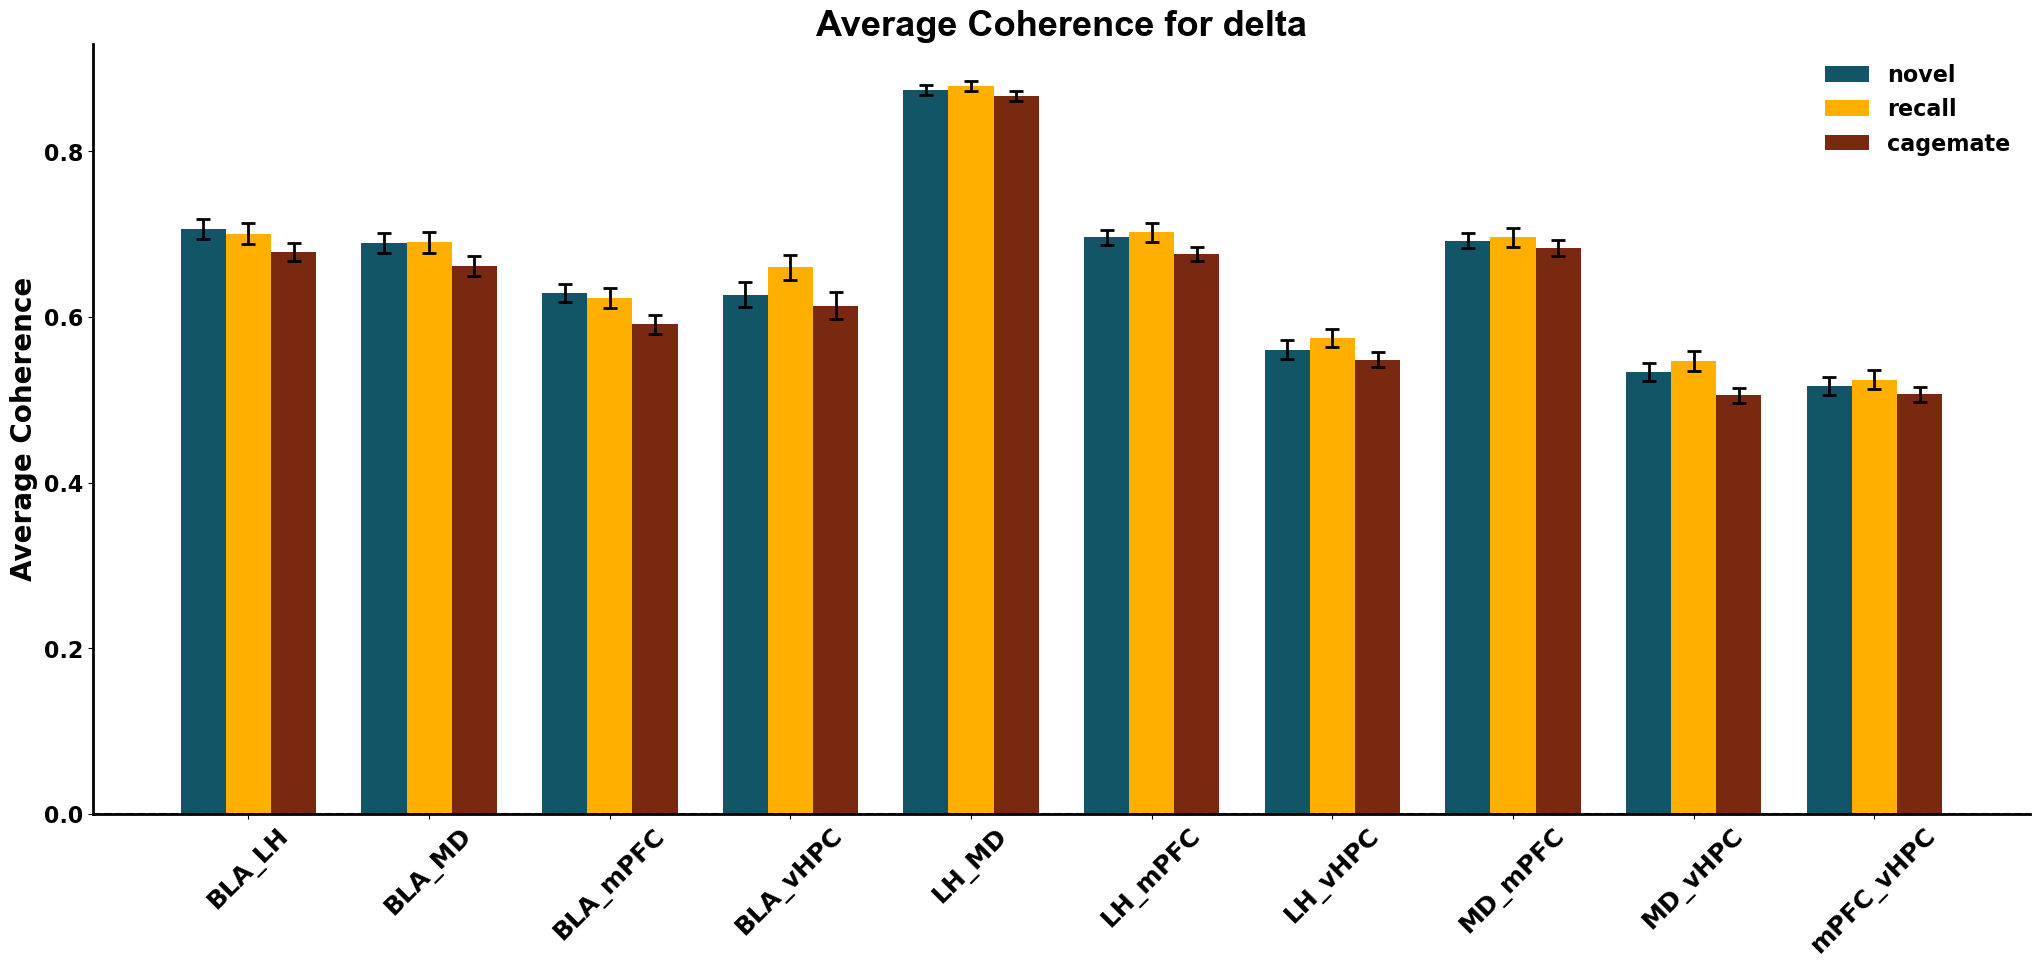

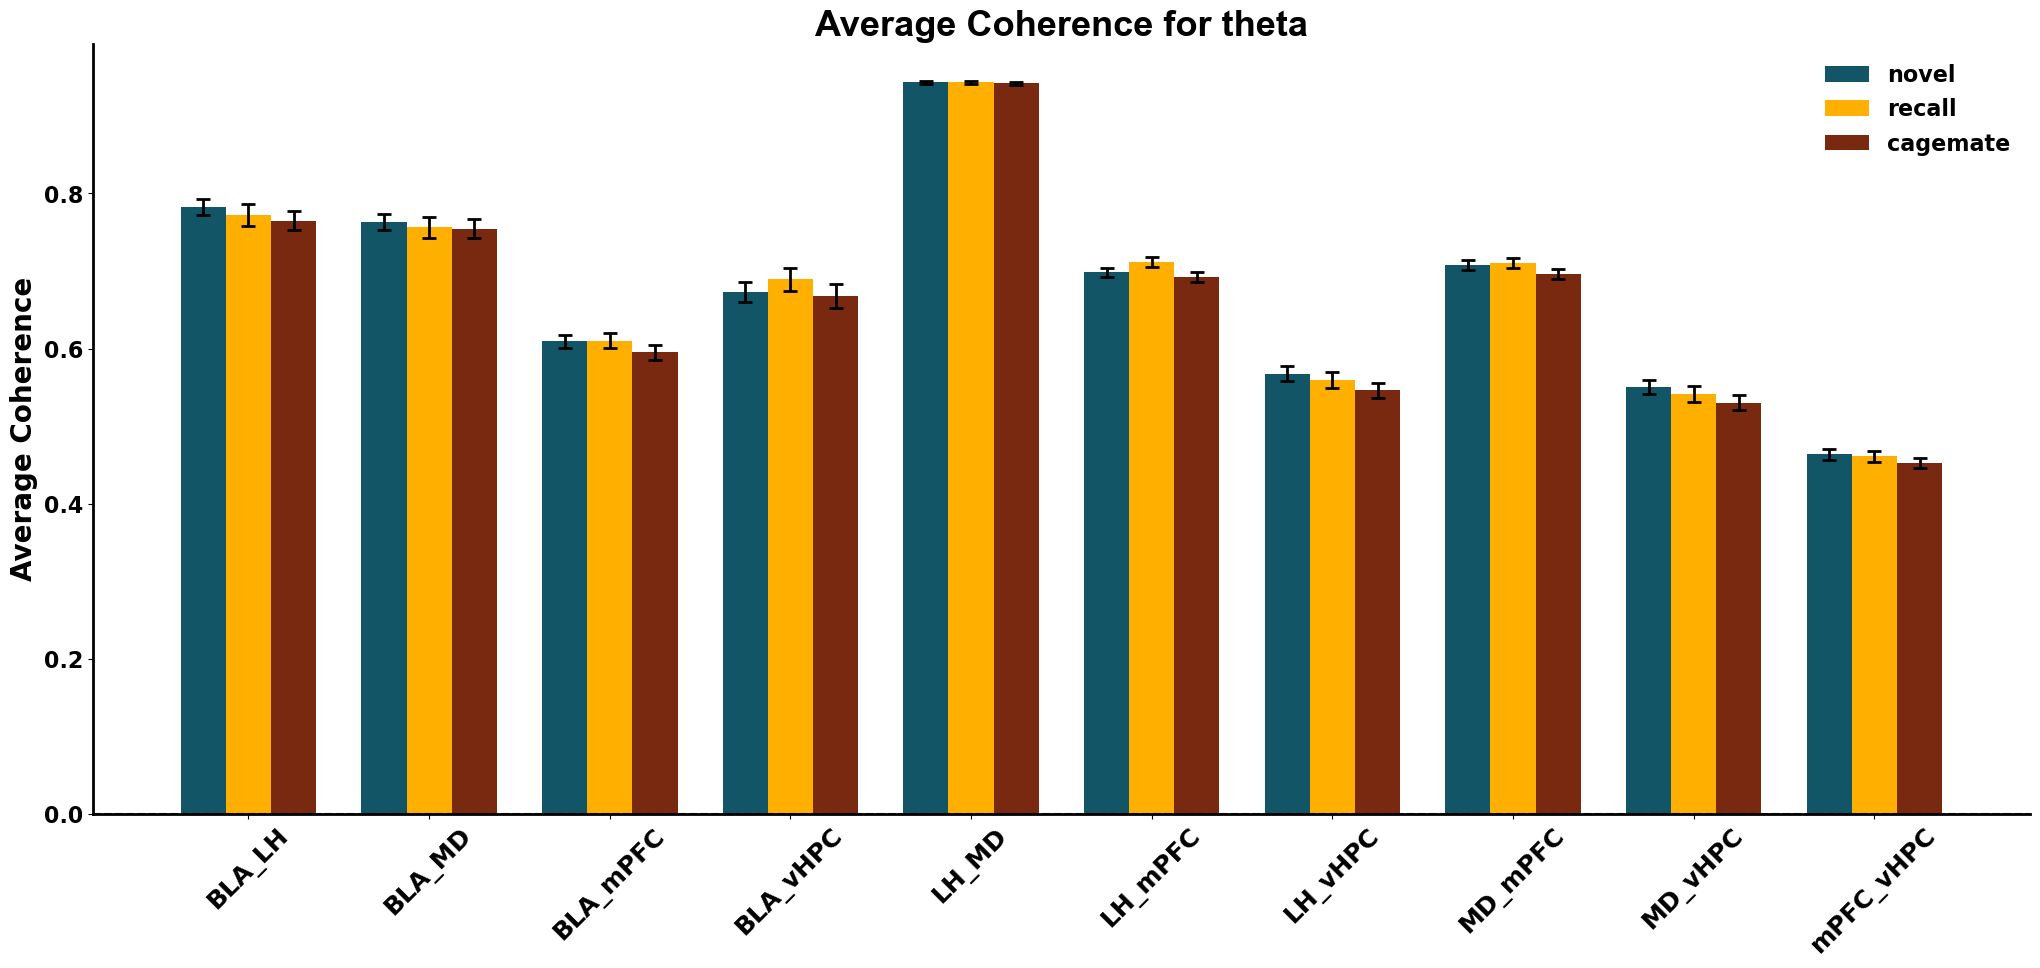

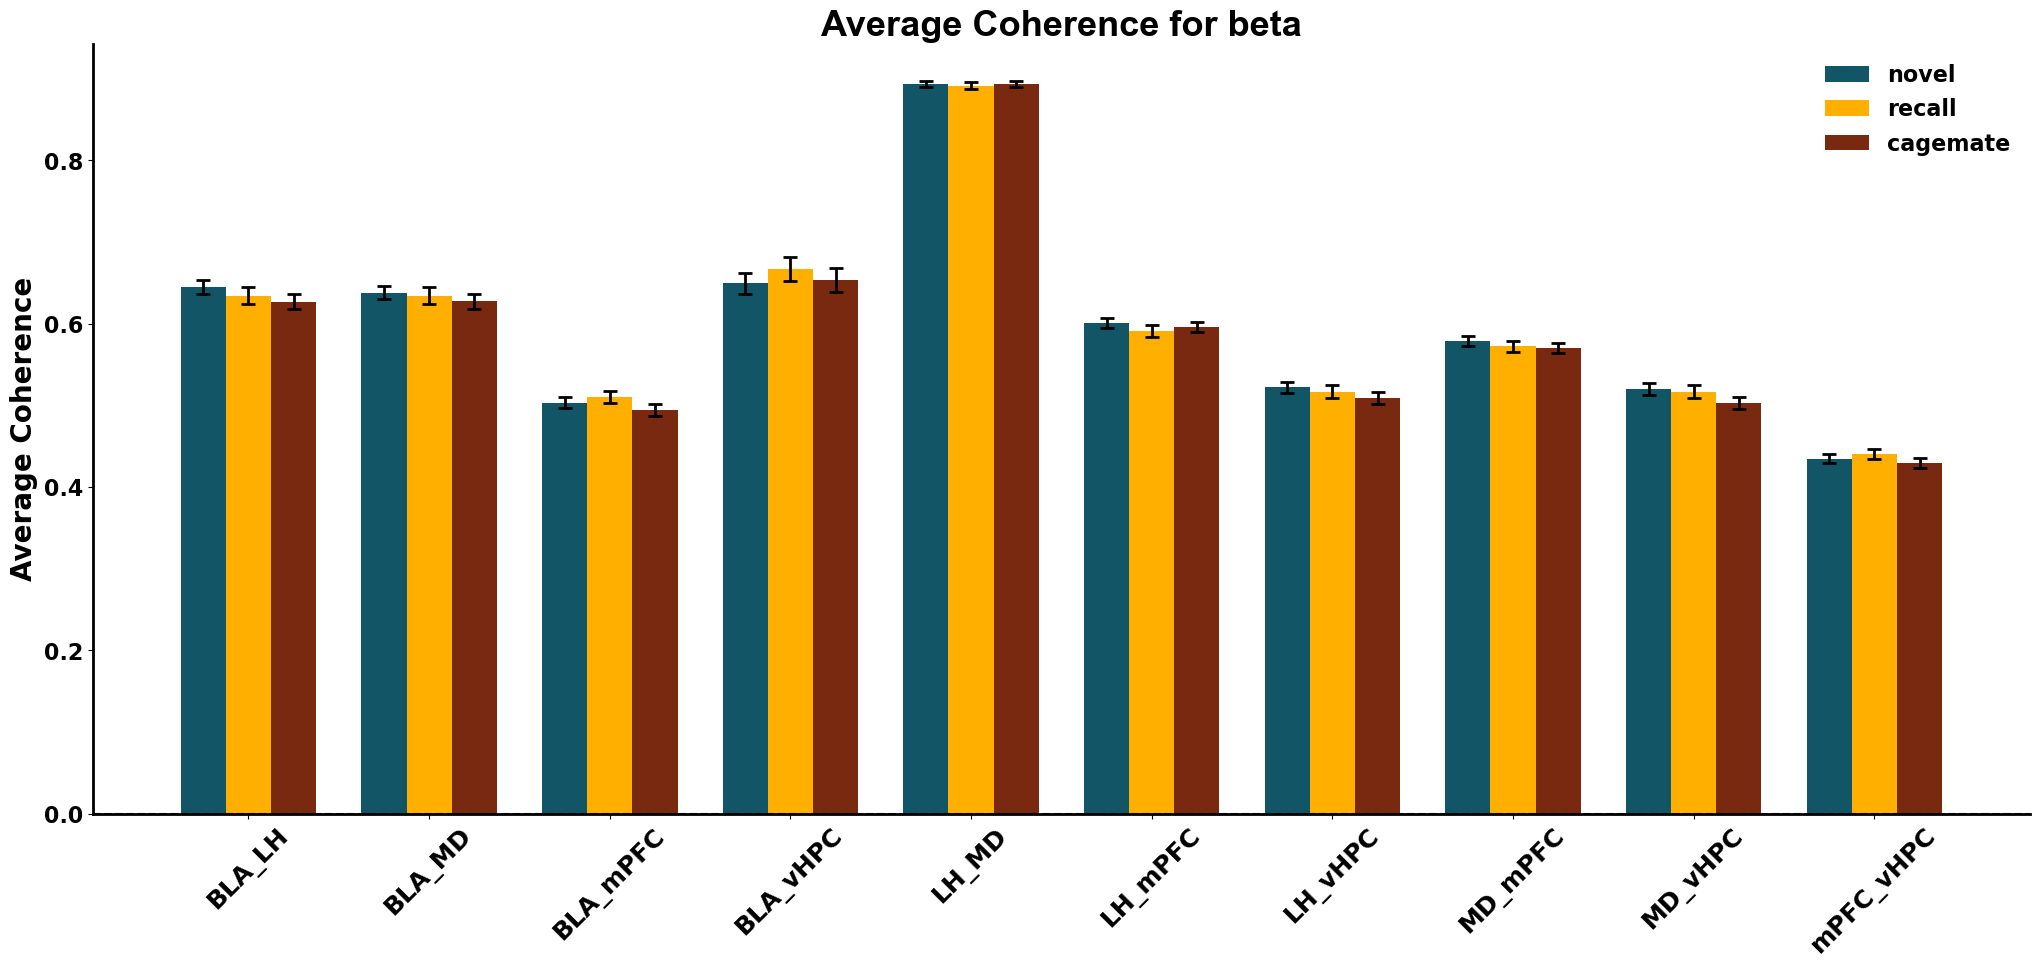

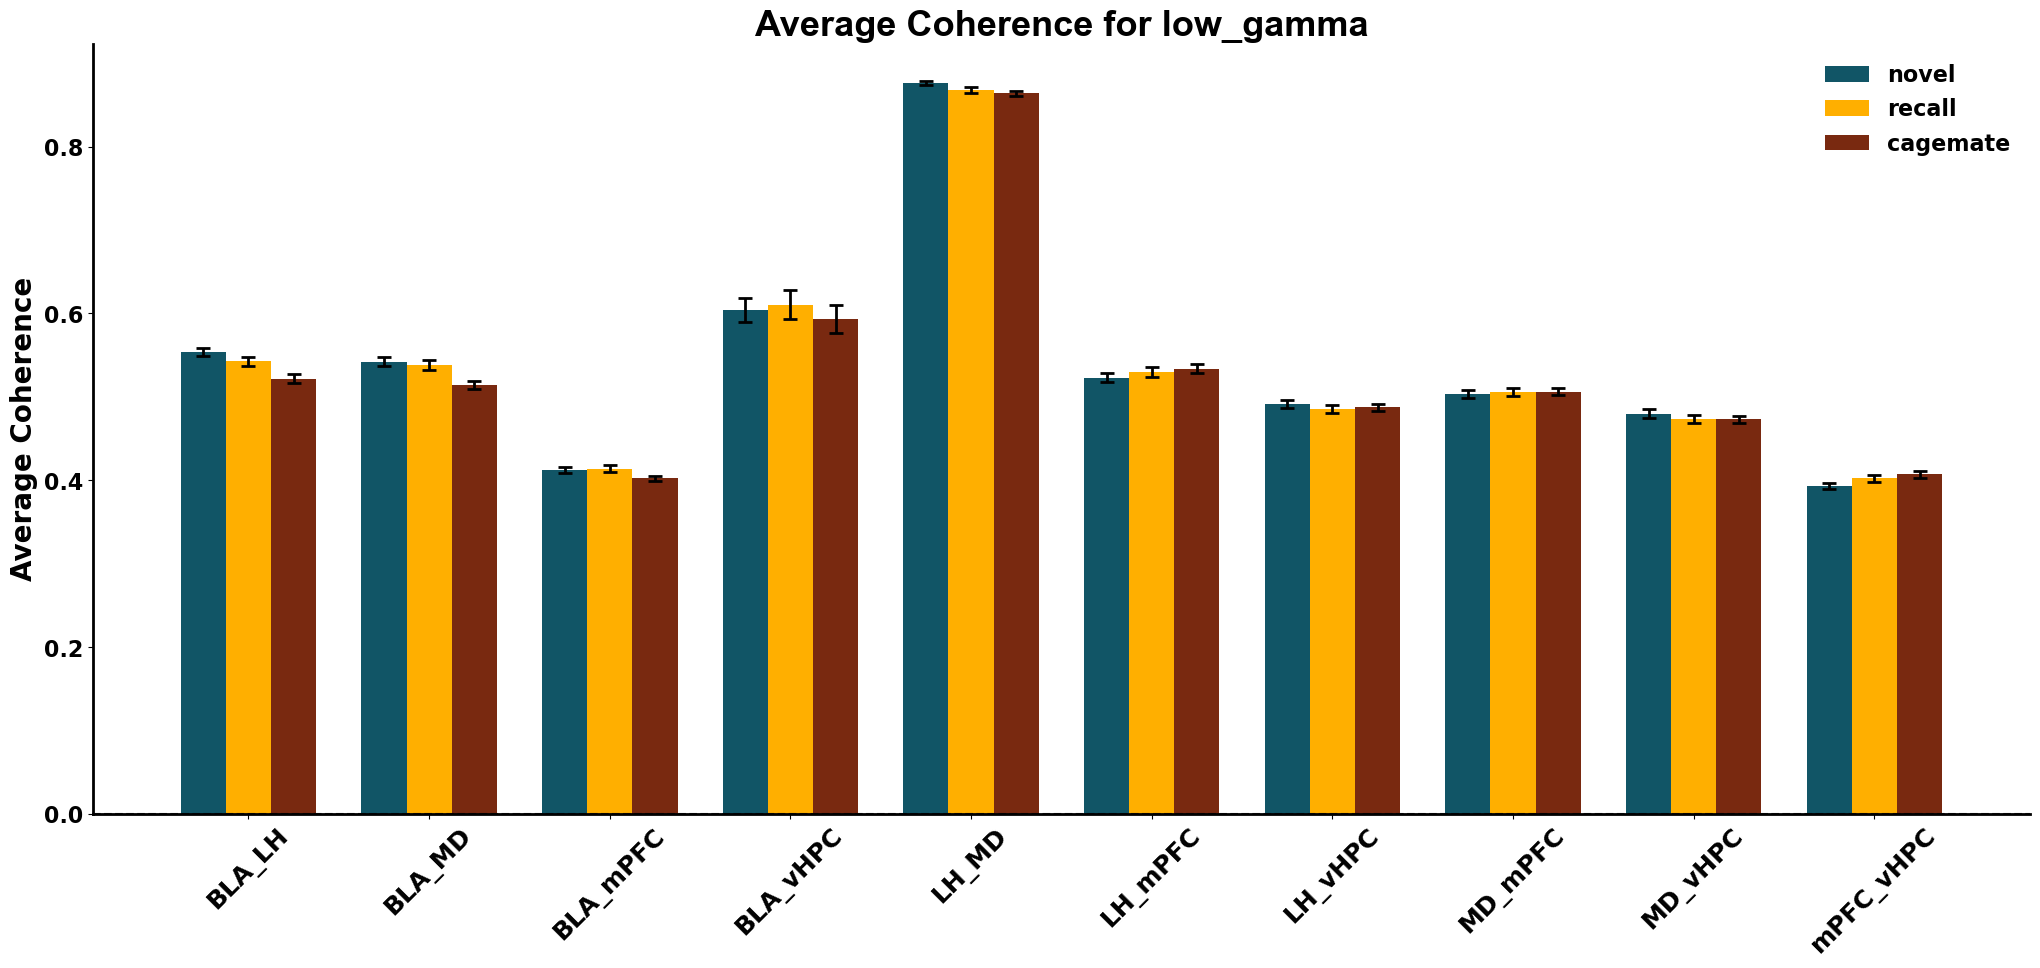

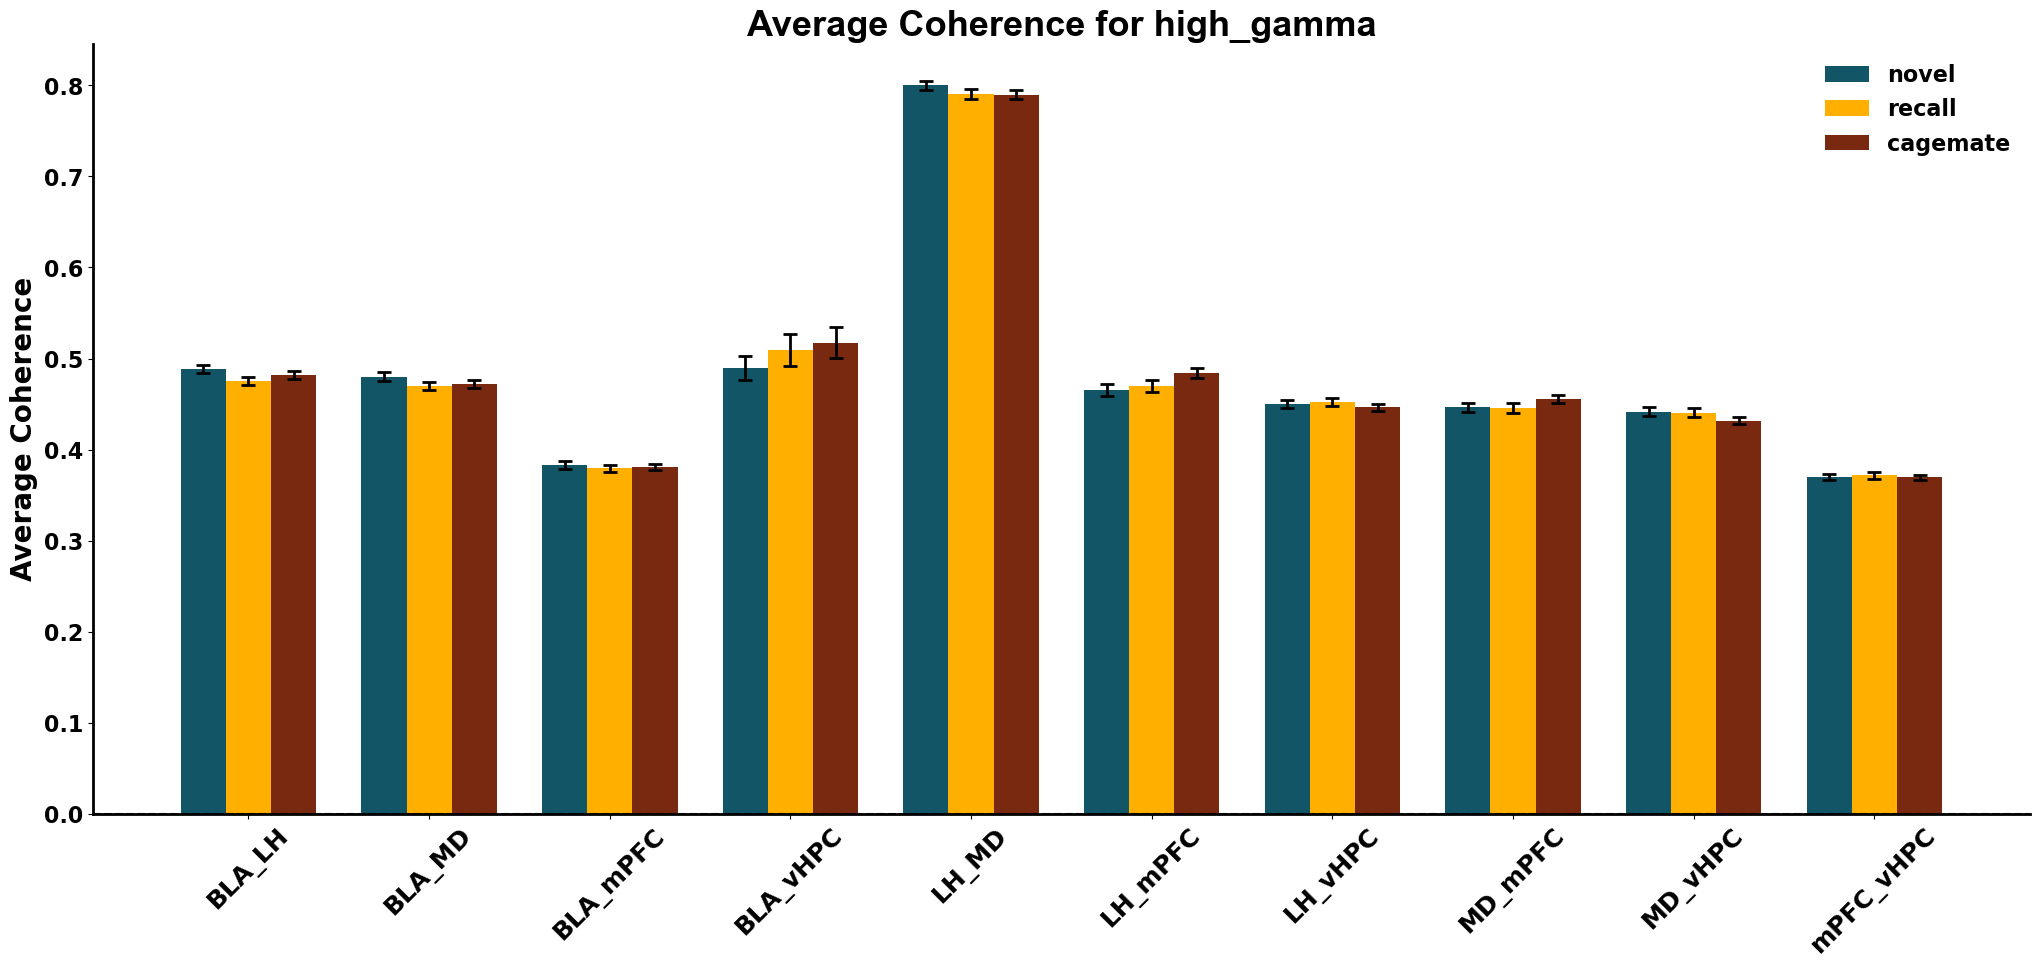

In [190]:
baseline = None
categories = ['novel', 'recall', 'cagemate'] # Example categories
subset_names = [f'{i}' for i in decoder_analysis.coherence_pairs]  # Example subset names

coherences = decoder_analysis.average_events(events = categories, mode = 'coherence', baseline = baseline, plot = False)
[unflipped, flipped] = band_calcs(coherences)
avg_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}
sem_values = {key: {subset: {category: [] for category in categories} for subset in subset_names} for key in flipped.keys()}

for key in flipped.keys():
    for i, subset in enumerate(subset_names):
        for category in categories:
            avg_values[key][subset][category] = np.nanmean(flipped[key][category][:, i])
            sem_values[key][subset][category] = stats.sem(flipped[key][category][:, i], nan_policy='omit')

bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
# Create a separate plot for each key
group_spacing = 1 # Spacing between different subsets


bar_width = 0.25  # Width of each bar
col = [hex_2_rgb('#115566'), hex_2_rgb('#FFAF00'), hex_2_rgb('#792910')]
spacing = 0
edge = ['black'] * 100
group_spacing = 1  # Spacing between different subsets

# Create a separate plot for each key
for key in flipped.keys():
    plt.figure(figsize=(25, 10))
    x = np.arange(len(subset_names)) * group_spacing  # x-axis positions for subsets
    
    for i, subset in enumerate(subset_names):
        for k, category in enumerate(categories):
            positions = x[i] + (k - 1) * (bar_width + spacing)  # Adjust positions for each category
            plt.bar(positions, avg_values[key][subset][category],
                    width=bar_width, yerr=sem_values[key][subset][category],
                    capsize=5,
                    linewidth=2,
                    error_kw={'elinewidth': 2, 'capthick': 2},
                    color=col[k], label=category if i == 0 else '')

    plt.yticks(fontsize=16)
    plt.xticks(x, subset_names, fontsize=18, rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
    plt.ylabel('Average Coherence', fontsize=20)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(f'Average Coherence for {key}', fontsize=26, font='Arial')
    plt.legend(fontsize=16, frameon=False)
    plt.subplots_adjust(hspace=0.5)
    plt.show()


In [35]:
session_coherence = test_analysis.average_events(['cagemate', 'recall', 'novel'],
                                                 mode = 'coherence', 
                                                 baseline = None)

len(session_coherence['cagemate'])

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)


88

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\3482307376.py:15: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)


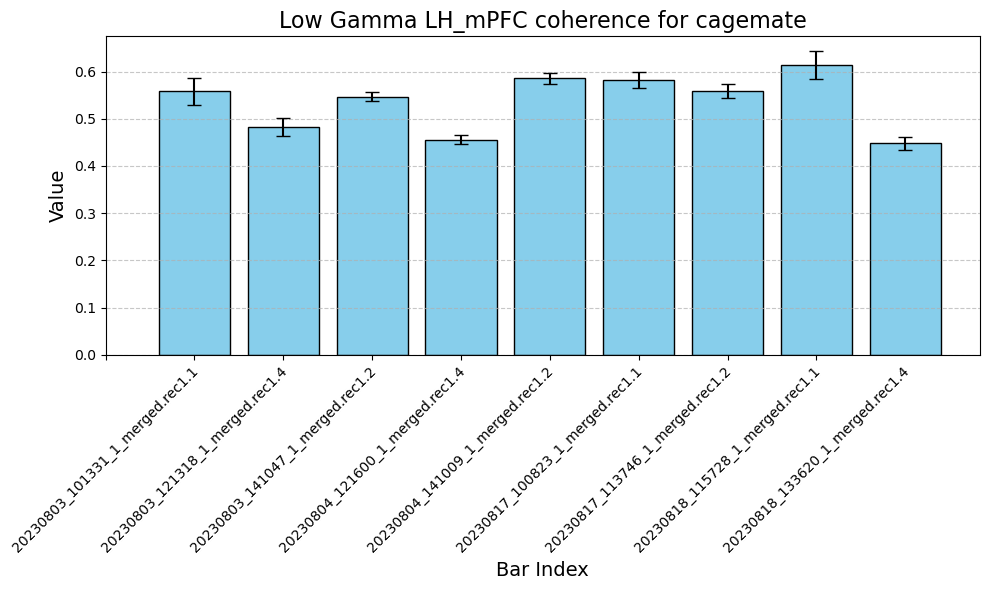

In [36]:
event_averages = []
event_sems = []
pair_index = 5
freq_range = [30,70]
recordings = []
event = 'cagemate'
for recording in test_analysis.collection:
    event_average = test_analysis.__get_event_averages__(recording,
                                                               event = event,
                                                               mode = 'coherence',
                                                               event_len=None,
                                                               pre_window = 0,
                                                               post_window = 0)
    event_array = np.array(event_average)
    event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)
    event_mean = np.nanmean(np.array(event_average[:]), axis = 0)
    event_sem = stats.sem(np.array(event_average), axis = 0, nan_policy='omit')
    event_averages.append(event_mean)
    event_sems.append(event_sem)
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)

num_bars = len(event_averages)
x_positions = np.arange(num_bars)

# Create the bar plot
plt.figure(figsize=(10, 6))


plt.bar(x_positions, event_averages, yerr=event_sems, capsize=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Bar Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Low Gamma LH_mPFC coherence for cagemate', fontsize=16)
plt.xticks(x_positions-1, recordings, rotation=45)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\264871543.py:15: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)


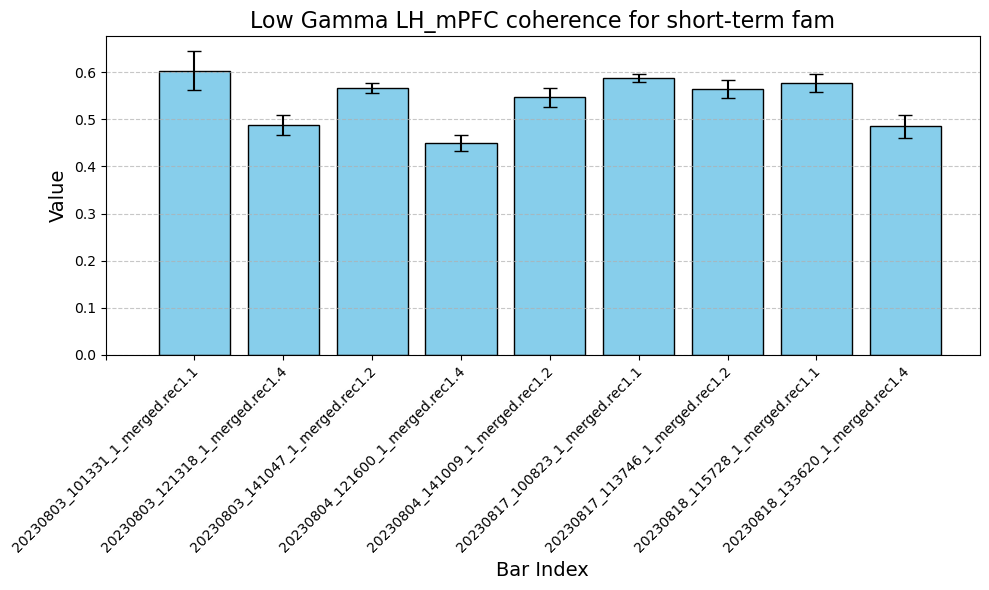

In [37]:
event_averages = []
event_sems = []
pair_index = 5
freq_range = [30,70]
recordings = []
event = 'recall'
for recording in test_analysis.collection:
    event_average = test_analysis.__get_event_averages__(recording,
                                                               event = event,
                                                               mode = 'coherence',
                                                               event_len=None,
                                                               pre_window = 0,
                                                               post_window = 0)
    event_array = np.array(event_average)
    event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)
    event_mean = np.nanmean(np.array(event_average[:]), axis = 0)
    event_sem = stats.sem(np.array(event_average), axis = 0, nan_policy='omit')
    event_averages.append(event_mean)
    event_sems.append(event_sem)
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)

num_bars = len(event_averages)
x_positions = np.arange(num_bars)

# Create the bar plot
plt.figure(figsize=(10, 6))


plt.bar(x_positions, event_averages, yerr=event_sems, capsize=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Bar Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Low Gamma LH_mPFC coherence for short-term fam', fontsize=16)
plt.xticks(x_positions-1, recordings, rotation=45)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\3879375475.py:15: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)


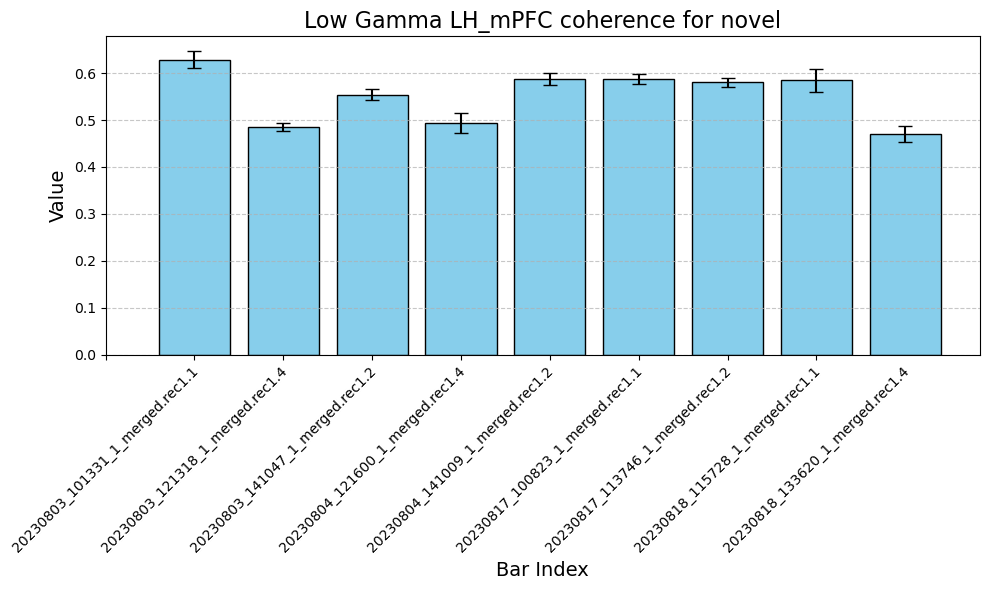

In [38]:
event_averages = []
event_sems = []
pair_index = 5
freq_range = [30,70]
recordings = []
event = 'novel'
for recording in test_analysis.collection:
    event_average = test_analysis.__get_event_averages__(recording,
                                                               event = event,
                                                               mode = 'coherence',
                                                               event_len=None,
                                                               pre_window = 0,
                                                               post_window = 0)
    event_array = np.array(event_average)
    event_average = np.nanmean(event_array[:,pair_index,freq_range[0]:freq_range[1]], axis = 1)
    event_mean = np.nanmean(np.array(event_average[:]), axis = 0)
    event_sem = stats.sem(np.array(event_average), axis = 0, nan_policy='omit')
    event_averages.append(event_mean)
    event_sems.append(event_sem)
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)

num_bars = len(event_averages)
x_positions = np.arange(num_bars)

# Create the bar plot
plt.figure(figsize=(10, 6))


plt.bar(x_positions, event_averages, yerr=event_sems, capsize=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Bar Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Low Gamma LH_mPFC coherence for novel', fontsize=16)
plt.xticks(x_positions-1, recordings, rotation=45)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2734124140.py:23: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)


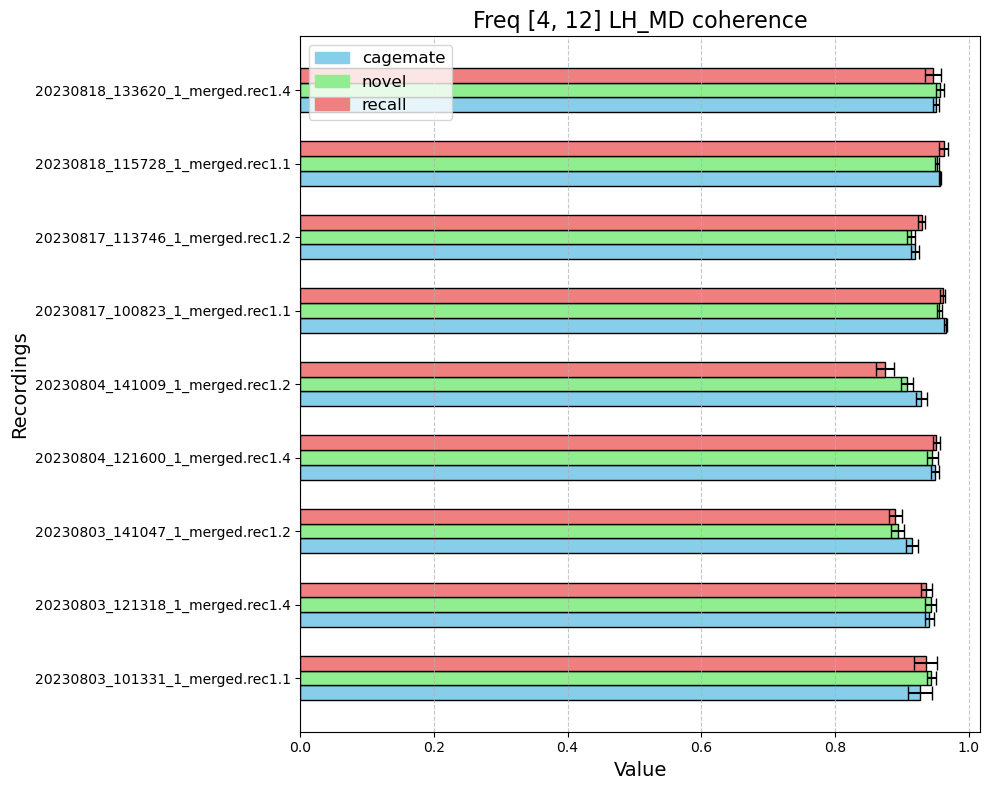

In [50]:
event_averages = []
event_sems = []
recordings = []
from matplotlib.patches import Patch 
# Define the events
events = ['cagemate', 'novel', 'recall']
coherence_pair = 'LH_MD'
pair_index = test_analysis.coherence_pairs_dict[coherence_pair]
freq_range = [4, 12]

# Loop through each recording and each event
for recording in test_analysis.collection:
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)
    for event in events:
        event_average = test_analysis.__get_event_averages__(recording,
                                                             event=event,
                                                             mode='coherence',
                                                             event_len=None,
                                                             pre_window=0,
                                                             post_window=0)
        event_array = np.array(event_average)
        event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)
        event_mean = np.nanmean(np.array(event_average[:]), axis=0)
        event_sem = stats.sem(np.array(event_average), axis=0, nan_policy='omit')
        event_averages.append(event_mean)
        event_sems.append(event_sem)

# Define the number of bars and their positions
num_recordings = len(test_analysis.collection)
num_events = len(events)
bar_width = 0.2
x = np.arange(num_recordings)

# Define colors for each event
colors = ['skyblue', 'lightgreen', 'lightcoral']
color_map = {events[i]: colors[i] for i in range(num_events)}

# Create the bar plot
plt.figure(figsize=(10, 8))

# Plot each bar with appropriate color and error bars
for i, recording in enumerate(recordings):
    for j, event in enumerate(events):
        idx = i * num_events + j
        plt.barh(x[i] + j * bar_width, event_averages[idx], xerr=event_sems[idx], 
                 capsize=5, color=color_map[event], edgecolor='black', height=bar_width,
                 label=event if i == 0 else '')

# Add labels and title
plt.ylabel('Recordings', fontsize=14)
plt.xlabel('Value', fontsize=14)
plt.title(f'Freq {freq_range} {coherence_pair} coherence', fontsize=16)

# Set custom y-ticks
ytick_positions = x + bar_width
plt.yticks(ytick_positions, recordings)

# Add a legend
handles = [Patch(color=color, label=event) for event, color in color_map.items()]
plt.legend(handles=handles, fontsize=12)

# Customize the plot (optional)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\176901435.py:23: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)


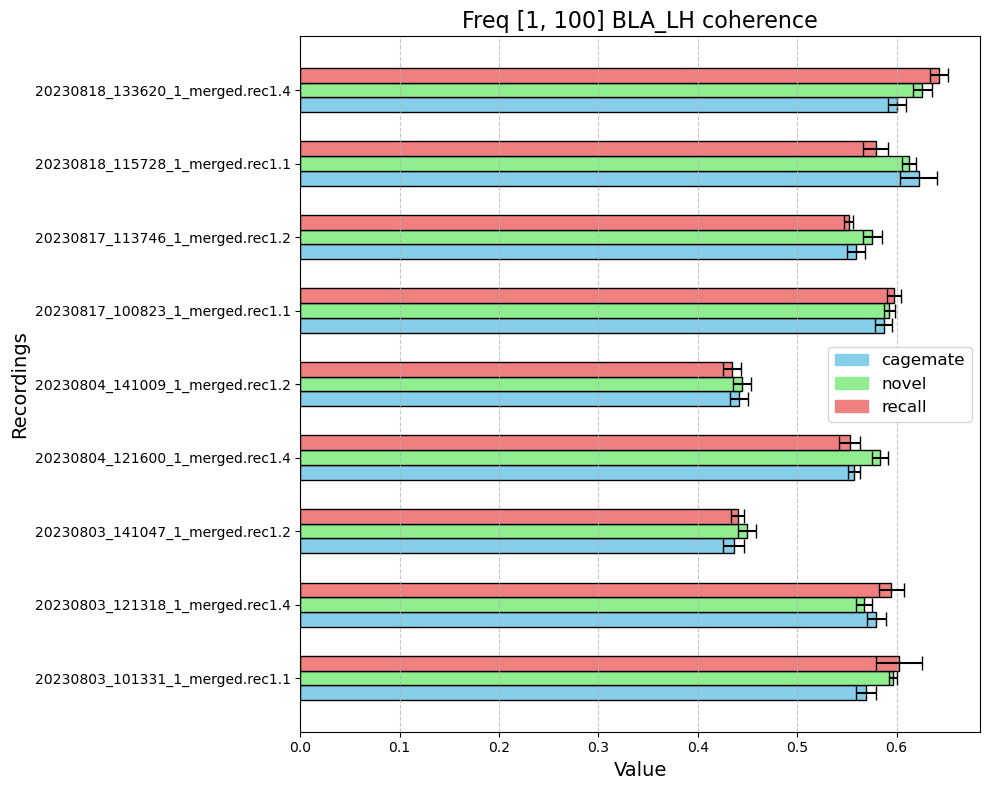

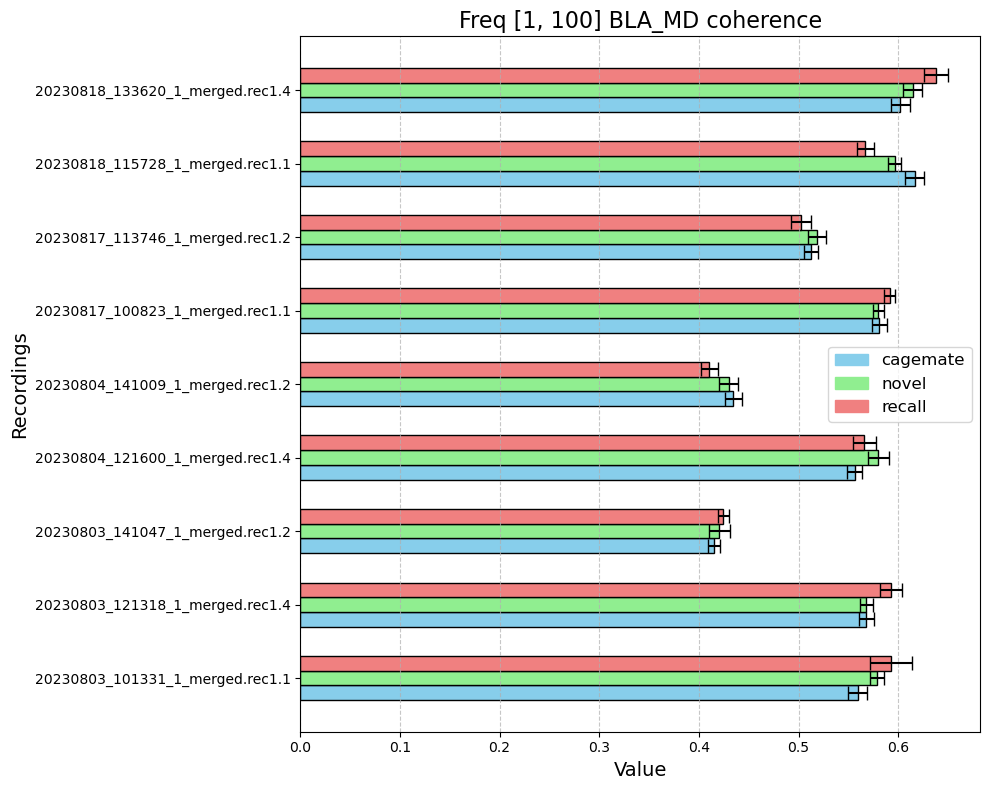

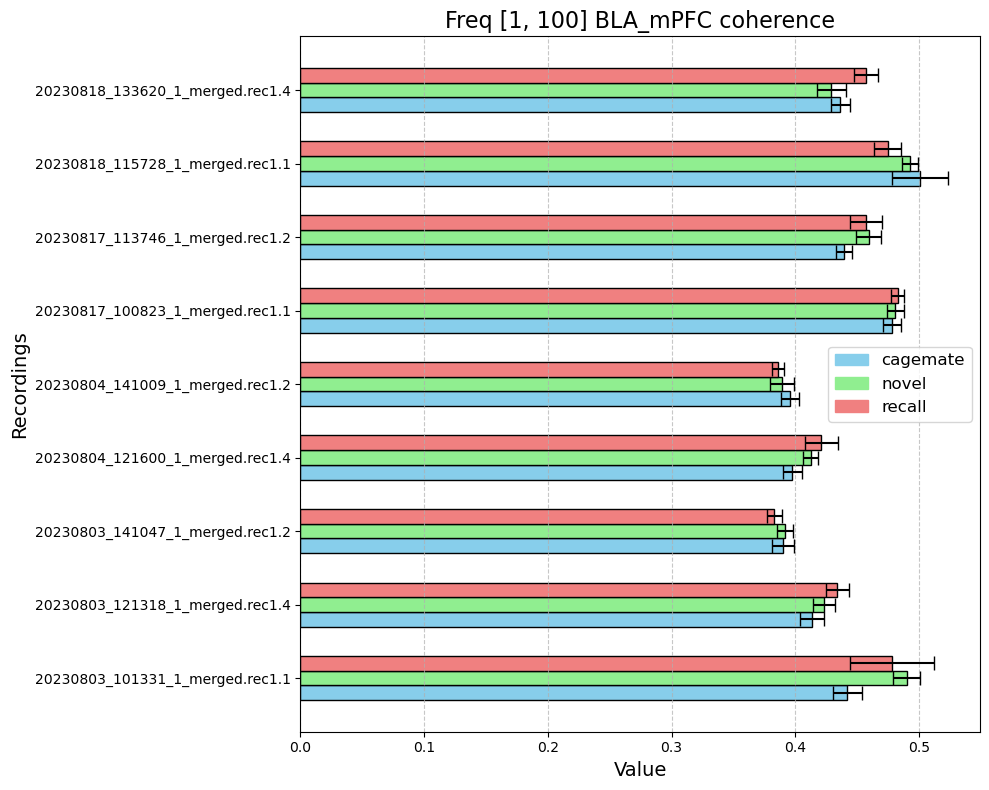

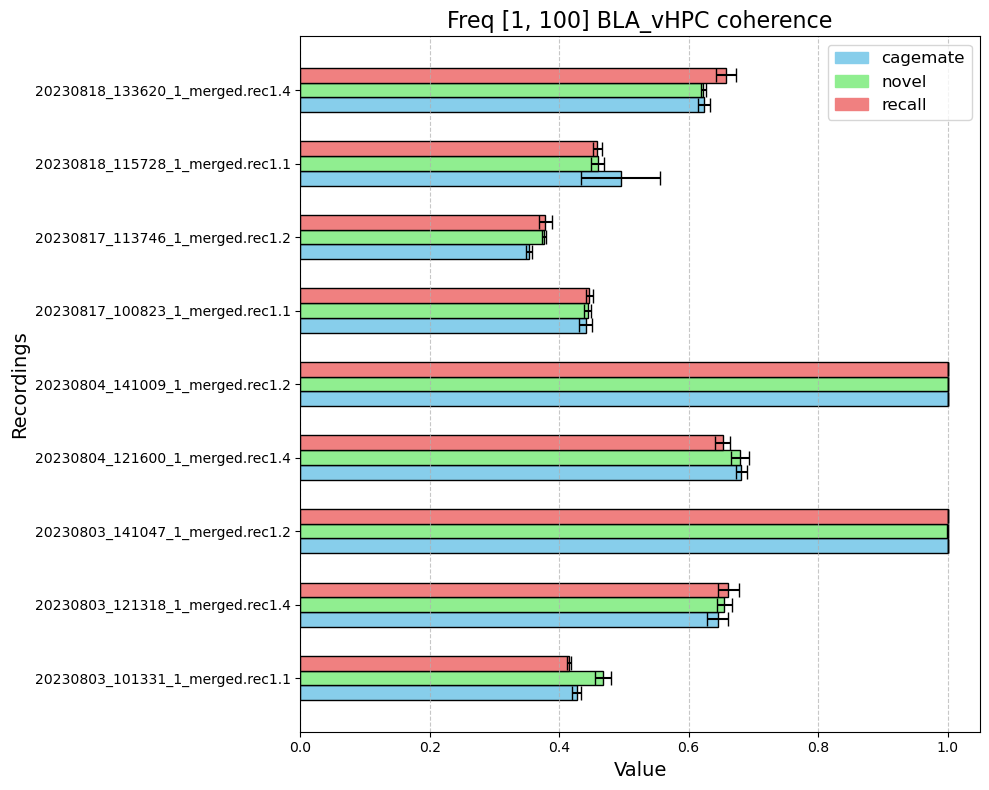

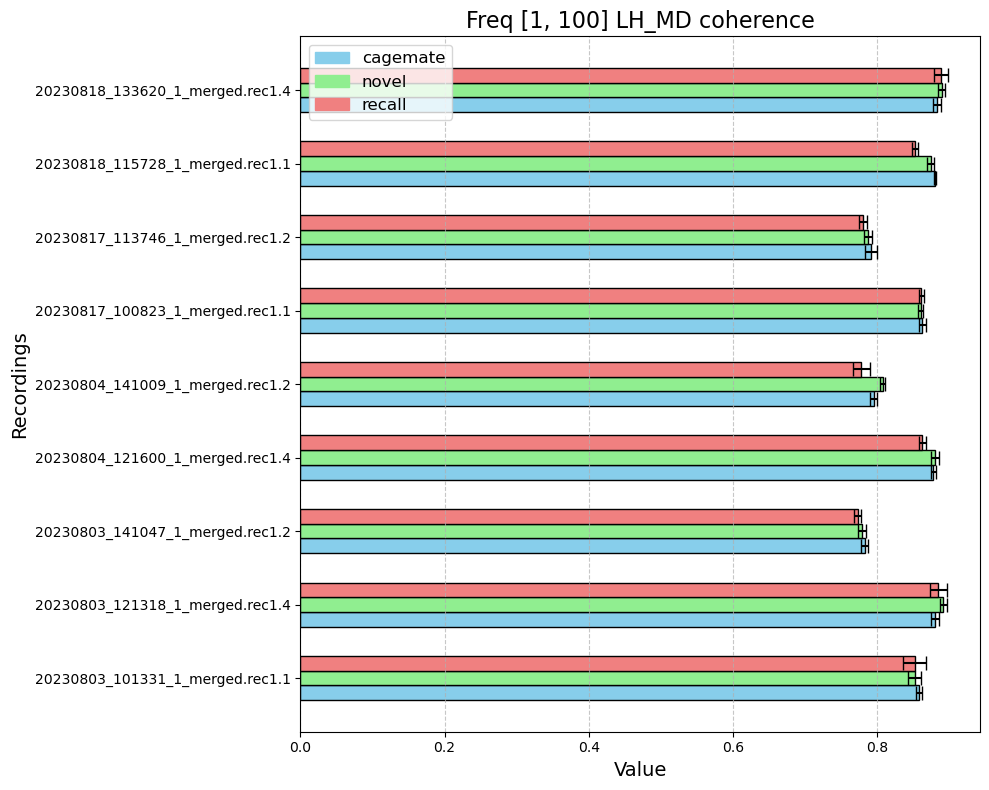

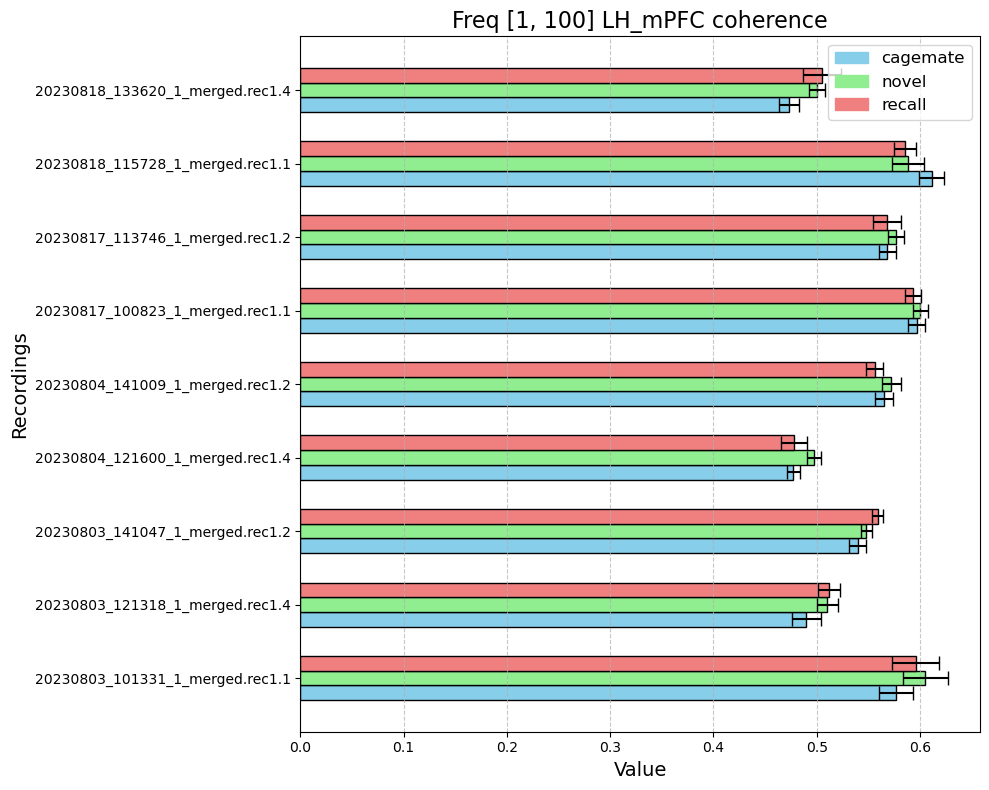

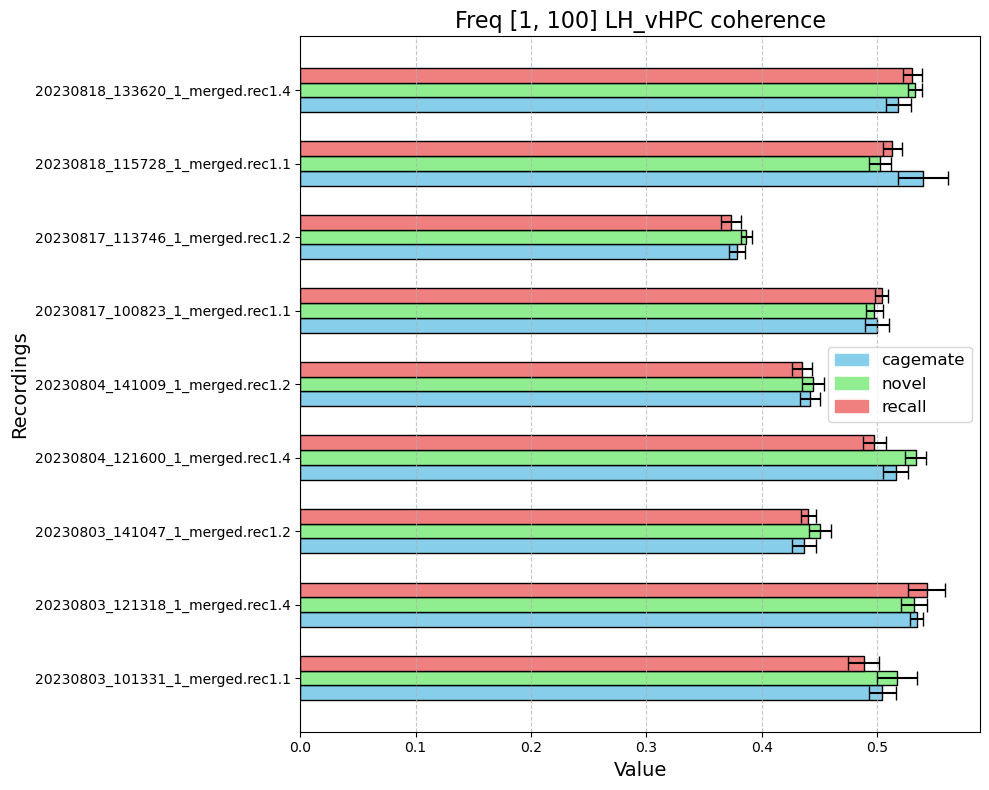

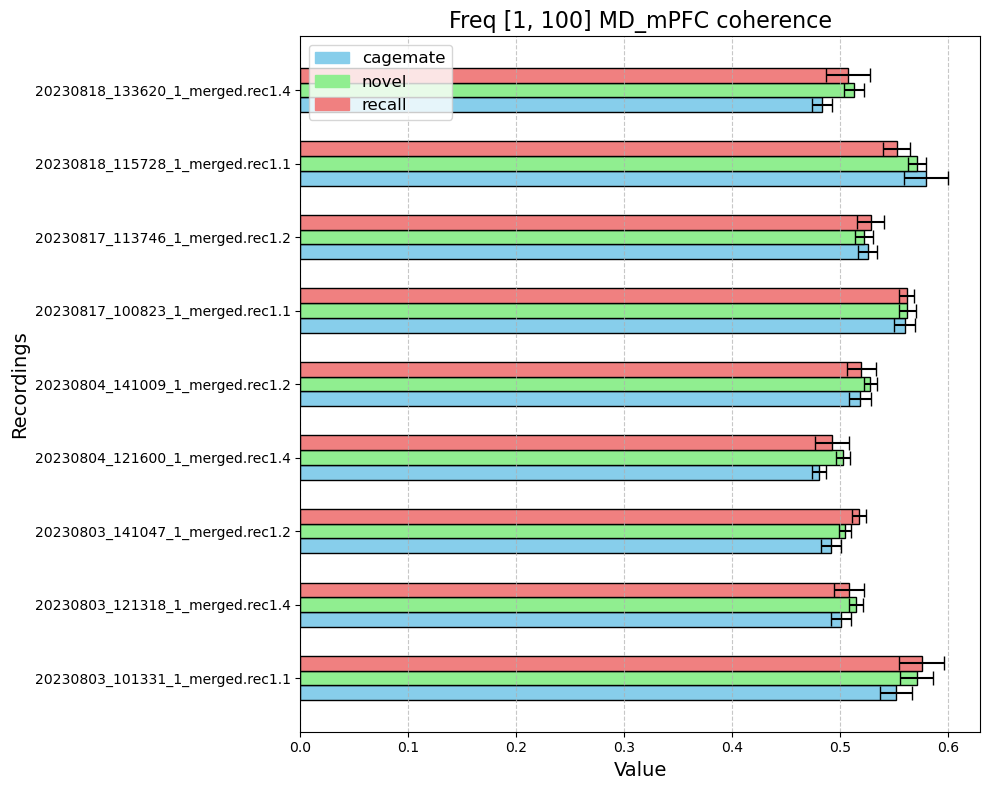

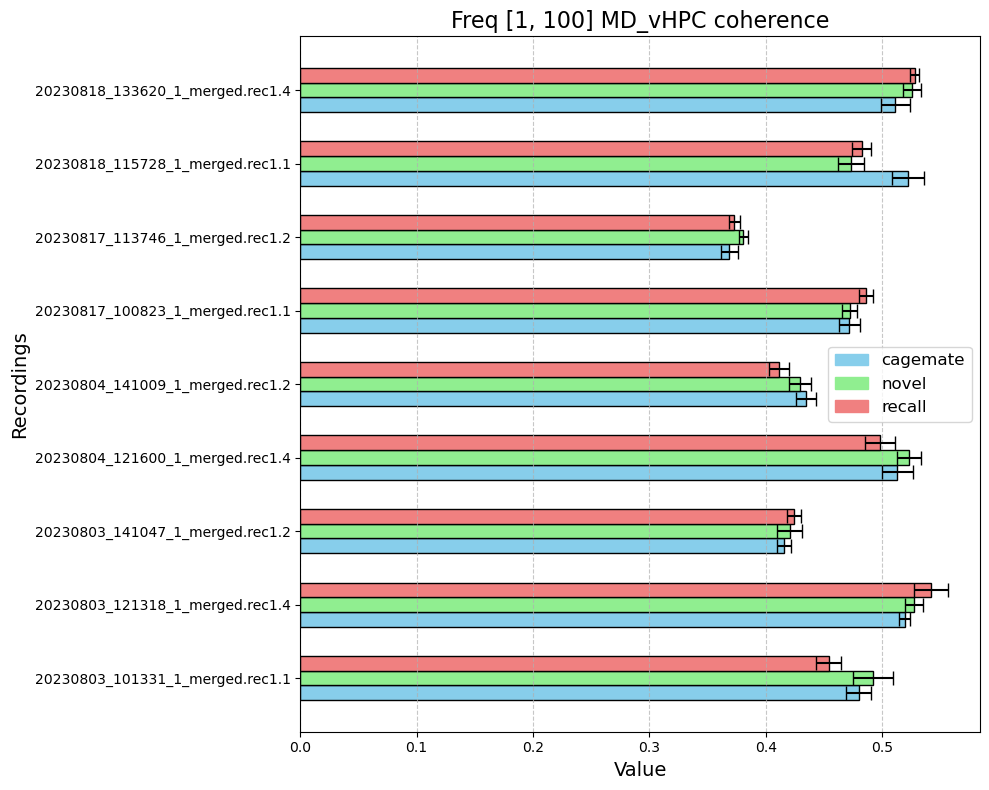

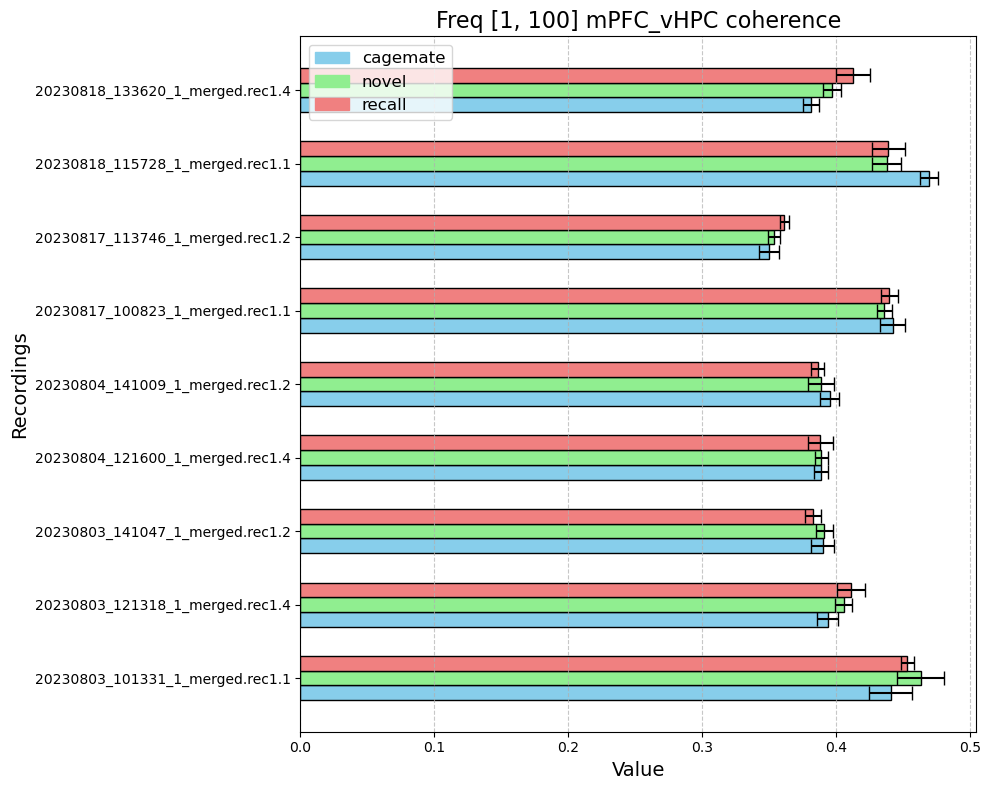

In [60]:

from matplotlib.patches import Patch 
# Define the events
events = ['cagemate', 'novel', 'recall']
coherence_pair = 'BLA_vHPC'
for coherence_pair in test_analysis.coherence_pairs:
    pair_index = test_analysis.coherence_pairs_dict[coherence_pair]
    freq_range = [1, 100]
    event_averages = []
    event_sems = []
    recordings = []
    # Loop through each recording and each event
    for recording in test_analysis.collection:
        rec_info = recording.merged_rec + recording.subject
        recordings.append(rec_info)
        for event in events:
            event_average = test_analysis.__get_event_averages__(recording,
                                                                event=event,
                                                                mode='coherence',
                                                                event_len=None,
                                                                pre_window=0,
                                                                post_window=0)
            event_array = np.array(event_average)
            event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)
            event_mean = np.nanmean(np.array(event_average[:]), axis=0)
            event_sem = stats.sem(np.array(event_average), axis=0, nan_policy='omit')
            event_averages.append(event_mean)
            event_sems.append(event_sem)

    # Define the number of bars and their positions
    num_recordings = len(test_analysis.collection)
    num_events = len(events)
    bar_width = 0.2
    x = np.arange(num_recordings)

    # Define colors for each event
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    color_map = {events[i]: colors[i] for i in range(num_events)}

    # Create the bar plot
    plt.figure(figsize=(10, 8))

    # Plot each bar with appropriate color and error bars
    for i, recording in enumerate(recordings):
        for j, event in enumerate(events):
            idx = i * num_events + j
            plt.barh(x[i] + j * bar_width, event_averages[idx], xerr=event_sems[idx], 
                    capsize=5, color=color_map[event], edgecolor='black', height=bar_width,
                    label=event if i == 0 else '')

    # Add labels and title
    plt.ylabel('Recordings', fontsize=14)
    plt.xlabel('Value', fontsize=14)
    plt.title(f'Freq {freq_range} {coherence_pair} coherence', fontsize=16)

    # Set custom y-ticks
    ytick_positions = x + bar_width
    plt.yticks(ytick_positions, recordings)

    # Add a legend
    handles = [Patch(color=color, label=event) for event, color in color_map.items()]
    plt.legend(handles=handles, fontsize=12)

    # Customize the plot (optional)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

3


C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)


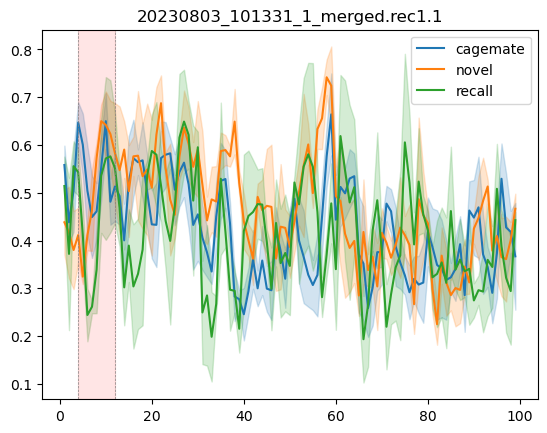

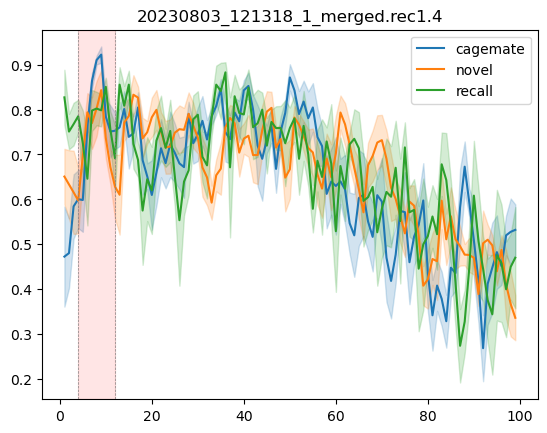

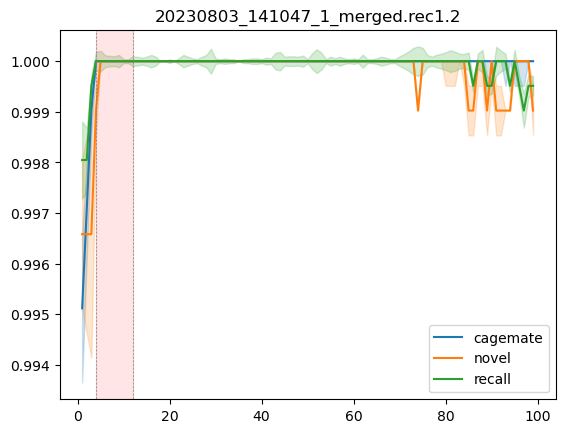

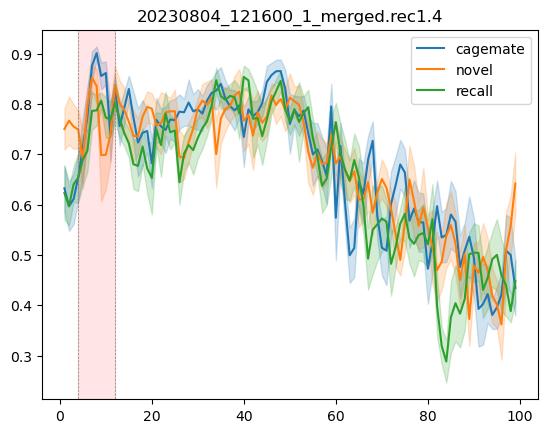

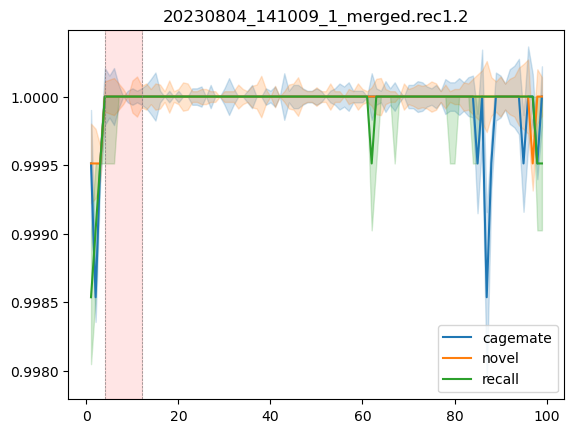

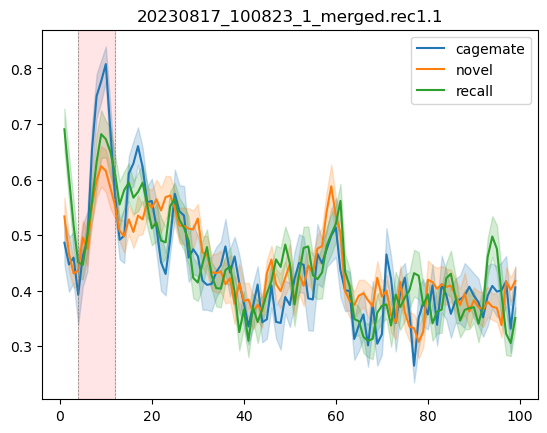

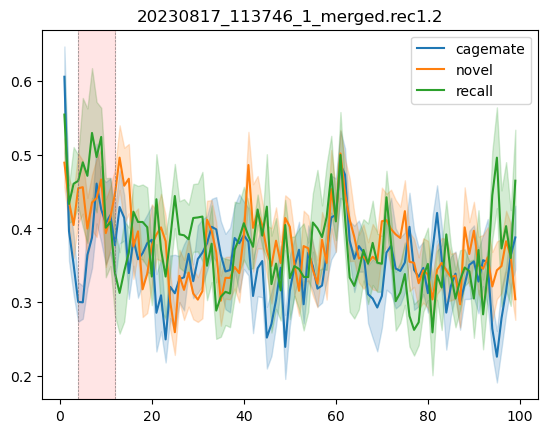

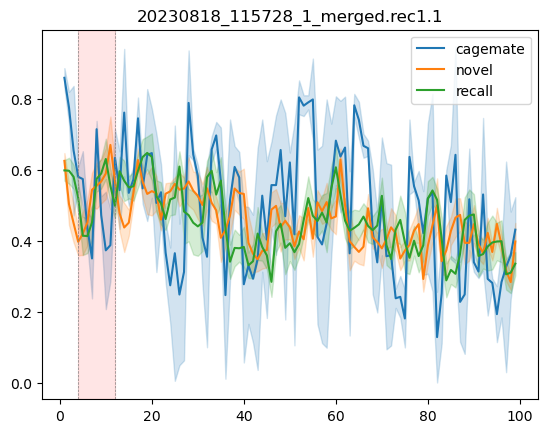

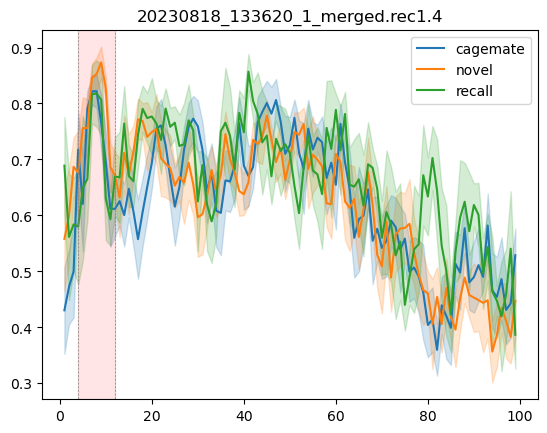

In [70]:
events = ['cagemate', 'novel', 'recall']
coherence_pair = 'BLA_vHPC'
pair_index = test_analysis.coherence_pairs_dict[coherence_pair]
print(pair_index)
freq_range = [1, 100]
event_averages = []
event_sems = []
recordings = []
# Loop through each recording and each event
for recording in test_analysis.collection:
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)
    for event in events:
        event_average = test_analysis.__get_event_averages__(recording,
                                                            event=event,
                                                            mode='coherence',
                                                            event_len=None,
                                                            pre_window=0,
                                                            post_window=0)
        event_array = np.array(event_average)
        event_average = np.nanmean(event_array, axis=0)    
        # event_average = [b,f]; average across all trials
        #calculate sem for the trial average
        event_sem = stats.sem(event_array, axis = 0, nan_policy='omit')
        #pick only the region of interest
        y_sem = event_sem[pair_index,1:100]
        y = event_average[pair_index,1:100]
        x = test_analysis.coherence_frequencies[1:100]
        line, = plt.plot(x, y, label = event) 
        plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
    ymin, ymax = plt.ylim()
    plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
    plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
    plt.ylim(ymin, ymax)
    plt.title(f"{rec_info}")
    plt.legend()
    plt.show()

In [126]:
for recording in test_analysis.collection:
    print(recording.merged_rec)

20230803_101331_1_merged.rec
20230803_121318_1_merged.rec
20230803_141047_1_merged.rec
20230804_121600_1_merged.rec
20230804_141009_1_merged.rec
20230817_100823_1_merged.rec
20230817_113746_1_merged.rec
20230818_115728_1_merged.rec
20230818_133620_1_merged.rec


4


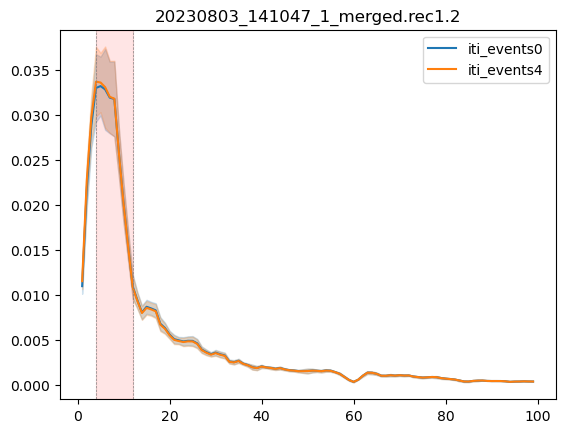

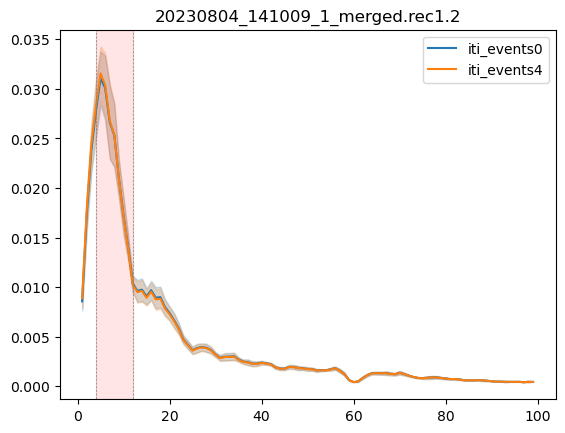

In [136]:
events = ['iti_events']
coherence_pair1 = 'BLA'
coherence_pair2 = 'vHPC'
pair_index_1 = test_analysis.brain_region_dict[coherence_pair1]
pair_index_2 = test_analysis.brain_region_dict[coherence_pair2]
pair_indices = [pair_index_1,pair_index_2]
print(pair_index)
freq_range = [1, 100]
event_averages = []
event_sems = []
recordings = []
# Loop through each recording and each event
for recording in test_analysis.collection:
    if (recording.merged_rec == '20230804_141009_1_merged.rec') | (recording.merged_rec == '20230803_141047_1_merged.rec'):
        rec_info = recording.merged_rec + recording.subject
        recordings.append(rec_info)
        for event in events:
            event_average = test_analysis.__get_event_averages__(recording,
                                                                event=event,
                                                                mode='power',
                                                                event_len=None,
                                                                pre_window=0,
                                                                post_window=0)
            event_array = np.array(event_average)
            event_average = np.nanmean(event_array, axis=0)    
            # event_average = [b,f]; average across all trials
            #calculate sem for the trial average
            event_sem = stats.sem(event_array, axis = 0, nan_policy='omit')
            #pick only the region of interest
            for pair_index in pair_indices:
                y_sem = event_sem[pair_index,1:100]
                y = event_average[pair_index,1:100]
                x = test_analysis.coherence_frequencies[1:100]
                line, = plt.plot(x, y, label = (event+str(pair_index)) )
                plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
        ymin, ymax = plt.ylim()
        plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
        plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
        plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
        plt.ylim(ymin, ymax)
        plt.title(f"{rec_info}")
        plt.legend()
        plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_13844\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_13844\1326502384.py:23: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)


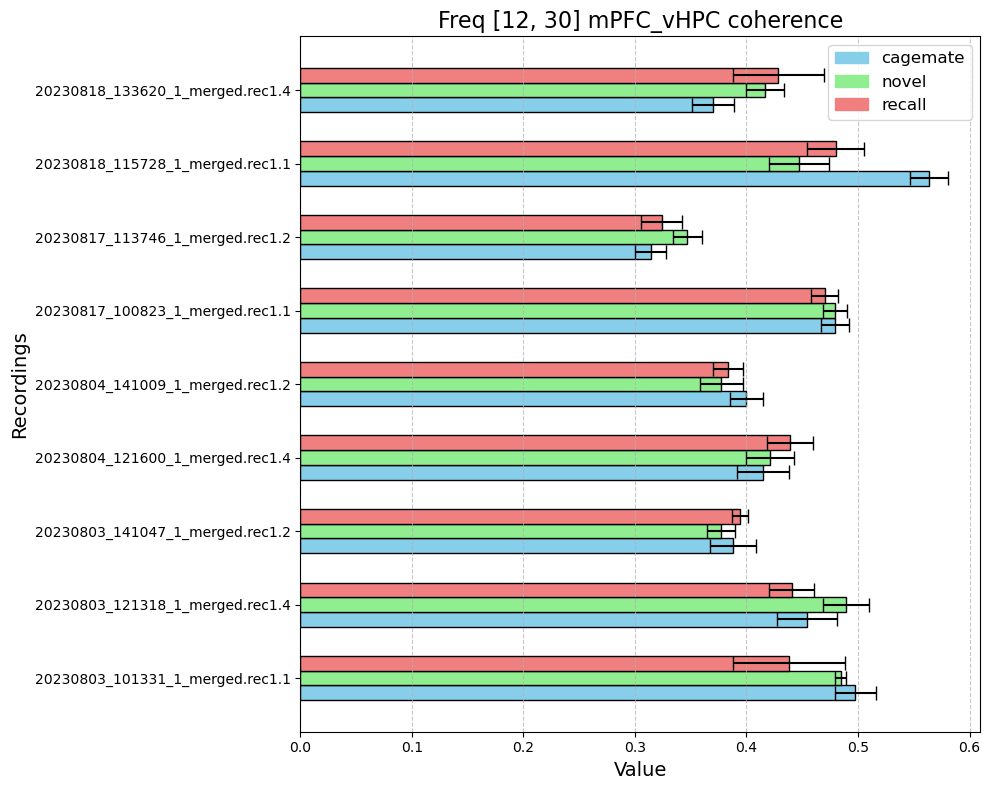

In [58]:
event_averages = []
event_sems = []
recordings = []
from matplotlib.patches import Patch 
# Define the events
events = ['cagemate', 'novel', 'recall']
coherence_pair = 'mPFC_vHPC'
pair_index = test_analysis.coherence_pairs_dict[coherence_pair]
freq_range = [12, 30]

# Loop through each recording and each event
for recording in test_analysis.collection:
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)
    for event in events:
        event_average = test_analysis.__get_event_averages__(recording,
                                                             event=event,
                                                             mode='coherence',
                                                             event_len=None,
                                                             pre_window=0,
                                                             post_window=0)
        event_array = np.array(event_average)
        event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)
        event_mean = np.nanmean(np.array(event_average[:]), axis=0)
        event_sem = stats.sem(np.array(event_average), axis=0, nan_policy='omit')
        event_averages.append(event_mean)
        event_sems.append(event_sem)

# Define the number of bars and their positions
num_recordings = len(test_analysis.collection)
num_events = len(events)
bar_width = 0.2
x = np.arange(num_recordings)

# Define colors for each event
colors = ['skyblue', 'lightgreen', 'lightcoral']
color_map = {events[i]: colors[i] for i in range(num_events)}

# Create the bar plot
plt.figure(figsize=(10, 8))

# Plot each bar with appropriate color and error bars
for i, recording in enumerate(recordings):
    for j, event in enumerate(events):
        idx = i * num_events + j
        plt.barh(x[i] + j * bar_width, event_averages[idx], xerr=event_sems[idx], 
                 capsize=5, color=color_map[event], edgecolor='black', height=bar_width,
                 label=event if i == 0 else '')

# Add labels and title
plt.ylabel('Recordings', fontsize=14)
plt.xlabel('Value', fontsize=14)
plt.title(f'Freq {freq_range} {coherence_pair} coherence', fontsize=16)

# Set custom y-ticks
ytick_positions = x + bar_width
plt.yticks(ytick_positions, recordings)

# Add a legend
handles = [Patch(color=color, label=event) for event, color in color_map.items()]
plt.legend(handles=handles, fontsize=12)

# Customize the plot (optional)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
test_analysis.coherence_pairs_dict['LH_mPFC']
print(test_analysis.coherence_pairs)
print(test_analysis.coherence_pairs_dict)

['BLA_LH', 'BLA_MD', 'BLA_mPFC', 'BLA_vHPC', 'LH_MD', 'LH_mPFC', 'LH_vHPC', 'MD_mPFC', 'MD_vHPC', 'mPFC_vHPC']
{'mPFC_vHPC': 0, 'LH_mPFC': 1, 'MD_mPFC': 2, 'BLA_mPFC': 3, 'LH_vHPC': 4, 'MD_vHPC': 5, 'BLA_vHPC': 6, 'LH_MD': 7, 'BLA_LH': 8, 'BLA_MD': 9}


C:\Users\megha\AppData\Local\Temp\ipykernel_33364\2911971127.py:296: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_33364\4105158787.py:22: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)


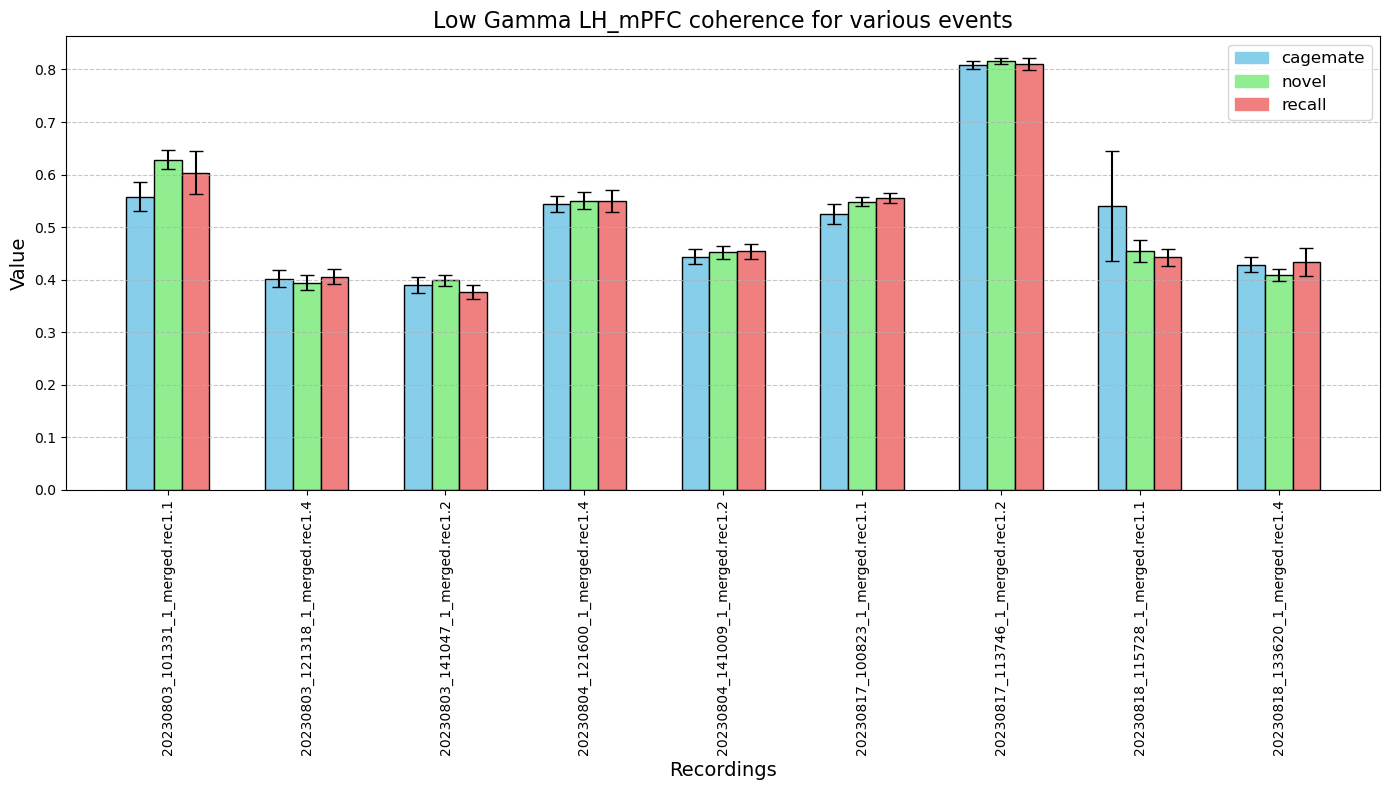

In [ ]:
event_averages = []
event_sems = []
recordings = []
from matplotlib.patches import Patch 
# Define the events
events = ['cagemate', 'novel', 'recall']
pair_index = 1
freq_range = [30, 70]

# Loop through each recording and each event
for recording in test_analysis.collection:
    rec_info = recording.merged_rec + recording.subject
    recordings.append(rec_info)
    for event in events:
        event_average = test_analysis.__get_event_averages__(recording,
                                                             event=event,
                                                             mode='coherence',
                                                             event_len=None,
                                                             pre_window=0,
                                                             post_window=0)
        event_array = np.array(event_average)
        event_average = np.nanmean(event_array[:, pair_index, freq_range[0]:freq_range[1]], axis=1)
        event_mean = np.nanmean(np.array(event_average[:]), axis=0)
        event_sem = stats.sem(np.array(event_average), axis=0, nan_policy='omit')
        event_averages.append(event_mean)
        event_sems.append(event_sem)

# Define the number of bars and their positions
num_recordings = len(test_analysis.collection)
num_events = len(events)
bar_width = 0.2
x = np.arange(num_recordings)

# Define colors for each event
colors = ['skyblue', 'lightgreen', 'lightcoral']
color_map = {events[i]: colors[i] for i in range(num_events)}

# Create the bar plot
plt.figure(figsize=(14, 8))

# Plot each bar with appropriate color and error bars
for i, recording in enumerate(recordings):
    for j, event in enumerate(events):
        idx = i * num_events + j
        plt.bar(x[i] + j * bar_width, event_averages[idx], yerr=event_sems[idx], 
                capsize=5, color=color_map[event], edgecolor='black', width=bar_width,
                label=event if i == 0 else '')

# Add labels and title
plt.xlabel('Recordings', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Low Gamma LH_mPFC coherence for various events', fontsize=16)

# Set custom x-ticks
xtick_positions = x + bar_width
plt.xticks(xtick_positions, recordings, rotation=90, ha='center')

# Add a legend
handles = [Patch(color=color, label=event) for event, color in color_map.items()]
plt.legend(handles=handles, fontsize=12)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
metadata_df = unpickle_this(r"D:\social_ephys_pilot2_cum\data\phase2\20230804_141009_1.2_2t2bL_NFC.rec\outputs\metadata.pkl")
metadata_df.columns

Index(['session_dir', 'recording', 'metadata_dir', 'metadata_file',
       'description', 'byte_order', 'original_file', 'clockrate',
       'trodes_version', 'compile_date', 'compile_time', 'qt_version',
       'commit_tag', 'controller_firmware', 'headstage_firmware',
       'controller_serialnum', 'headstage_serialnum', 'autosettle', 'smartref',
       'gyro', 'accelerometer', 'magnetometer', 'time_offset',
       'system_time_at_creation', 'timestamp_at_creation', 'first_timestamp',
       'fields', 'data', 'filename', 'clock rate', 'session_path',
       'first_dtype_name', 'first_item_data', 'last_dtype_name',
       'last_item_data', 'all_subjects', 'current_subject'],
      dtype='object')

In [74]:
metadata_df['data']

0    [[3503479], [3503480], [3503481], [3503482], [...
1    [[3503477, 0, 0], [3503477, 0, 0], [3504863, 0...
Name: data, dtype: object

In [ ]:


TRODES_STREAM_ID="trodes"
RECORDING_EXTENTION="*merged.rec"
           

LFP_FREQ_MIN=0.5
LFP_FREQ_MAX=300
ELECTRIC_NOISE_FREQ=60
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000

recording_path = r"D:\social_ephys_pilot2_cum\data\phase2\20230804_141009_1.2_2t2bL_NFC.rec\20230804_141009_1_merged.rec"


current_recording = se.read_spikegadgets(
    recording_path, stream_id=TRODES_STREAM_ID)
#print(recording_basename)
# # Preprocessing the LFP
current_recording = sp.notch_filter(
    current_recording, freq=ELECTRIC_NOISE_FREQ)
current_recording = sp.bandpass_filter(
    current_recording, freq_min=LFP_FREQ_MIN, freq_max=LFP_FREQ_MAX)
current_recording = sp.resample(
    current_recording, resample_rate=LFP_SAMPLING_RATE)


In [83]:
current_recording

ResampleRecording: 32 channels - 1.0kHz - 1 segments - 2,105,993 samples 
                   2,105.99s (35.10 minutes) - int16 dtype - 128.54 MiB

In [85]:
print(current_recording)

<class 'spikeinterface.preprocessing.resample.ResampleRecording'>


In [90]:
current_recording.channel_slice


<bound method BaseRecordingSnippets.channel_slice of ResampleRecording: 32 channels - 1.0kHz - 1 segments - 2,105,993 samples 
                   2,105.99s (35.10 minutes) - int16 dtype - 128.54 MiB>

In [92]:
print(current_recording.get_channel_groups())

None


In [97]:

start_frame = 10*60*1000
stop_frame = 11*60*1000

In [113]:
traces = current_recording.get_traces(start_frame=start_frame, end_frame=stop_frame).T



In [122]:
traces.shape
current_recording.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

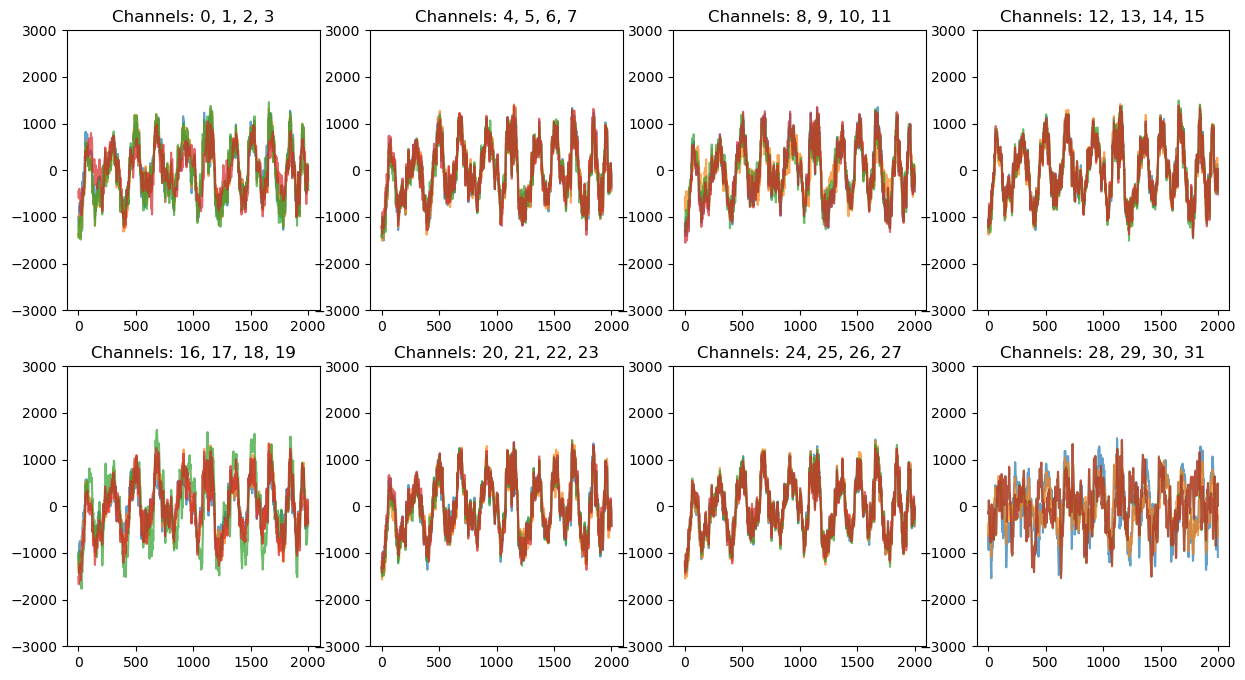

In [124]:
channel_groups = 4  # Assuming you have 8 channels per group
plot_count = 0  # Counter to keep track of how many plots are in the current subplot
duration = 2000
#from labellines import labelLine, labelLines
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
for num in range(traces.shape[0]// channel_groups):
      # Create the figure and 8 subplots (2x4)
    max_value = np.nanmax(traces)
    min_value = np.nanmin(traces)
    trimmed_traces = traces[:,:duration]
    if max_value >= 3000:
        max_value = 3000
    if min_value <= -3000:
        min_value = -3000
    all_channels = []
    ax = axs[num // 4, num % 4]  # Select the appropriate subplot

    for channel_displacement in range(channel_groups):
        current_ch = int(num * channel_groups + channel_displacement)
        trace = trimmed_traces[current_ch,:]
        ax.plot(trace, label=current_ch, alpha=0.7)  # Plot the trace
        all_channels.append(str(current_ch))
    ax.set_title("Channels: " + ", ".join(all_channels))
    #labelLines(ax.get_lines(), zorder=2.5)
    ax.set_ylim(min_value, max_value)  # Set a title for each subplot
plt.show()